In [1]:
# Imports and setup
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_dense_adj
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
import logging
from sklearn.decomposition import PCA

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
plt.style.use('seaborn')

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
import logging

class MolecularGVAE(nn.Module):
    def __init__(self, node_features=3, hidden_dim=64, latent_dim=32, num_neighbors=3):
        super(MolecularGVAE, self).__init__()
        self.node_features = node_features
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_neighbors = num_neighbors  # Number of nearest neighbors to consider

        # Encoder layers
        self.enc_conv1 = GATv2Conv(node_features, hidden_dim)
        self.enc_conv2 = GATv2Conv(hidden_dim, hidden_dim)

        # Use GroupNorm instead of BatchNorm
        self.enc_norm1 = nn.GroupNorm(8, hidden_dim)
        self.enc_norm2 = nn.GroupNorm(8, hidden_dim)

        # Latent space
        self.node_mu = nn.Linear(hidden_dim, latent_dim)
        self.node_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder for node features
        self.dec_node_features = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.GroupNorm(8, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.GroupNorm(8, hidden_dim),
            nn.Linear(hidden_dim, node_features)
        )

        # Neighbor attention mechanism
        self.neighbor_attention = nn.Sequential(
            nn.Linear(2 * latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

        # Edge prediction with neighbor context
        self.edge_pred = nn.Sequential(
            nn.Linear(3 * latent_dim, hidden_dim),  # 2 * latent for nodes + latent for neighbor context
            nn.ReLU(),
            nn.GroupNorm(8, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def compute_neighbor_context(self, z, edge_index):
        """Compute context vector based on neighboring nodes"""
        num_nodes = z.size(0)
        neighbor_context = torch.zeros(num_nodes, self.latent_dim, device=z.device)

        for node_idx in range(num_nodes):
            # Get k-hop neighborhood
            subset, subset_edge_index, mapping, _ = k_hop_subgraph(
                node_idx=node_idx,
                num_hops=1,
                edge_index=edge_index,
                relabel_nodes=True,
                num_nodes=num_nodes
            )

            if len(subset) > 1:  # If node has neighbors
                # Get neighbor embeddings
                neighbor_embeds = z[subset[1:]]  # Exclude the central node

                # Compute attention weights
                central_embed = z[node_idx].unsqueeze(0).expand(len(neighbor_embeds), -1)
                attention_input = torch.cat([central_embed, neighbor_embeds], dim=1)
                attention_weights = F.softmax(self.neighbor_attention(attention_input), dim=0)

                # Compute weighted context
                neighbor_context[node_idx] = (neighbor_embeds * attention_weights).sum(dim=0)

        return neighbor_context

    def encode(self, data):
        x, edge_index = data.x, data.edge_index

        if x.device.type == 'mps':
            x = x.cpu()
            edge_index = edge_index.cpu()

        h = self.enc_conv1(x, edge_index)
        h = h.view(-1, self.hidden_dim)
        h = F.relu(self.enc_norm1(h))
        h = self.enc_conv2(h, edge_index)
        h = h.view(-1, self.hidden_dim)
        h = F.relu(self.enc_norm2(h))

        h = h.to(data.x.device)

        return self.node_mu(h), self.node_logvar(h)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def decode(self, z, edge_index, num_nodes):
        # Reconstruct node features
        node_features = self.dec_node_features(z)

        # Compute neighbor context for each node
        neighbor_context = self.compute_neighbor_context(z, edge_index)

        # Create adjacency matrix of edge predictions
        edge_logits = torch.zeros((num_nodes, num_nodes), device=z.device)

        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                if z.device.type == 'mps':
                    zi = z[i].cpu()
                    zj = z[j].cpu()
                    ctx = neighbor_context[i].cpu()
                else:
                    zi = z[i]
                    zj = z[j]
                    ctx = neighbor_context[i]

                # Include neighbor context in edge prediction
                edge_input = torch.cat([zi, zj, ctx], dim=0)
                edge_input = edge_input.unsqueeze(0).to(z.device)
                pred = self.edge_pred(edge_input)

                # Make adjacency matrix symmetric
                edge_logits[i, j] = pred
                edge_logits[j, i] = pred

        return node_features, edge_logits, neighbor_context

    def forward(self, data):
        mu, logvar = self.encode(data)
        z = self.reparameterize(mu, logvar)
        node_features, edge_logits, neighbor_context = self.decode(z, data.edge_index, data.x.size(0))
        return node_features, edge_logits, neighbor_context, mu, logvar

    def loss_function(self, node_features, edge_logits, neighbor_context, data, node_mu, node_logvar):
        # Node feature reconstruction loss
        recon_loss = F.mse_loss(node_features, data.x)

        # Edge prediction loss with neighbor awareness
        if edge_logits.numel() > 0:
            adj = to_dense_adj(data.edge_index, max_num_nodes=data.x.size(0))[0]
            edge_loss = F.binary_cross_entropy_with_logits(edge_logits, adj)
        else:
            edge_loss = torch.tensor(0.0).to(node_features.device)

        # KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + node_logvar - node_mu.pow(2) - node_logvar.exp())

        # Neighbor coherence loss - encourages similar nodes to have similar neighbor contexts
        neighbor_coherence_loss = 0.0
        if edge_logits.numel() > 0:
            adj_prob = torch.sigmoid(edge_logits)
            neighbor_sim = F.cosine_similarity(
                neighbor_context.unsqueeze(1),
                neighbor_context.unsqueeze(0),
                dim=2
            )
            neighbor_coherence_loss = F.mse_loss(adj_prob, neighbor_sim)

        # Weight the losses
        total_loss = recon_loss + edge_loss + 0.1 * kl_loss + 0.1 * neighbor_coherence_loss

        return total_loss, {
            'recon': recon_loss.item(),
            'edge': edge_loss.item(),
            'kl': kl_loss.item(),
            'neighbor': neighbor_coherence_loss.item()
        }
    
    
class TrainingManager:
    def __init__(self, model_name, checkpoint_dir='checkpoints'):
        self.model_name = model_name
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(exist_ok=True)
        
        self.train_metrics = defaultdict(list)
        self.val_metrics = defaultdict(list)
        self.best_val_loss = float('inf')
        self.run_id = datetime.now().strftime("%Y%m%d_%H%M%S")

    def save_checkpoint(self, epoch, model, optimizer, train_loss, val_loss, metrics):
        checkpoint_path = self.checkpoint_dir / f"{self.model_name}_{self.run_id}_epoch{epoch}.pt"
        metrics_path = self.checkpoint_dir / f"{self.model_name}_{self.run_id}_metrics.json"

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_metrics': dict(self.train_metrics),
            'val_metrics': dict(self.val_metrics)
        }
        torch.save(checkpoint, checkpoint_path)

        metrics_dict = {
            'train': dict(self.train_metrics),
            'val': dict(self.val_metrics)
        }
        with open(metrics_path, 'w') as f:
            json.dump(metrics_dict, f, indent=4)

        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            best_path = self.checkpoint_dir / f"{self.model_name}_{self.run_id}_best.pt"
            torch.save(checkpoint, best_path)
            logger.info(f"\nNew best model saved with validation loss: {val_loss:.4f}")

    def update_metrics(self, epoch_metrics, phase='train'):
        metrics_dict = self.train_metrics if phase == 'train' else self.val_metrics
        for key, value in epoch_metrics.items():
            metrics_dict[key].append(value)

    def plot_training_progress(self):
        metrics = list(self.train_metrics.keys())
        n_metrics = len(metrics)
        
        fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 4*n_metrics))
        if n_metrics == 1:
            axes = [axes]
        
        for ax, metric in zip(axes, metrics):
            train_values = self.train_metrics[metric]
            ax.plot(train_values, label=f'Train {metric}', color='blue', alpha=0.7)
            
            if metric in self.val_metrics:
                val_values = self.val_metrics[metric]
                ax.plot(val_values, label=f'Val {metric}', color='red', alpha=0.7)
            
            ax.set_title(f'{metric} over Training')
            ax.set_xlabel('Epoch')
            ax.set_ylabel(metric)
            ax.grid(True)
            ax.legend()
        
        plt.tight_layout()
        plt.show()

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_13373/2623929861.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
from collections import defaultdict
import torch
from tqdm.notebook import tqdm
import logging
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, optimizer, n_epochs=100, device='cpu',
                patience=10, checkpoint_frequency=5, max_grad_norm=1.0):
    """Training loop with validation and early stopping"""
    manager = TrainingManager('molecular_gvae')

    # Early stopping setup
    patience_counter = 0
    best_val_loss = float('inf')

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_batch_metrics = defaultdict(float)

        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs} [Train]') as train_pbar:
            for batch in train_pbar:
                batch = batch.to(device)
                optimizer.zero_grad()

                # Forward pass
                node_features, edge_logits, neighbor_context, mu, logvar = model(batch)

                # Calculate loss
                loss, metrics = model.loss_function(
                    node_features, edge_logits, neighbor_context,
                    batch, mu, logvar
                )

                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # Update metrics
                train_loss += loss.item()
                for k, v in metrics.items():
                    train_batch_metrics[k] += v

                # Update progress bar
                train_pbar.set_postfix({
                    'loss': train_loss / (train_pbar.n + 1),
                    **{k: v / (train_pbar.n + 1) for k, v in train_batch_metrics.items()}
                })

        # Calculate average training metrics
        avg_train_metrics = {k: v / len(train_loader) for k, v in train_batch_metrics.items()}
        avg_train_metrics['total_loss'] = train_loss / len(train_loader)
        manager.update_metrics(avg_train_metrics, 'train')

        # Validation phase
        model.eval()
        val_loss = 0
        val_batch_metrics = defaultdict(float)

        with torch.no_grad():
            with tqdm(val_loader, desc=f'Epoch {epoch+1}/{n_epochs} [Val]') as val_pbar:
                for batch in val_pbar:
                    batch = batch.to(device)

                    # Forward pass
                    node_features, edge_logits, neighbor_context, mu, logvar = model(batch)

                    # Calculate loss
                    loss, metrics = model.loss_function(
                        node_features, edge_logits, neighbor_context,
                        batch, mu, logvar
                    )

                    # Update metrics
                    val_loss += loss.item()
                    for k, v in metrics.items():
                        val_batch_metrics[k] += v

                    # Update progress bar
                    val_pbar.set_postfix({
                        'loss': val_loss / (val_pbar.n + 1),
                        **{k: v / (val_pbar.n + 1) for k, v in val_batch_metrics.items()}
                    })

        # Calculate average validation metrics
        avg_val_metrics = {k: v / len(val_loader) for k, v in val_batch_metrics.items()}
        avg_val_metrics['total_loss'] = val_loss / len(val_loader)
        manager.update_metrics(avg_val_metrics, 'val')

        # Early stopping check
        if avg_val_metrics['total_loss'] < best_val_loss:
            best_val_loss = avg_val_metrics['total_loss']
            patience_counter = 0
        else:
            patience_counter += 1

        # Save checkpoint
        if (epoch + 1) % checkpoint_frequency == 0:
            manager.save_checkpoint(
                epoch, model, optimizer,
                avg_train_metrics['total_loss'],
                avg_val_metrics['total_loss'],
                {'train': avg_train_metrics, 'val': avg_val_metrics}
            )
            manager.plot_training_progress()

        # Print epoch summary
        logger.info(f"\nEpoch {epoch+1}/{n_epochs}")
        logger.info(f"Train Loss: {avg_train_metrics['total_loss']:.4f}")
        logger.info(f"Val Loss: {avg_val_metrics['total_loss']:.4f}")

        # Early stopping
        if patience_counter >= patience:
            logger.info(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break

    return manager

def plot_latent_space(model, loader, device):
    """Visualize the latent space using PCA"""
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            mu, _ = model.encode(batch)
            latent_vectors.append(mu.cpu().numpy())

            # Get the degree of each node as a simple structural feature
            degrees = torch.zeros(batch.x.size(0))
            unique_nodes, counts = torch.unique(batch.edge_index[0], return_counts=True)
            degrees[unique_nodes] = counts.float()
            labels.append(degrees.numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    # PCA visualization
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                          c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Node Degree')
    plt.title('Latent Space Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

In [3]:
# Define the file for a demo protein structure
pdb_file = '/Users/alexchilton/Downloads/archive/train/AF-D0ZA02-F1-model_v4.pdb'

# Define the directory containing the PDB files
pdb_directory = '/Users/alexchilton/Downloads/archive/just100'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

In [4]:
from ProteinAnalyzer import ProteinAnalyzer
def load_pdb_files(directory):
    ''' Load all PDB files from the specified directory '''
    pdb_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pdb')]
    return pdb_files

def create_autoencoder_input_dfs(pdb_files, aa_info_file):
    ''' Create autoencoder input DataFrames for all PDB files '''
    autoencoder_input_dfs = []
    for pdb_file in pdb_files:
        analyzer = ProteinAnalyzer(pdb_file, aa_info_file)
        autoencoder_input_df = analyzer.prepare_autoencoder_input()
        autoencoder_input_dfs.append(autoencoder_input_df)
    return autoencoder_input_dfs


# Load PDB files
pdb_files = load_pdb_files(pdb_directory)

# Create autoencoder input DataFrames
autoencoder_input_dfs = create_autoencoder_input_dfs(pdb_files, aa_info_file)

In [5]:
from Utils import Utils
# Assuming autoencoder_input_dfs is already defined convert the onject types to float
autoencoder_input_dfs = Utils.convert_columns_to_float(autoencoder_input_dfs)

# Verify the conversion
print(autoencoder_input_dfs[0].dtypes)
print(autoencoder_input_dfs[0].head())

X                    float64
Y                    float64
Z                    float64
AA                    object
Avg_Mass             float64
Avg_Neighbor_Dist    float64
Max_Neighbor_Dist    float64
Neighbor_Count       float64
dtype: object
       X      Y      Z AA   Avg_Mass  Avg_Neighbor_Dist  Max_Neighbor_Dist  \
0 -3.361  0.103  5.039  I  131.17464           3.862061           3.862061   
1 -0.566 -2.557  5.206  I  131.17464           3.860735           3.862061   
2 -1.398 -3.989  1.720  E  147.13074           3.856269           3.859410   
3 -1.416 -0.429  0.246  K  146.18934           3.852071           3.853129   
4  1.985  0.279  1.908  L  131.17464           3.853064           3.855114   

   Neighbor_Count  
0             1.0  
1             2.0  
2             2.0  
3             2.0  
4             2.0  


In [6]:

from Utils import Utils
# Assuming autoencoder_input_dfs is already defined
onehot_encoder = Utils.create_onehot_encoder(autoencoder_input_dfs)

encoded_autoencoder_input_dfs = [Utils.encode_values(df, onehot_encoder) for df in autoencoder_input_dfs]
#decoded_autoencoder_input_dfs = [decode_values(df) for df in new_autoencoder_input_dfs]

# Print the first few rows of the first encoded and decoded DataFrame
print(encoded_autoencoder_input_dfs[0].head())
#print(decoded_autoencoder_input_dfs[0].head())

       X      Y      Z   Avg_Mass  Avg_Neighbor_Dist  Max_Neighbor_Dist  \
0 -3.361  0.103  5.039  131.17464           3.862061           3.862061   
1 -0.566 -2.557  5.206  131.17464           3.860735           3.862061   
2 -1.398 -3.989  1.720  147.13074           3.856269           3.859410   
3 -1.416 -0.429  0.246  146.18934           3.852071           3.853129   
4  1.985  0.279  1.908  131.17464           3.853064           3.855114   

   Neighbor_Count  AA_A  AA_C  AA_D  ...  AA_M  AA_N  AA_P  AA_Q  AA_R  AA_S  \
0             1.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1             2.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2             2.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3             2.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4             2.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   

   AA_T  AA_V  AA_W  AA_Y  
0   0.0   0.0   0.0   0.0  
1   0.0   0.

In [11]:
def create_graphs_from_df_array(df_array):
    """Convert array of DataFrames to list of PyG Data objects using actual neighbor counts"""
    graphs = []
    errors = []

    for idx, df in enumerate(tqdm(df_array, desc="Creating graphs")):
        try:
            # Verify neighbor counts
            neighbor_counts = df['Neighbor_Count'].values
            if (neighbor_counts <= 0).any():
                raise ValueError(f"Found invalid neighbor count in graph {idx}: "
                                 f"min count = {neighbor_counts.min()}")

            # Extract coordinates and create distance matrix
            coords = df[['X', 'Y', 'Z']].values
            distances = torch.cdist(torch.tensor(coords), torch.tensor(coords))

            # Initialize lists for source and target nodes
            sources = []
            targets = []

            # Create edges based on actual neighbor counts
            for node_idx, n_count in enumerate(neighbor_counts):
                # Get n_count nearest neighbors for this node
                n_count = int(n_count)
                _, neighbors = distances[node_idx].topk(n_count + 1, largest=False)
                # Remove self-loop
                neighbors = neighbors[1:n_count + 1]

                # Verify we got enough neighbors
                if len(neighbors) != n_count:
                    raise ValueError(f"Could not find {n_count} neighbors for node {node_idx}")

                # Add edges in both directions for undirected graph
                sources.extend([node_idx] * len(neighbors))
                targets.extend(neighbors.tolist())
                # Add reverse edges
                sources.extend(neighbors.tolist())
                targets.extend([node_idx] * len(neighbors))

            # Create edge_index tensor
            edge_index = torch.tensor([sources, targets], dtype=torch.long)

            # Create node features
            feature_cols = [col for col in df.columns if col.startswith('AA_')]
            features = df[feature_cols].values
            other_features = df[['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist']].values
            node_features = np.concatenate([features, other_features], axis=1)

            # Create position tensor
            pos = torch.tensor(coords, dtype=torch.float)

            # Create graph
            graph = Data(
                x=torch.tensor(node_features, dtype=torch.float),
                edge_index=edge_index,
                pos=pos,
                neighbor_count=torch.tensor(neighbor_counts, dtype=torch.float)
            )

            # Verify neighbor counts match
            for node_idx, expected_count in enumerate(neighbor_counts):
                actual_count = (edge_index[0] == node_idx).sum().item()
                if abs(actual_count - expected_count * 2) > 0.5:  # Multiply by 2 because we added reverse edges
                    raise ValueError(f"Mismatch in neighbor count for node {node_idx}: "
                                     f"expected {expected_count*2}, got {actual_count}")

            graphs.append(graph)

        except Exception as e:
            errors.append({
                'graph_idx': idx,
                'error': str(e),
                'neighbor_counts': neighbor_counts
            })
            logger.error(f"Error processing graph {idx}: {str(e)}")

    if errors:
        logger.error(f"Encountered {len(errors)} errors while creating graphs:")
        for error in errors:
            logger.error(f"Graph {error['graph_idx']}: {error['error']}")
            logger.error(f"Neighbor counts: {error['neighbor_counts']}")

    if not graphs:
        raise ValueError("No valid graphs were created!")

    # Print statistics about the created graphs
    logger.info(f"Successfully created {len(graphs)} graphs out of {len(df_array)} input structures")
    avg_nodes = np.mean([g.num_nodes for g in graphs])
    avg_edges = np.mean([g.num_edges for g in graphs])
    avg_neighbors = np.mean([g.neighbor_count.mean().item() for g in graphs])
    logger.info(f"Average nodes per graph: {avg_nodes:.2f}")
    logger.info(f"Average edges per graph: {avg_edges:.2f}")
    logger.info(f"Average neighbors per node: {avg_neighbors:.2f}")

    # Detailed neighbor count analysis
    all_neighbor_counts = np.concatenate([g.neighbor_count.numpy() for g in graphs])
    logger.info("\nNeighbor count statistics:")
    logger.info(f"Min neighbors: {all_neighbor_counts.min():.0f}")
    logger.info(f"Max neighbors: {all_neighbor_counts.max():.0f}")
    logger.info(f"Mean neighbors: {all_neighbor_counts.mean():.2f}")
    logger.info(f"Median neighbors: {np.median(all_neighbor_counts):.0f}")

    # Plot neighbor count distribution
    plt.figure(figsize=(10, 6))
    plt.hist(all_neighbor_counts, bins=30)
    plt.title('Distribution of Neighbor Counts')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Frequency')
    plt.show()

    return graphs

def validate_protein_graph(graph):
    """Validate that a graph represents a valid protein structure"""
    issues = []

    # Check that all nodes have neighbors
    for node_idx in range(graph.num_nodes):
        neighbors = (graph.edge_index[0] == node_idx).nonzero().squeeze()
        if len(neighbors) == 0:
            issues.append(f"Node {node_idx} has no neighbors")

        expected_count = graph.neighbor_count[node_idx].item()
        actual_count = len(neighbors) // 2  # Divide by 2 because graph is undirected
        if abs(actual_count - expected_count) > 0.5:
            issues.append(f"Node {node_idx} has {actual_count} neighbors but expected {expected_count}")

    # Check edge index consistency
    if graph.edge_index.size(1) % 2 != 0:
        issues.append("Edge index is not symmetric (odd number of edges)")

    # Check for self-loops
    self_loops = (graph.edge_index[0] == graph.edge_index[1]).sum().item()
    if self_loops > 0:
        issues.append(f"Found {self_loops} self-loops")

    return issues

def visualize_protein_graph(graph, index=0):
    """Visualize a protein graph structure with detailed analysis"""
    import networkx as nx

    # Convert to networkx graph
    G = nx.Graph()

    # Add nodes with neighbor count attribute
    for i in range(graph.num_nodes):
        G.add_node(i, neighbor_count=graph.neighbor_count[i].item())

    # Add edges
    edge_list = graph.edge_index.t().tolist()
    G.add_edges_from(edge_list)

    # Create subplot layout
    fig = plt.figure(figsize=(20, 6))

    # 3D structure plot
    ax1 = fig.add_subplot(131, projection='3d')
    pos = graph.pos.numpy()
    ax1.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c=graph.neighbor_count, cmap='viridis', s=100)

    for edge in G.edges():
        x = [pos[edge[0], 0], pos[edge[1], 0]]
        y = [pos[edge[0], 1], pos[edge[1], 1]]
        z = [pos[edge[0], 2], pos[edge[1], 2]]
        ax1.plot(x, y, z, 'gray', alpha=0.3)

    ax1.set_title('3D Structure')

    # Node degree distribution
    ax2 = fig.add_subplot(132)
    degrees = [G.degree(n) for n in G.nodes()]
    ax2.hist(degrees, bins=20)
    ax2.set_title('Node Degree Distribution')
    ax2.set_xlabel('Degree')
    ax2.set_ylabel('Count')

    # Neighbor count distribution
    ax3 = fig.add_subplot(133)
    neighbor_counts = graph.neighbor_count.numpy()
    ax3.hist(neighbor_counts, bins=20)
    ax3.set_title('Expected Neighbor Count Distribution')
    ax3.set_xlabel('Expected Neighbors')
    ax3.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print(f"\nGraph {index} Statistics:")
    print(f"Number of nodes: {graph.num_nodes}")
    print(f"Number of edges: {graph.num_edges}")
    print(f"Average neighbor count: {graph.neighbor_count.mean().item():.2f}")
    print(f"Average degree: {np.mean(degrees):.2f}")

    # Validate graph
    issues = validate_protein_graph(graph)
    if issues:
        print("\nValidation Issues:")
        for issue in issues:
            print(f"- {issue}")
    else:
        print("\nNo validation issues found.")
        


INFO:__main__:MPS (M1/M2) device found but using CPU for some operations due to compatibility
INFO:__main__:Using device: cpu
INFO:__main__:Starting data processing pipeline...


Creating graphs:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:__main__:Successfully created 100 graphs out of 100 input structures
INFO:__main__:Average nodes per graph: 18.07
INFO:__main__:Average edges per graph: 70.84
INFO:__main__:Average neighbors per node: 1.96
INFO:__main__:
Neighbor count statistics:
INFO:__main__:Min neighbors: 1
INFO:__main__:Max neighbors: 4
INFO:__main__:Mean neighbors: 1.96
INFO:__main__:Median neighbors: 2


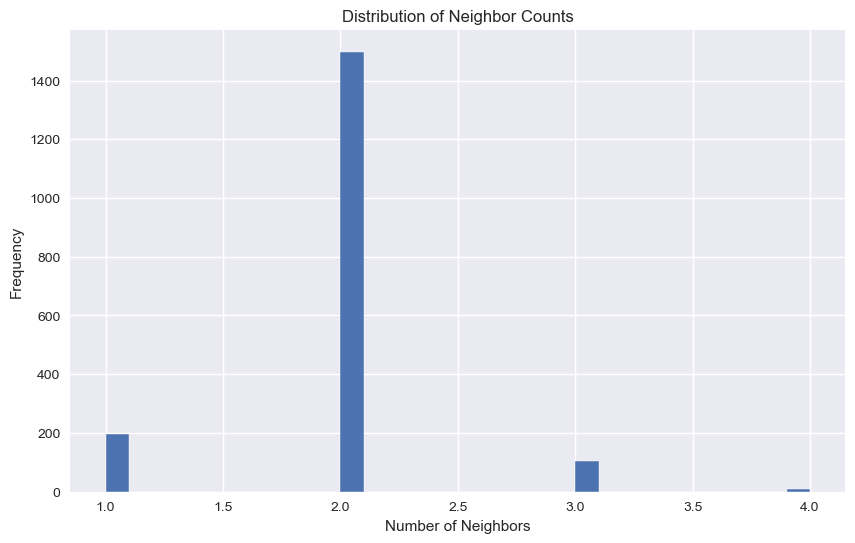

INFO:__main__:Created 100 graphs
INFO:__main__:Split dataset into 80 training and 20 validation graphs
INFO:__main__:
Training set statistics:
INFO:__main__:Average nodes: 18.14
INFO:__main__:Average edges: 70.95
INFO:__main__:Average neighbors: 1.96
INFO:__main__:
Validation set statistics:
INFO:__main__:Average nodes: 17.80
INFO:__main__:Average edges: 70.40
INFO:__main__:Average neighbors: 1.98
INFO:__main__:
Created data loaders with batch size 32
INFO:__main__:Training batches: 3
INFO:__main__:Validation batches: 1
INFO:__main__:
Batch structure:
INFO:__main__:Batch size: 32
INFO:__main__:Total nodes: 589
INFO:__main__:Total edges: 2316
INFO:__main__:Feature dimension: 3



Sample batch properties:
Number of graphs: 32
Number of nodes: 576
Number of edges: 2224


In [12]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
import logging

# [Previous create_graphs_from_df_array and visualization functions remain the same]

def split_dataset(graphs, train_ratio=0.8, random_state=42):
    """Split graphs into training and validation sets"""
    train_idx, val_idx = train_test_split(
        range(len(graphs)),
        train_size=train_ratio,
        random_state=random_state
    )

    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]

    logger.info(f"Split dataset into {len(train_graphs)} training and {len(val_graphs)} validation graphs")

    # Print split statistics
    logger.info("\nTraining set statistics:")
    logger.info(f"Average nodes: {np.mean([g.num_nodes for g in train_graphs]):.2f}")
    logger.info(f"Average edges: {np.mean([g.num_edges for g in train_graphs]):.2f}")
    logger.info(f"Average neighbors: {np.mean([g.neighbor_count.mean().item() for g in train_graphs]):.2f}")

    logger.info("\nValidation set statistics:")
    logger.info(f"Average nodes: {np.mean([g.num_nodes for g in val_graphs]):.2f}")
    logger.info(f"Average edges: {np.mean([g.num_edges for g in val_graphs]):.2f}")
    logger.info(f"Average neighbors: {np.mean([g.neighbor_count.mean().item() for g in val_graphs]):.2f}")

    return train_graphs, val_graphs

def create_data_loaders(train_graphs, val_graphs, batch_size=32):
    """Create PyTorch Geometric data loaders"""
    train_loader = DataLoader(
        train_graphs,
        batch_size=batch_size,
        shuffle=True,
        follow_batch=['x', 'edge_index']  # Track batch assignments
    )

    val_loader = DataLoader(
        val_graphs,
        batch_size=batch_size,
        shuffle=False,
        follow_batch=['x', 'edge_index']  # Track batch assignments
    )

    logger.info(f"\nCreated data loaders with batch size {batch_size}")
    logger.info(f"Training batches: {len(train_loader)}")
    logger.info(f"Validation batches: {len(val_loader)}")

    # Verify first batch
    sample_batch = next(iter(train_loader))
    logger.info("\nBatch structure:")
    logger.info(f"Batch size: {sample_batch.num_graphs}")
    logger.info(f"Total nodes: {sample_batch.num_nodes}")
    logger.info(f"Total edges: {sample_batch.edge_index.size(1)}")
    logger.info(f"Feature dimension: {sample_batch.x.size(1)}")

    return train_loader, val_loader

def process_and_load_data(df_array, batch_size=32, train_ratio=0.8):
    """Complete data processing pipeline"""
    logger.info("Starting data processing pipeline...")

    # Create graphs
    graphs = create_graphs_from_df_array(df_array)
    logger.info(f"Created {len(graphs)} graphs")

    # Validate graphs
    valid_graphs = []
    for i, graph in enumerate(graphs):
        issues = validate_protein_graph(graph)
        if not issues:
            valid_graphs.append(graph)
        else:
            logger.warning(f"Graph {i} has validation issues: {issues}")

    if len(valid_graphs) < len(graphs):
        logger.warning(f"Filtered out {len(graphs) - len(valid_graphs)} invalid graphs")

    # Split dataset
    train_graphs, val_graphs = split_dataset(valid_graphs, train_ratio=train_ratio)

    # Create data loaders
    train_loader, val_loader = create_data_loaders(train_graphs, val_graphs, batch_size=batch_size)

    # Return everything needed for training
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'train_graphs': train_graphs,
        'val_graphs': val_graphs,
        'num_node_features': valid_graphs[0].x.size(1),
        'num_edge_features': 1  # Update if using edge features
    }

# Example usage
if __name__ == "__main__":

    device = get_device()
    logger.info(f"Using device: {device}")
    # Process all data at once
    data = process_and_load_data(
        df_array=autoencoder_input_dfs,
        batch_size=32,
        train_ratio=0.8
    )

    # Access the loaders and model parameters
    train_loader = data['train_loader']
    val_loader = data['val_loader']
    num_node_features = data['num_node_features']

    # Initialize model with correct dimensions
    model = MolecularGVAE(
        node_features=num_node_features,
        hidden_dim=64,
        latent_dim=32
    ).to(device)

    # Verify data loading
    for batch in itertools.islice(train_loader, 1):
        print("\nSample batch properties:")
        print(f"Number of graphs: {batch.num_graphs}")
        print(f"Number of nodes: {batch.x.size(0)}")
        print(f"Number of edges: {batch.edge_index.size(1)}")
        break

Creating graphs:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:__main__:Successfully created 100 graphs out of 100 input structures
INFO:__main__:Average nodes per graph: 18.07
INFO:__main__:Average edges per graph: 70.84
INFO:__main__:Average neighbors per node: 1.96
INFO:__main__:
Neighbor count statistics:
INFO:__main__:Min neighbors: 1
INFO:__main__:Max neighbors: 4
INFO:__main__:Mean neighbors: 1.96
INFO:__main__:Median neighbors: 2


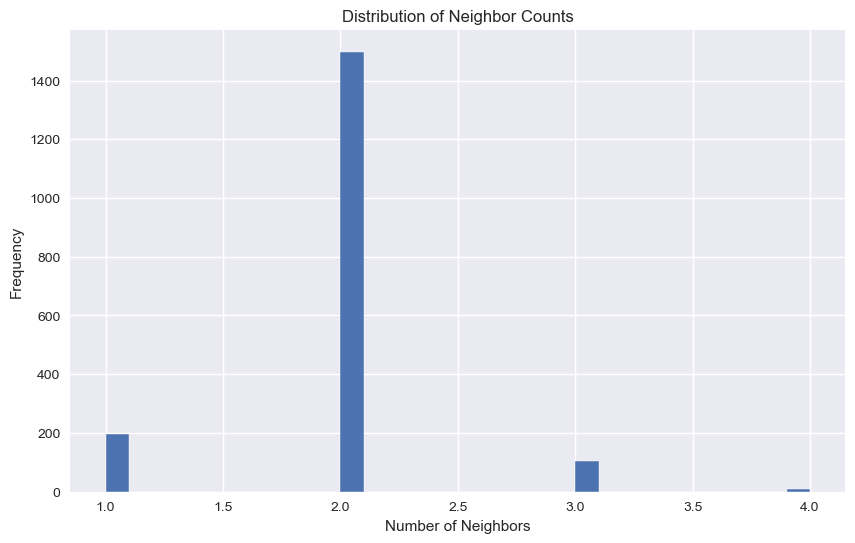

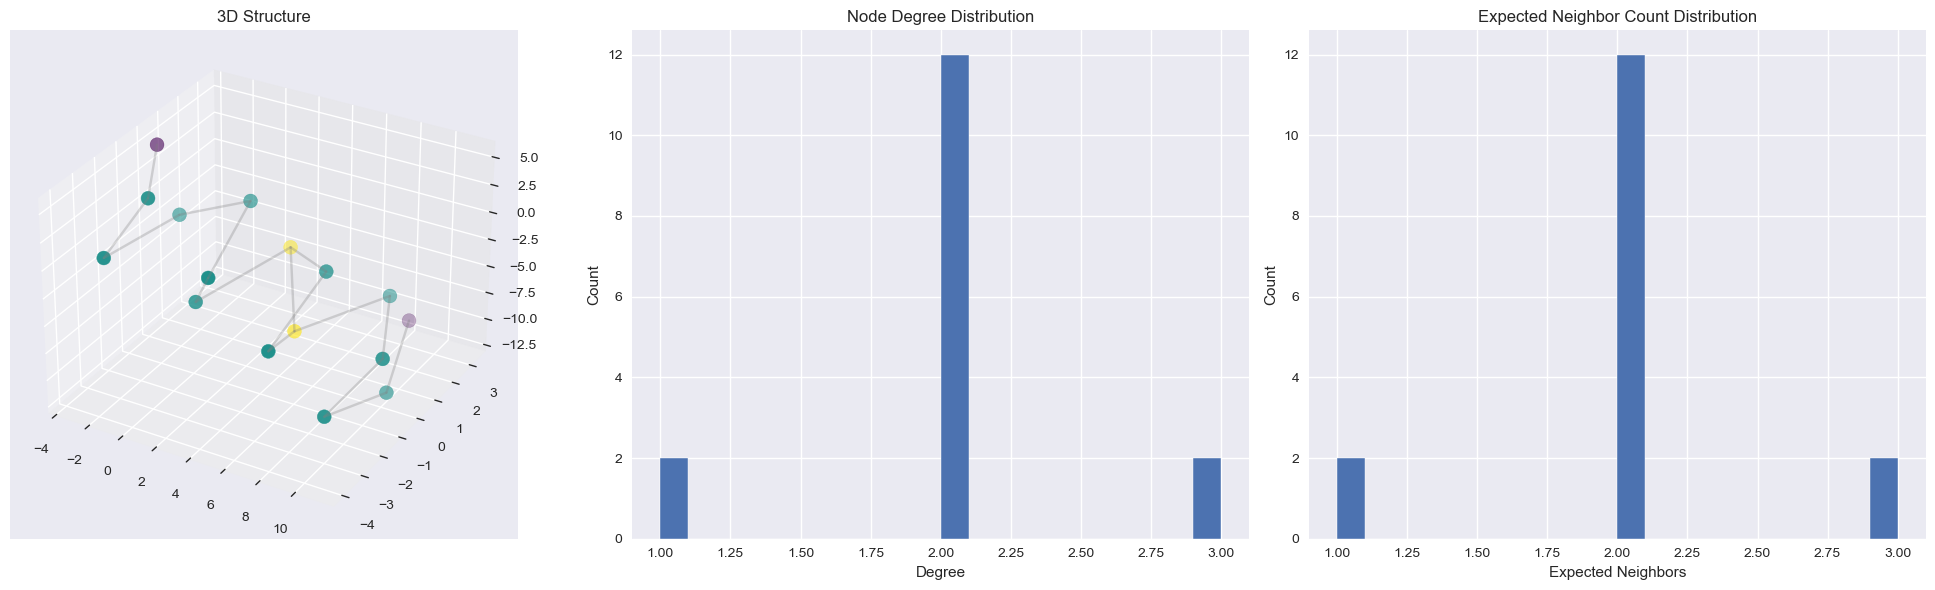


Graph 0 Statistics:
Number of nodes: 16
Number of edges: 64
Average neighbor count: 2.00
Average degree: 2.00

No validation issues found.


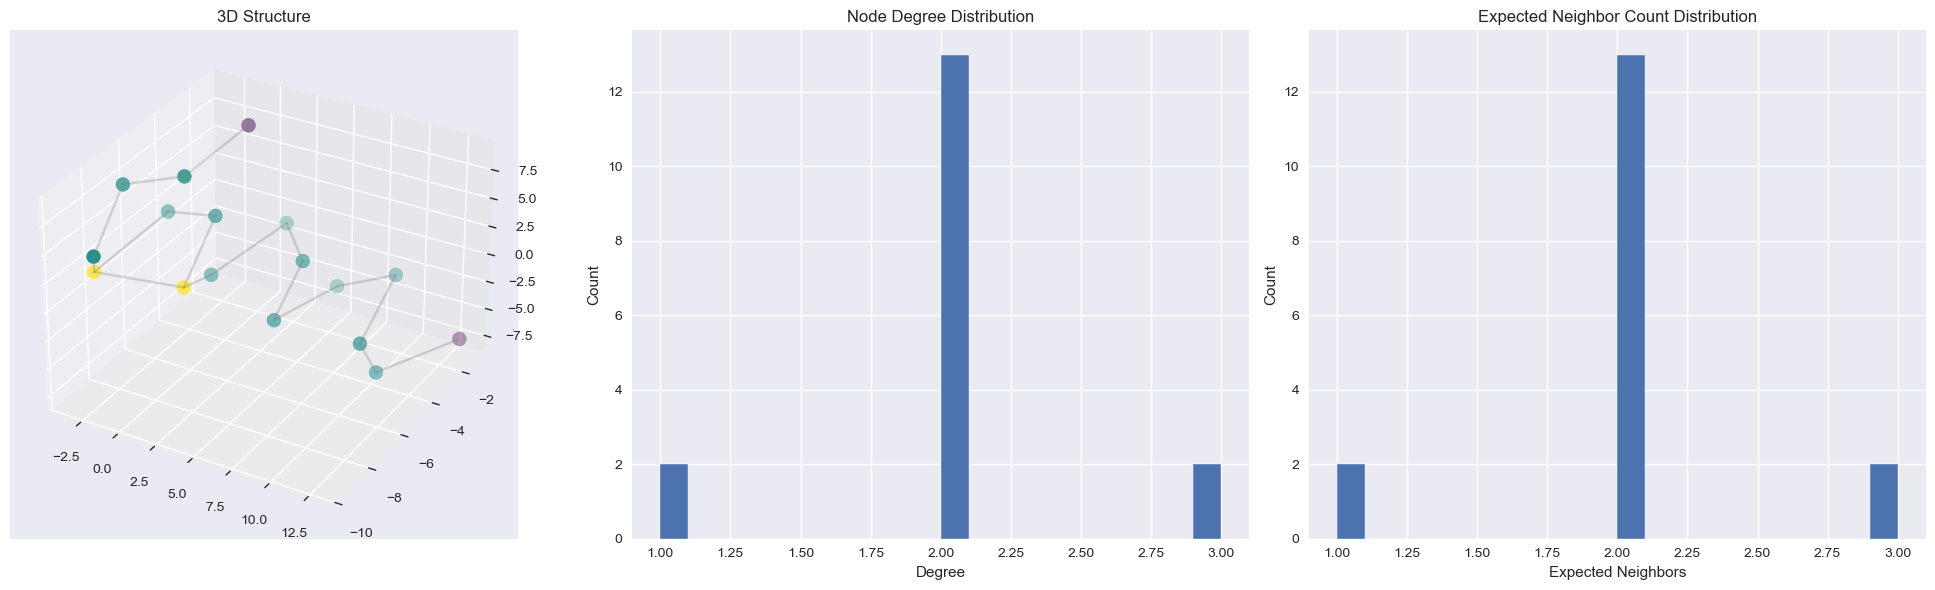


Graph 1 Statistics:
Number of nodes: 17
Number of edges: 68
Average neighbor count: 2.00
Average degree: 2.00

No validation issues found.


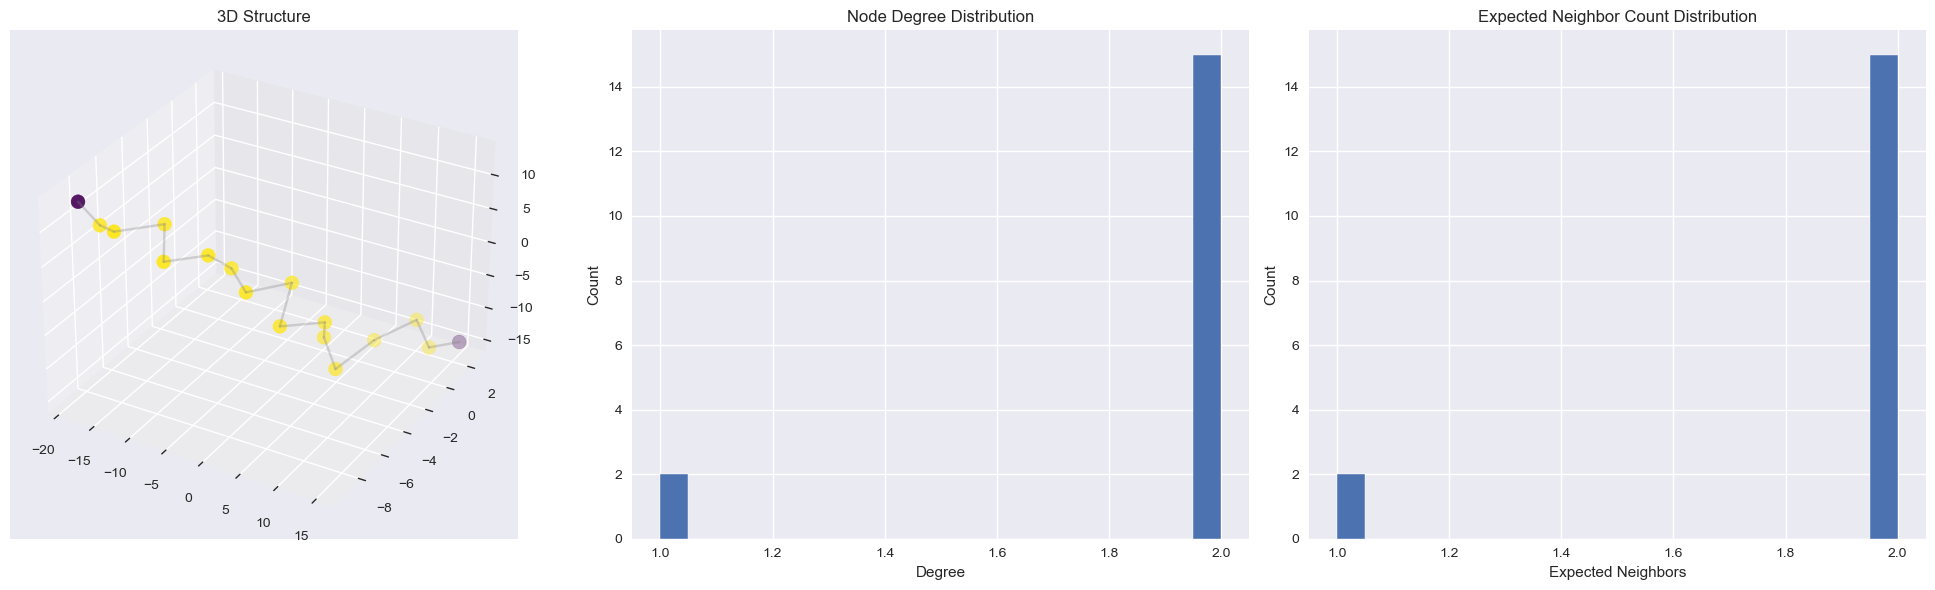

INFO:__main__:Split dataset into 80 training and 20 validation graphs
INFO:__main__:
Training set statistics:
INFO:__main__:Average nodes: 18.14
INFO:__main__:Average edges: 70.95
INFO:__main__:Average neighbors: 1.96
INFO:__main__:
Validation set statistics:
INFO:__main__:Average nodes: 17.80
INFO:__main__:Average edges: 70.40
INFO:__main__:Average neighbors: 1.98
INFO:__main__:
Created data loaders with batch size 32
INFO:__main__:Training batches: 3
INFO:__main__:Validation batches: 1
INFO:__main__:
Batch structure:
INFO:__main__:Batch size: 32
INFO:__main__:Total nodes: 587
INFO:__main__:Total edges: 2300
INFO:__main__:Feature dimension: 3



Graph 2 Statistics:
Number of nodes: 17
Number of edges: 64
Average neighbor count: 1.88
Average degree: 1.88

No validation issues found.


In [13]:
# Create graphs with validation
graphs = create_graphs_from_df_array(autoencoder_input_dfs)

# Validate first few graphs
for i in range(min(3, len(graphs))):
    visualize_protein_graph(graphs[i], i)

# If graphs look good, proceed with splitting and loader creation
train_graphs, val_graphs = split_dataset(graphs)
train_loader, val_loader = create_data_loaders(train_graphs, val_graphs)

INFO:__main__:MPS (M1/M2) device found but using CPU for some operations due to compatibility
INFO:__main__:Using device: cpu


Epoch 1/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 1/100
INFO:__main__:Train Loss: 5483.4049
INFO:__main__:Val Loss: 5157.0020


Epoch 2/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 2/100
INFO:__main__:Train Loss: 5462.8434
INFO:__main__:Val Loss: 5084.6997


Epoch 3/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 3/100
INFO:__main__:Train Loss: 5388.2884
INFO:__main__:Val Loss: 5010.4634


Epoch 4/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 4/100
INFO:__main__:Train Loss: 5318.0915
INFO:__main__:Val Loss: 4978.8774


Epoch 5/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 4954.5410


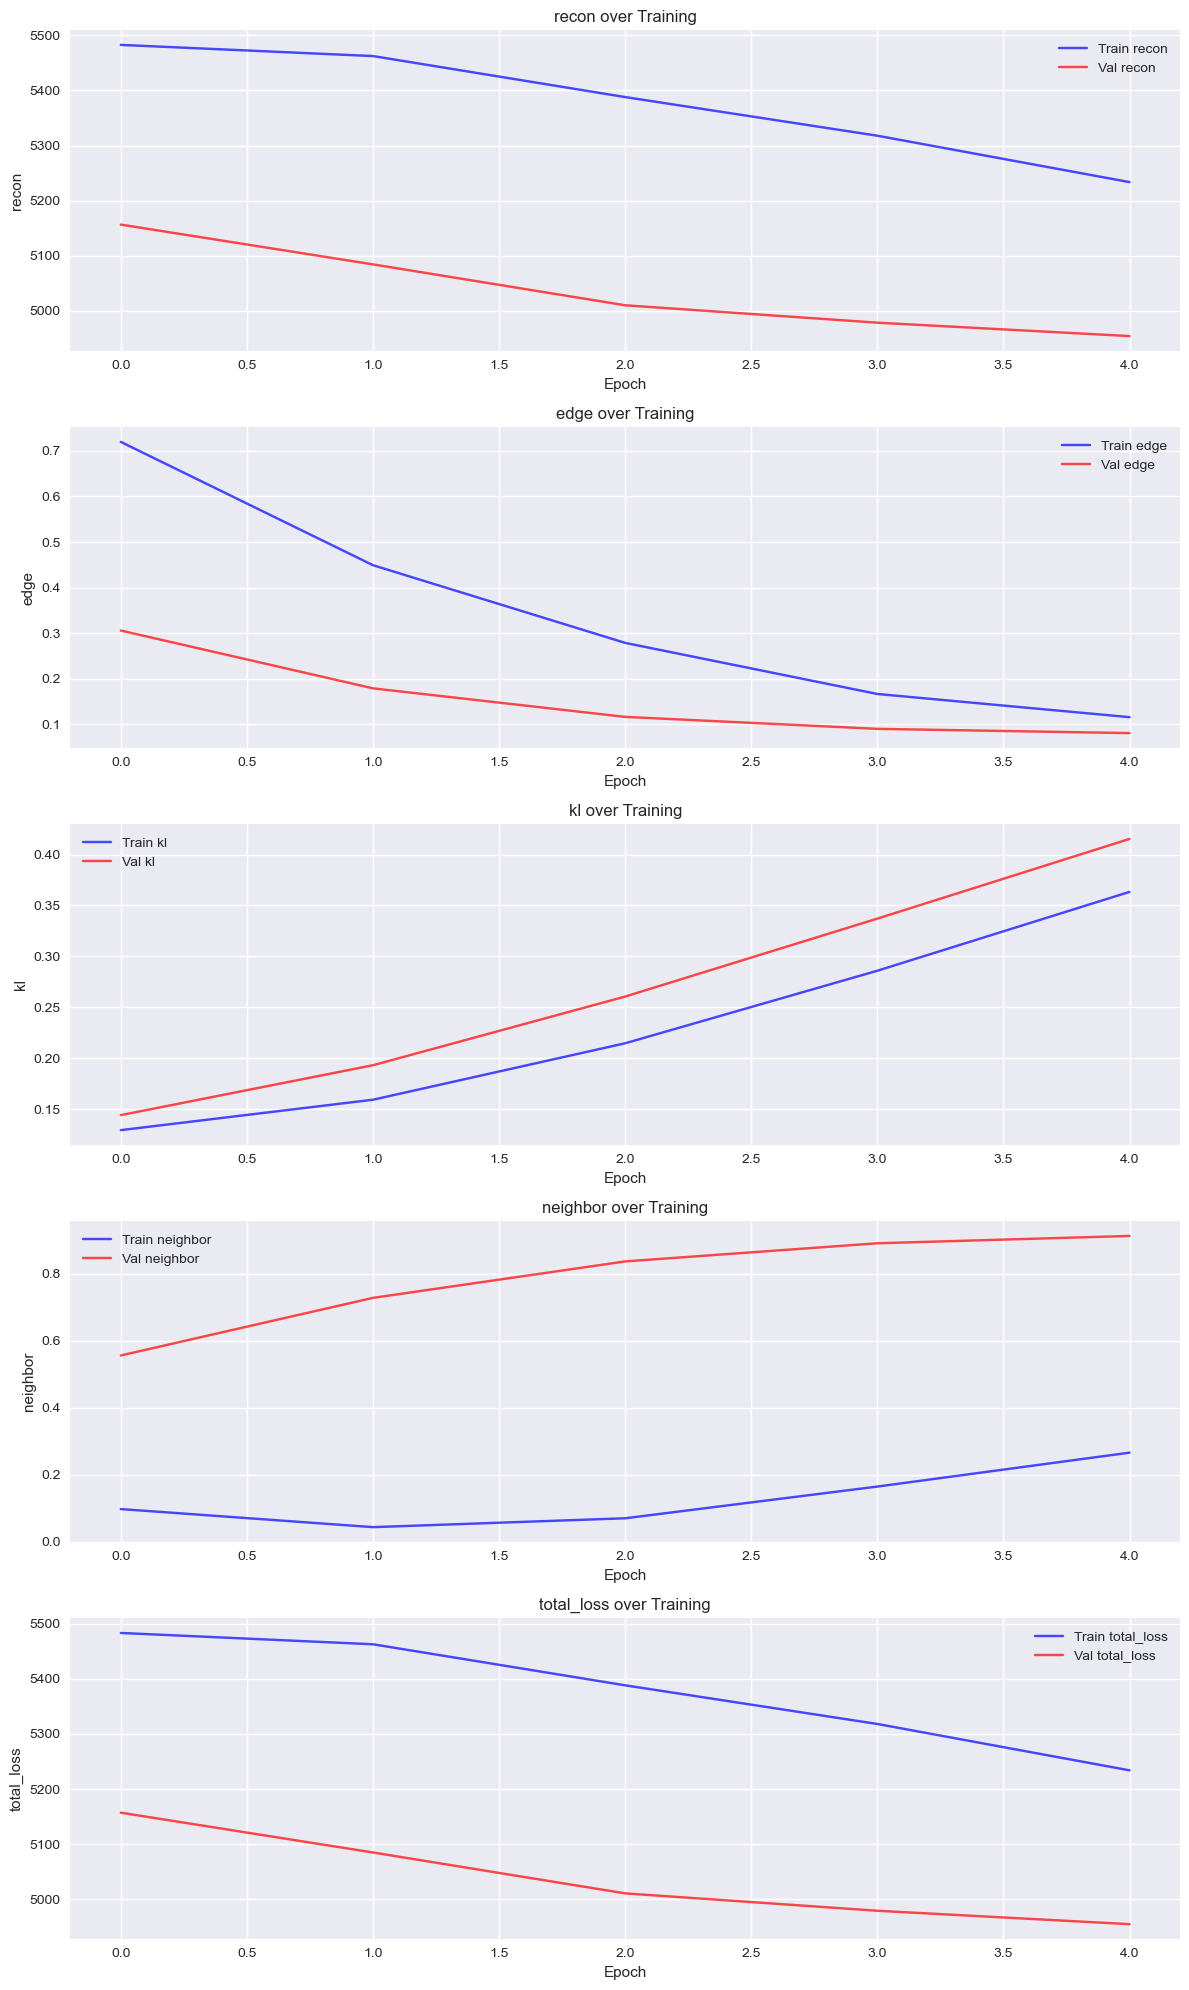

INFO:__main__:
Epoch 5/100
INFO:__main__:Train Loss: 5233.8913
INFO:__main__:Val Loss: 4954.5410


Epoch 6/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 6/100
INFO:__main__:Train Loss: 5211.4661
INFO:__main__:Val Loss: 4933.1592


Epoch 7/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 7/100
INFO:__main__:Train Loss: 5211.9998
INFO:__main__:Val Loss: 4912.8491


Epoch 8/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 8/100
INFO:__main__:Train Loss: 5146.6035
INFO:__main__:Val Loss: 4891.0054


Epoch 9/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 9/100
INFO:__main__:Train Loss: 5127.0465
INFO:__main__:Val Loss: 4868.0376


Epoch 10/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 4843.3892


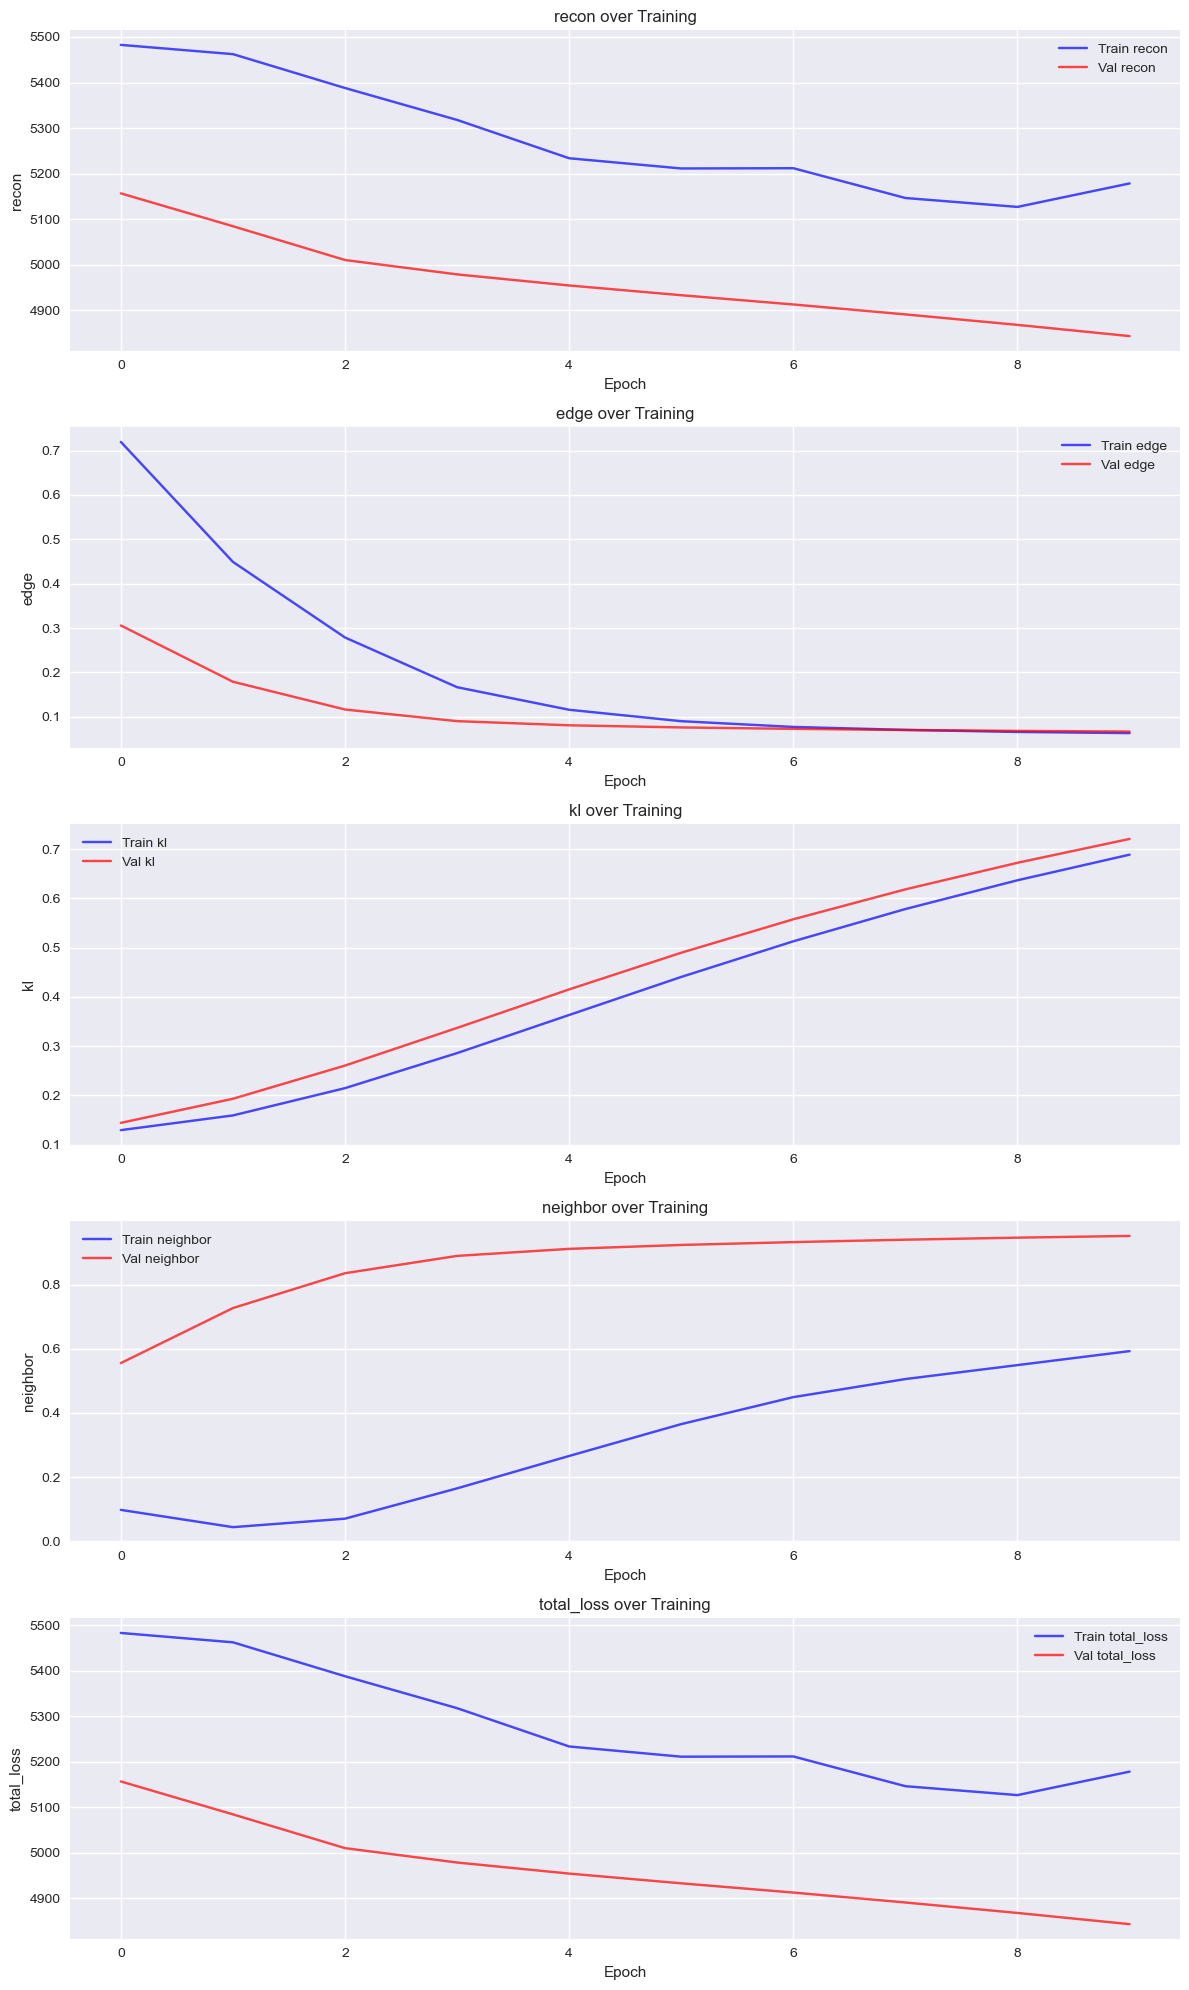

INFO:__main__:
Epoch 10/100
INFO:__main__:Train Loss: 5178.6312
INFO:__main__:Val Loss: 4843.3892


Epoch 11/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 11/100
INFO:__main__:Train Loss: 5053.3407
INFO:__main__:Val Loss: 4820.8354


Epoch 12/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 12/100
INFO:__main__:Train Loss: 5101.6042
INFO:__main__:Val Loss: 4799.2241


Epoch 13/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 13/100
INFO:__main__:Train Loss: 5019.7712
INFO:__main__:Val Loss: 4778.1807


Epoch 14/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 14/100
INFO:__main__:Train Loss: 5057.5635
INFO:__main__:Val Loss: 4758.0146


Epoch 15/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 4738.0703


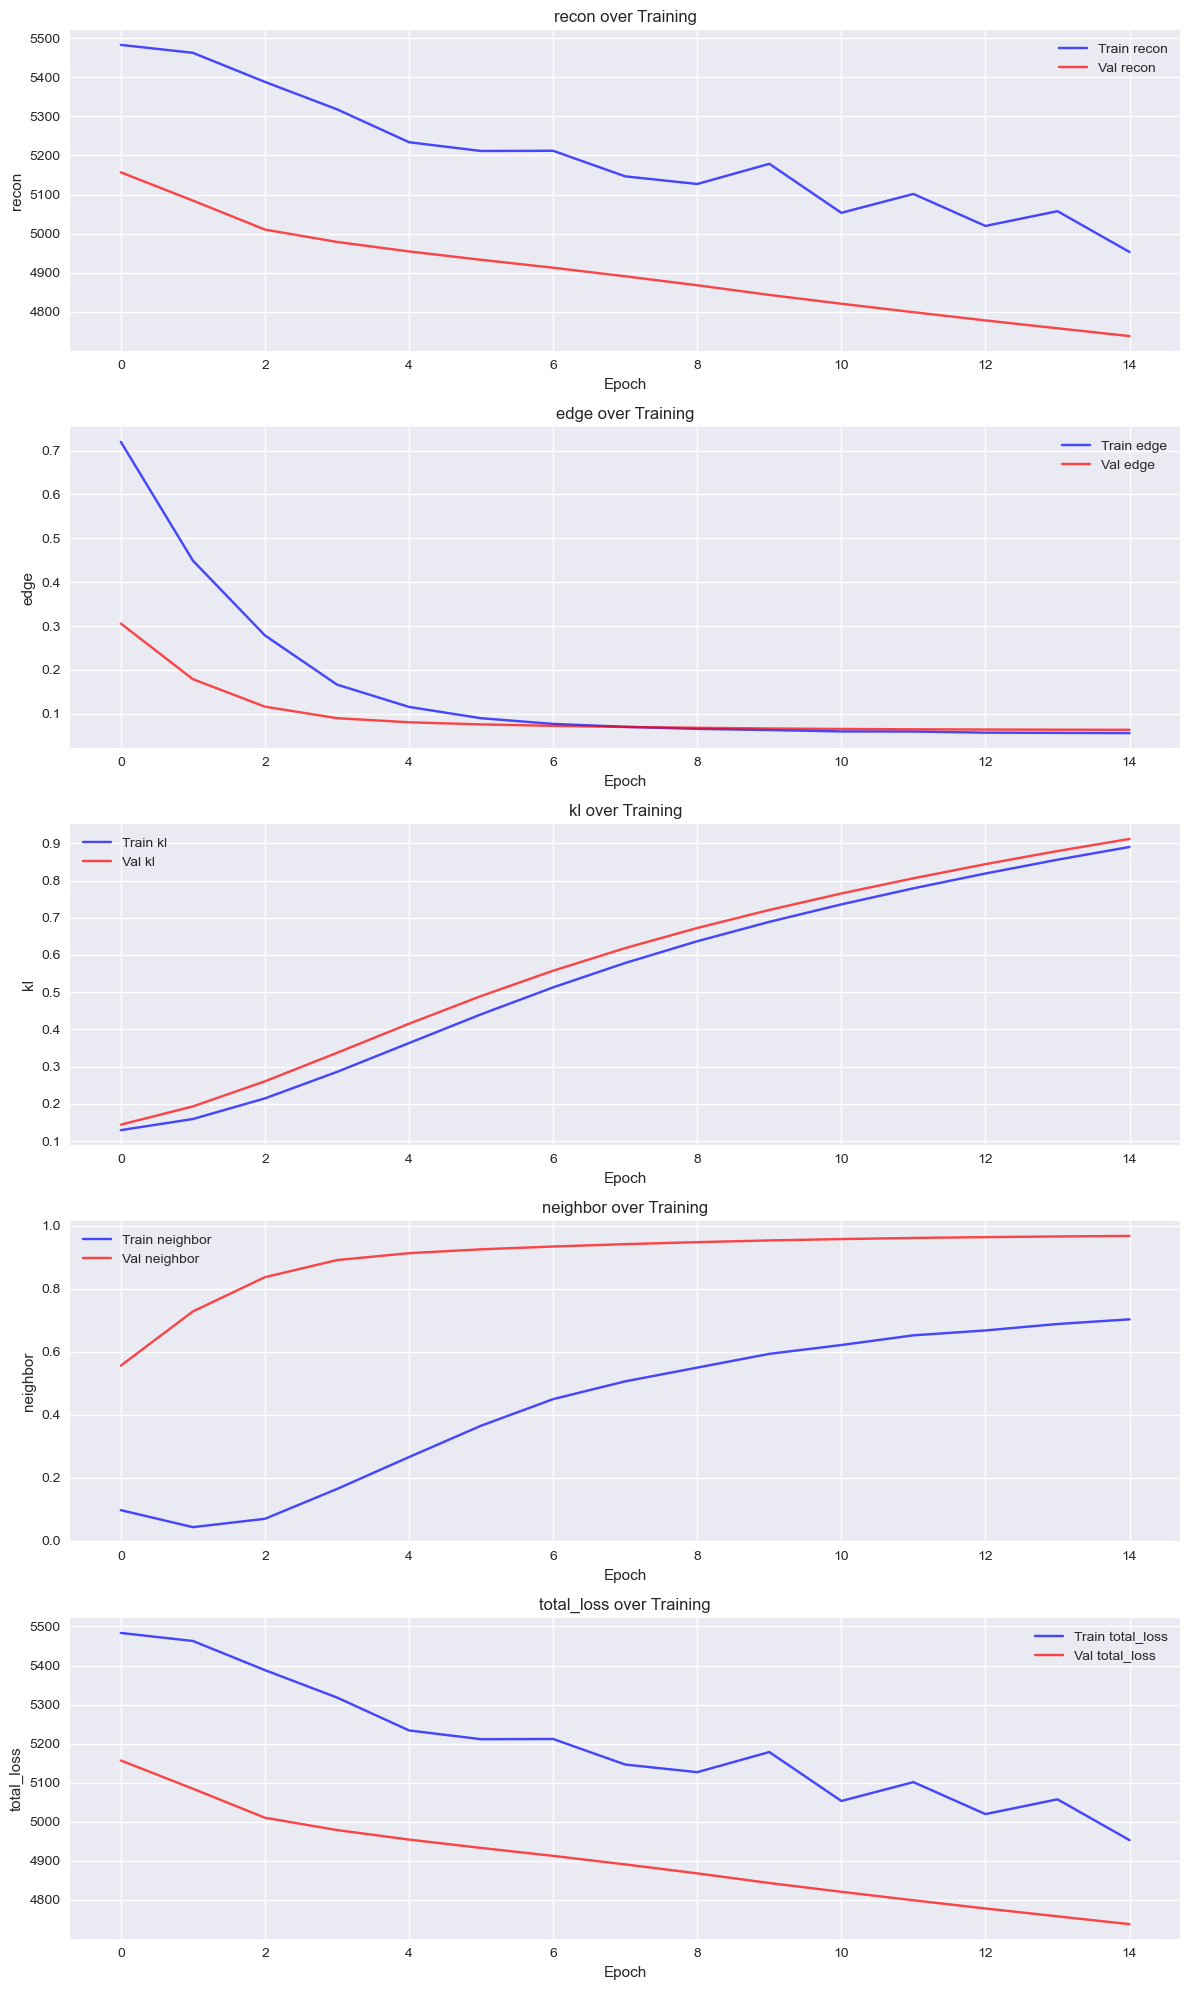

INFO:__main__:
Epoch 15/100
INFO:__main__:Train Loss: 4953.0908
INFO:__main__:Val Loss: 4738.0703


Epoch 16/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 16/100
INFO:__main__:Train Loss: 4960.0150
INFO:__main__:Val Loss: 4718.0103


Epoch 17/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 17/100
INFO:__main__:Train Loss: 4891.2930
INFO:__main__:Val Loss: 4697.7856


Epoch 18/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 18/100
INFO:__main__:Train Loss: 4956.0464
INFO:__main__:Val Loss: 4677.4897


Epoch 19/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 19/100
INFO:__main__:Train Loss: 4887.6491
INFO:__main__:Val Loss: 4657.0850


Epoch 20/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 4636.4751


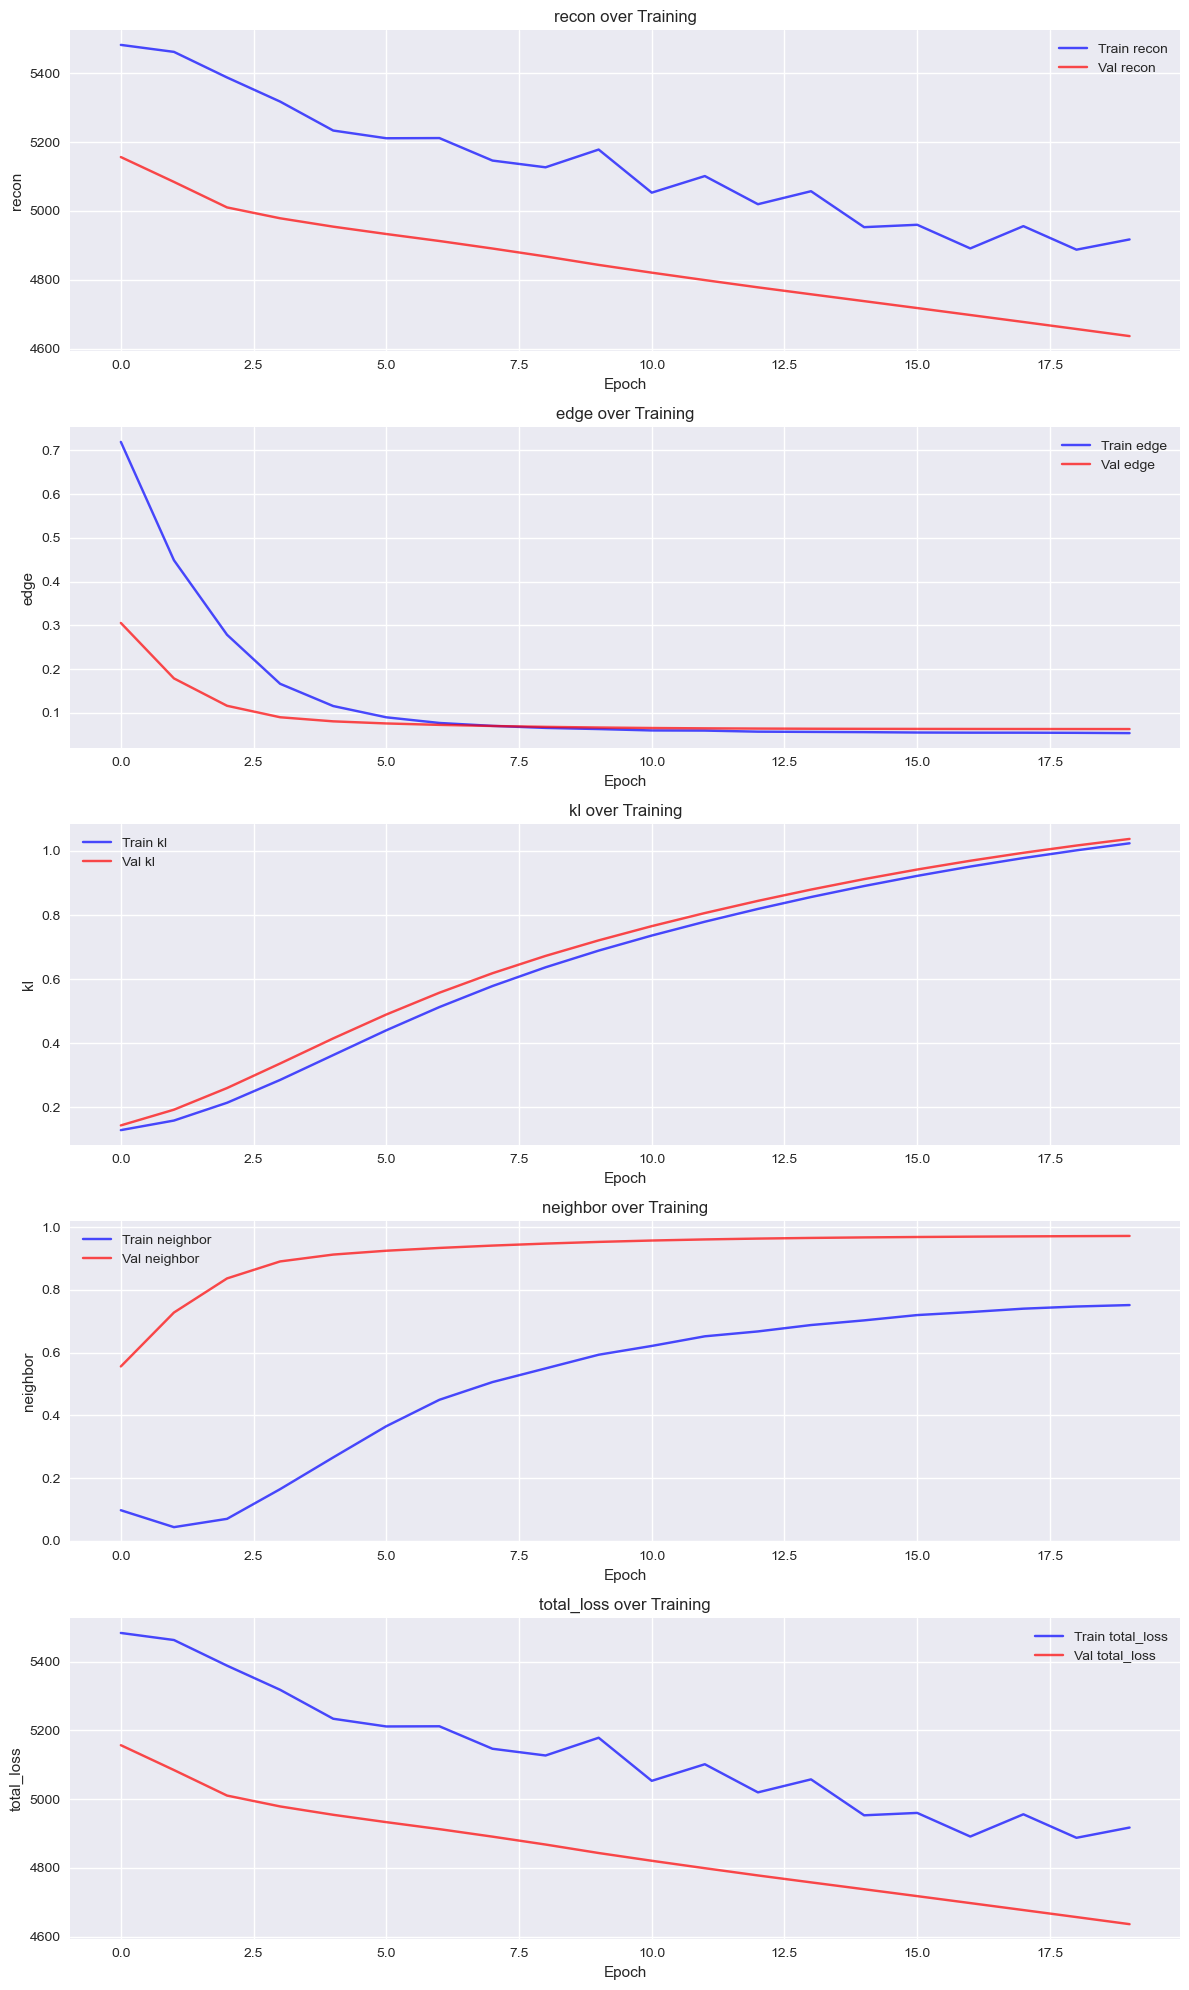

INFO:__main__:
Epoch 20/100
INFO:__main__:Train Loss: 4917.4256
INFO:__main__:Val Loss: 4636.4751


Epoch 21/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 21/100
INFO:__main__:Train Loss: 4890.9933
INFO:__main__:Val Loss: 4615.6250


Epoch 22/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 22/100
INFO:__main__:Train Loss: 4915.1584
INFO:__main__:Val Loss: 4594.5728


Epoch 23/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 23/100
INFO:__main__:Train Loss: 4770.3228
INFO:__main__:Val Loss: 4573.3804


Epoch 24/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 24/100
INFO:__main__:Train Loss: 4758.3185
INFO:__main__:Val Loss: 4552.0635


Epoch 25/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 4530.5825


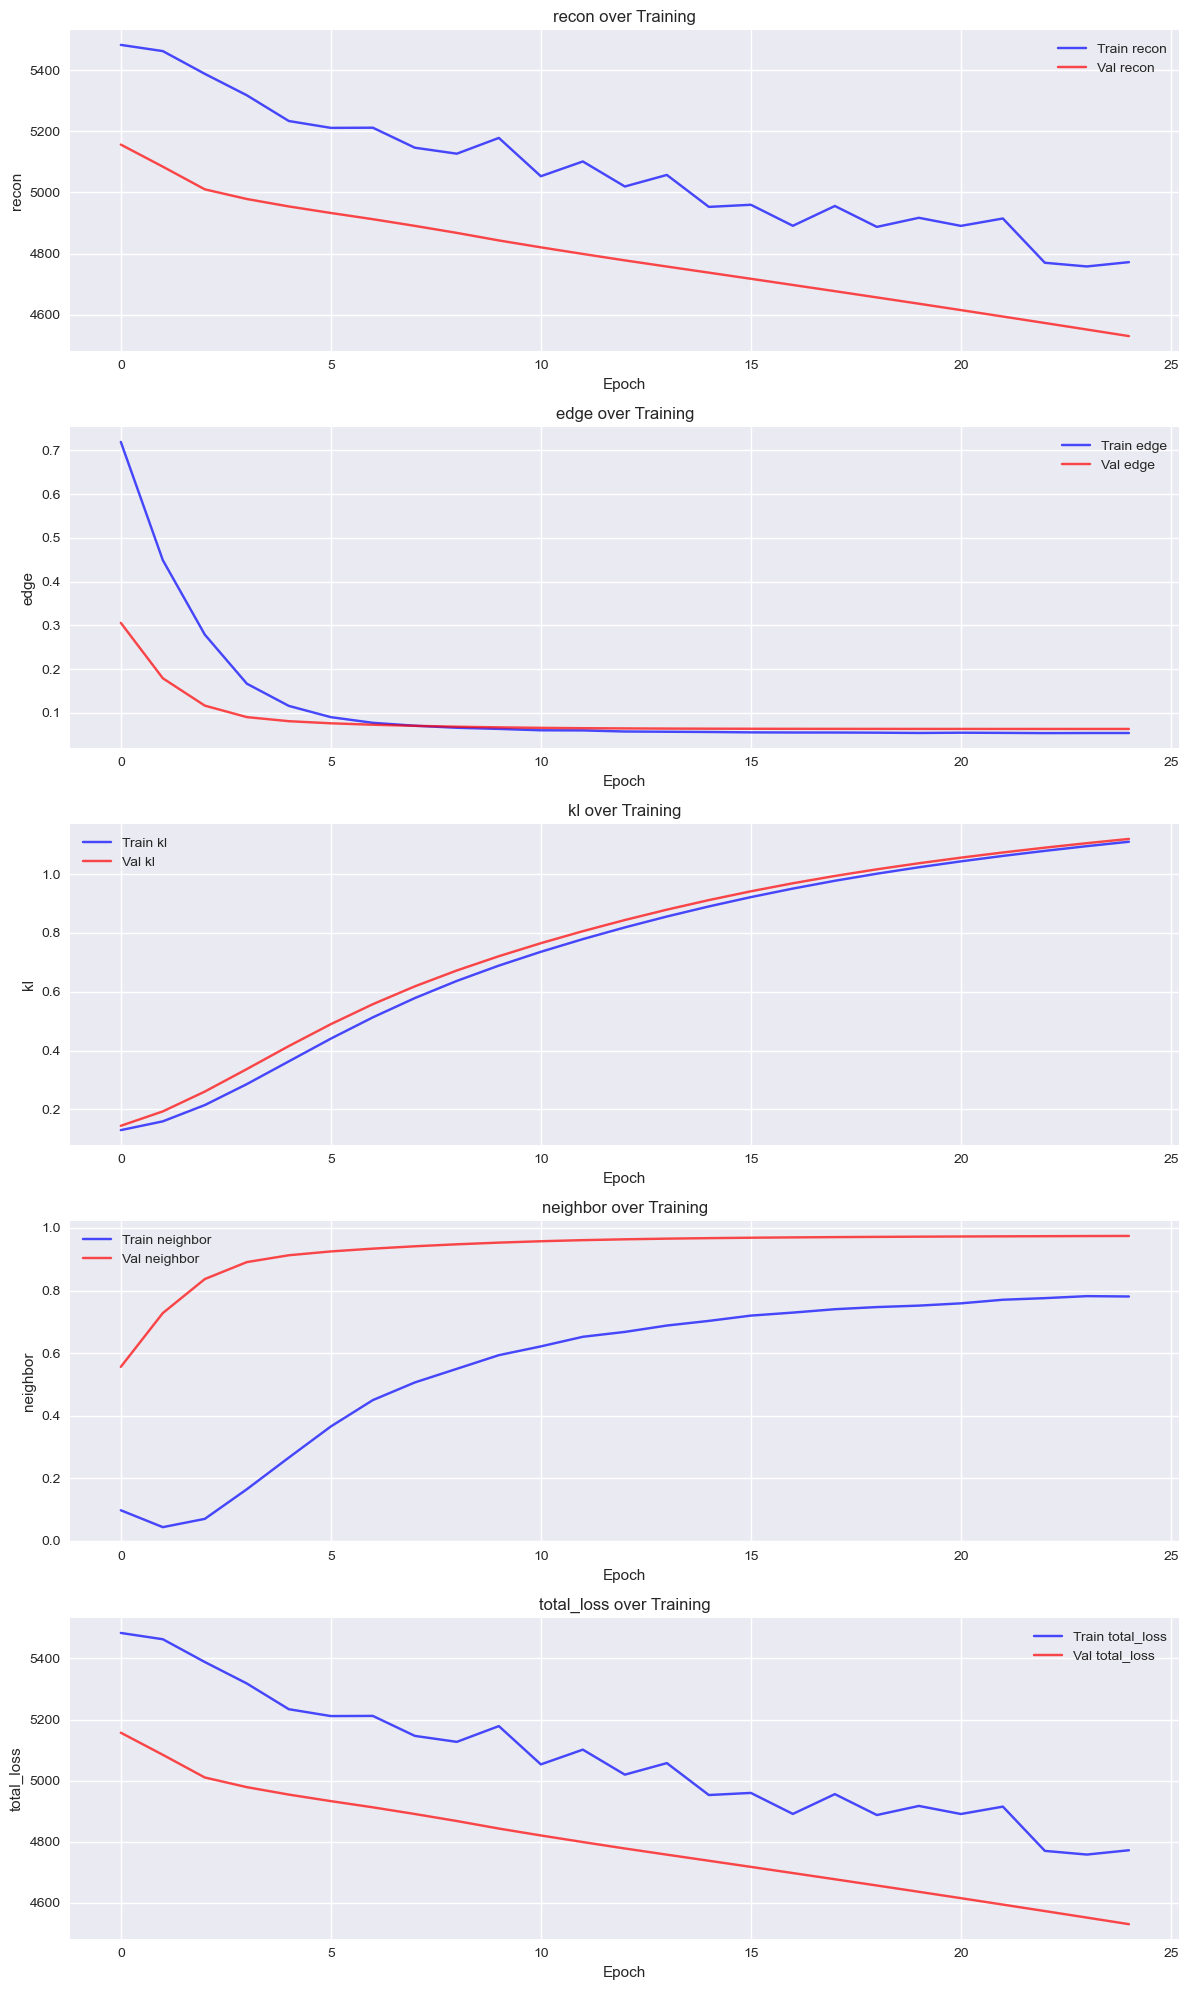

INFO:__main__:
Epoch 25/100
INFO:__main__:Train Loss: 4772.3849
INFO:__main__:Val Loss: 4530.5825


Epoch 26/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 26/100
INFO:__main__:Train Loss: 4790.4705
INFO:__main__:Val Loss: 4508.9067


Epoch 27/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 27/100
INFO:__main__:Train Loss: 4722.3039
INFO:__main__:Val Loss: 4487.0503


Epoch 28/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 28/100
INFO:__main__:Train Loss: 4681.3714
INFO:__main__:Val Loss: 4465.0264


Epoch 29/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 29/100
INFO:__main__:Train Loss: 4707.1911
INFO:__main__:Val Loss: 4442.8281


Epoch 30/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 4420.4448


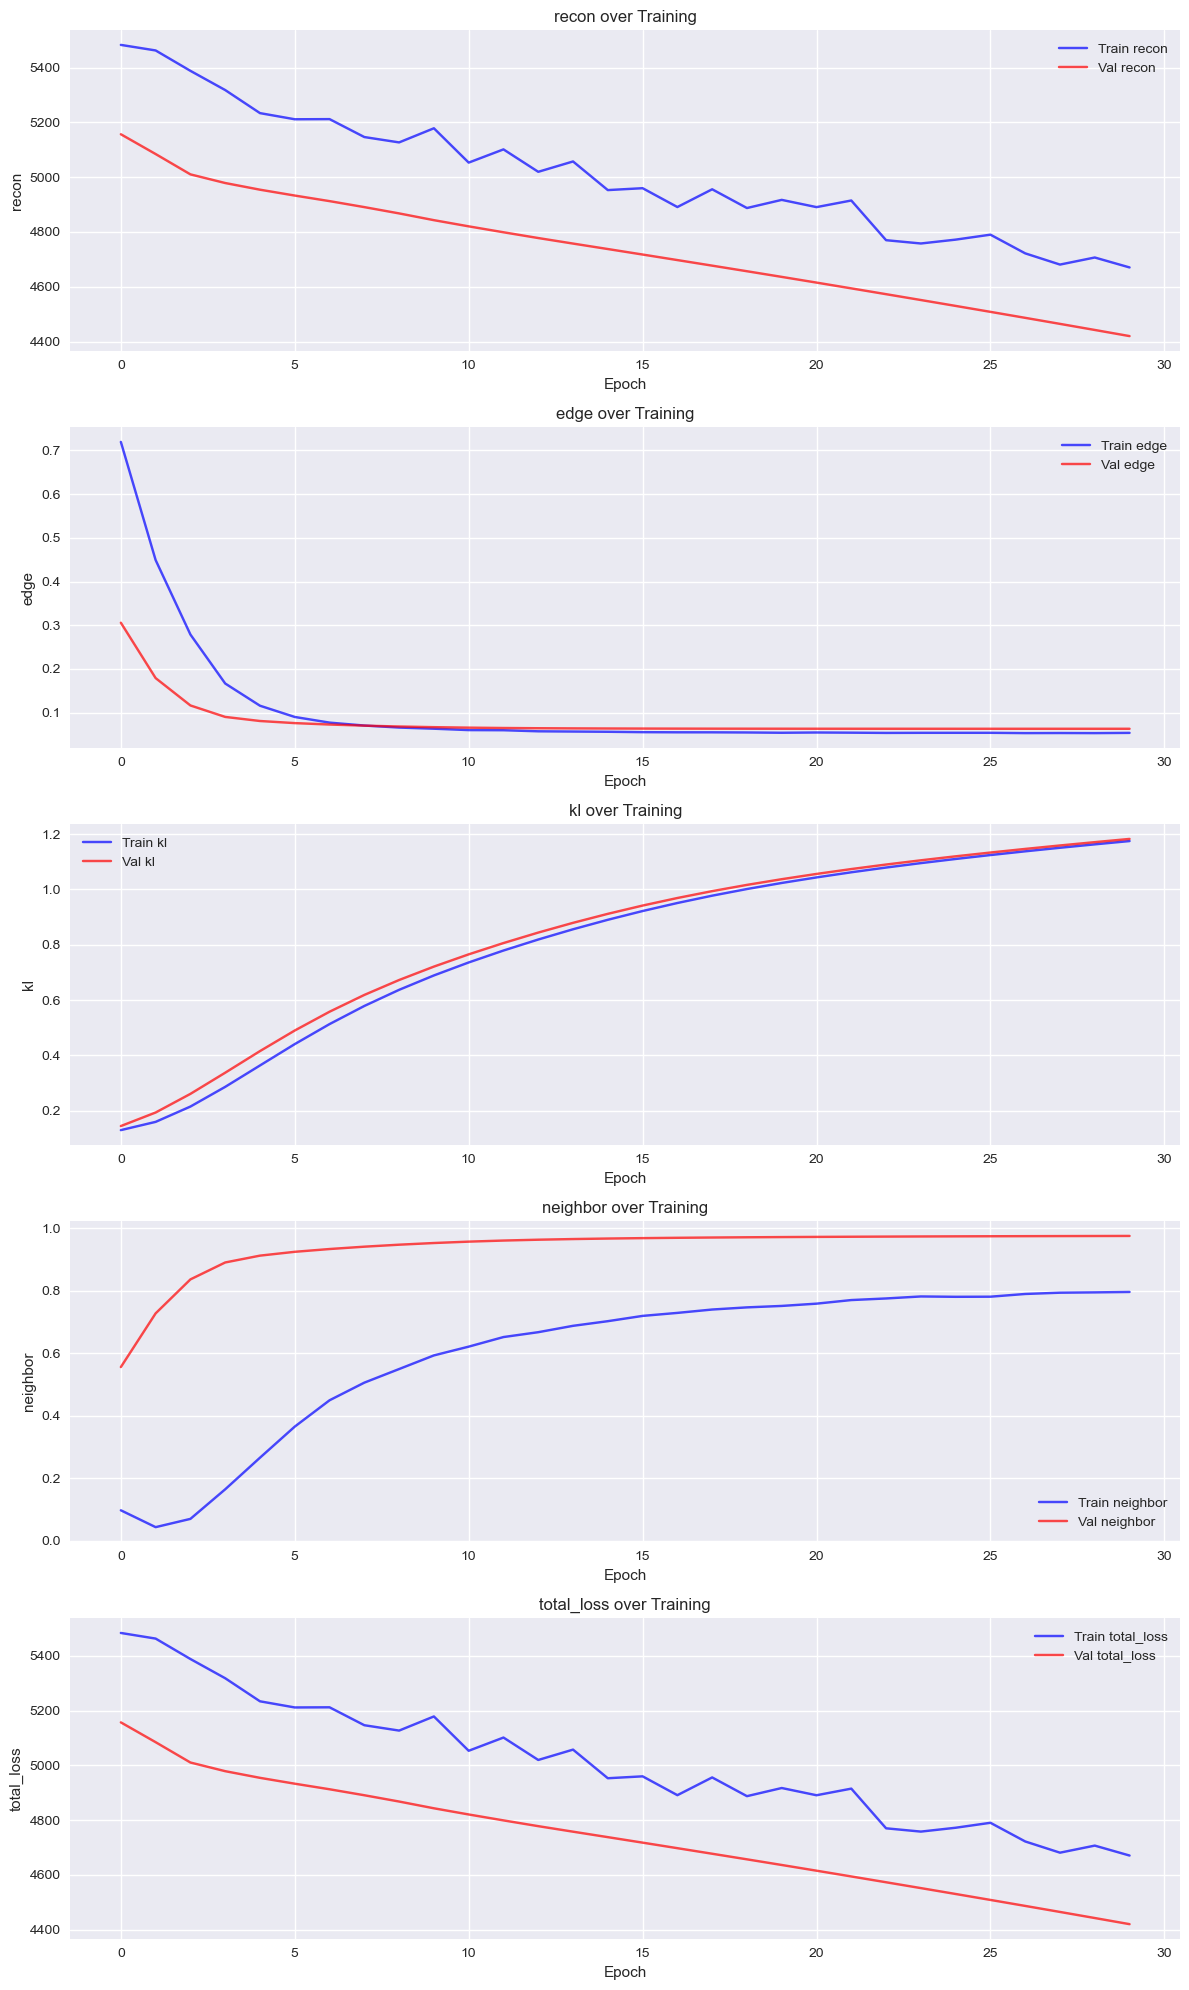

INFO:__main__:
Epoch 30/100
INFO:__main__:Train Loss: 4670.9178
INFO:__main__:Val Loss: 4420.4448


Epoch 31/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 31/100
INFO:__main__:Train Loss: 4629.6668
INFO:__main__:Val Loss: 4397.8809


Epoch 32/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 32/100
INFO:__main__:Train Loss: 4614.1289
INFO:__main__:Val Loss: 4375.1426


Epoch 33/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 33/100
INFO:__main__:Train Loss: 4605.4443
INFO:__main__:Val Loss: 4352.2378


Epoch 34/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 34/100
INFO:__main__:Train Loss: 4589.9670
INFO:__main__:Val Loss: 4329.1660


Epoch 35/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 4305.9238


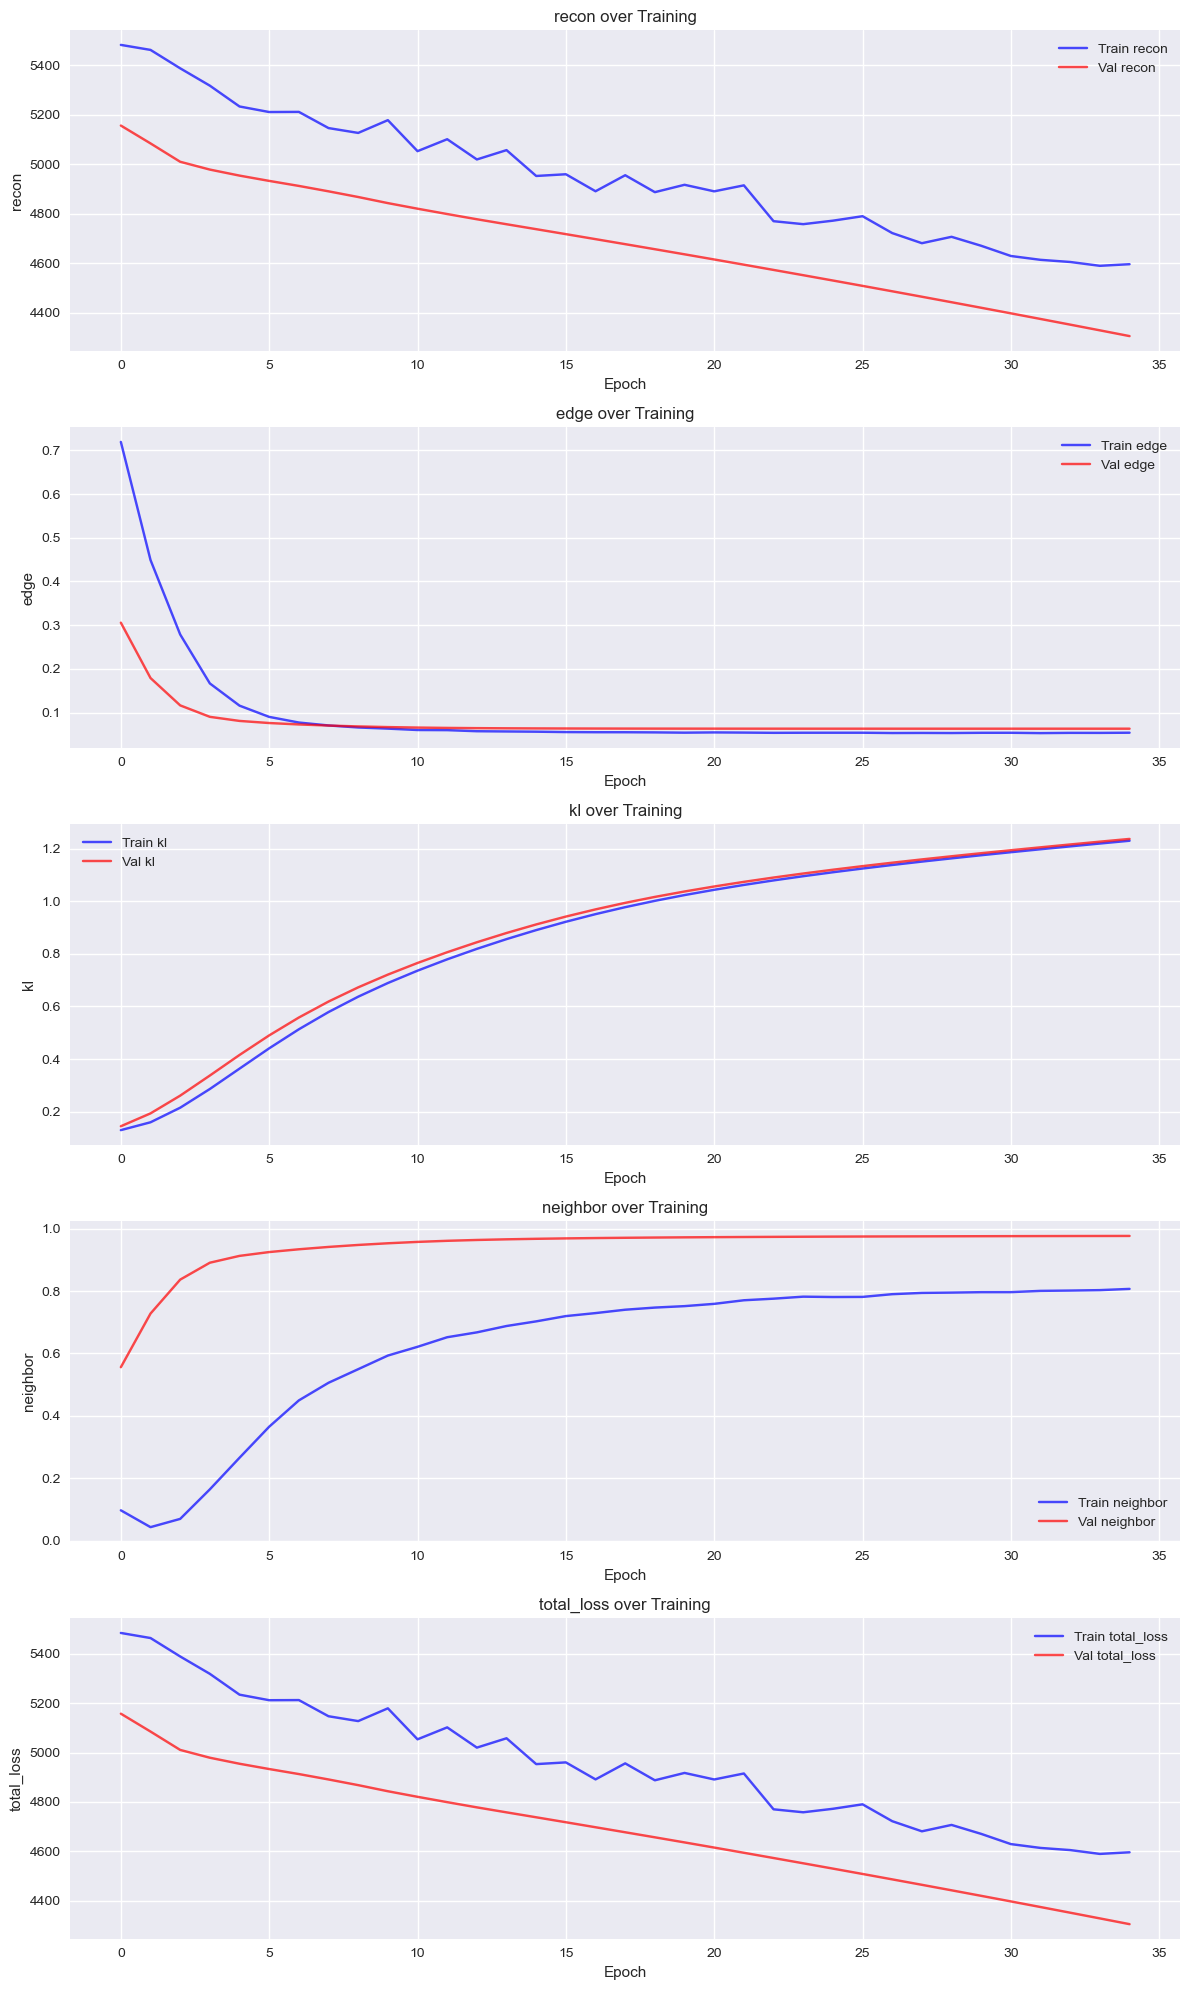

INFO:__main__:
Epoch 35/100
INFO:__main__:Train Loss: 4596.5550
INFO:__main__:Val Loss: 4305.9238


Epoch 36/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 36/100
INFO:__main__:Train Loss: 4540.0928
INFO:__main__:Val Loss: 4282.5166


Epoch 37/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 37/100
INFO:__main__:Train Loss: 4554.7329
INFO:__main__:Val Loss: 4258.9463


Epoch 38/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 38/100
INFO:__main__:Train Loss: 4454.1512
INFO:__main__:Val Loss: 4235.2104


Epoch 39/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 39/100
INFO:__main__:Train Loss: 4474.8127
INFO:__main__:Val Loss: 4211.3159


Epoch 40/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 4187.2612


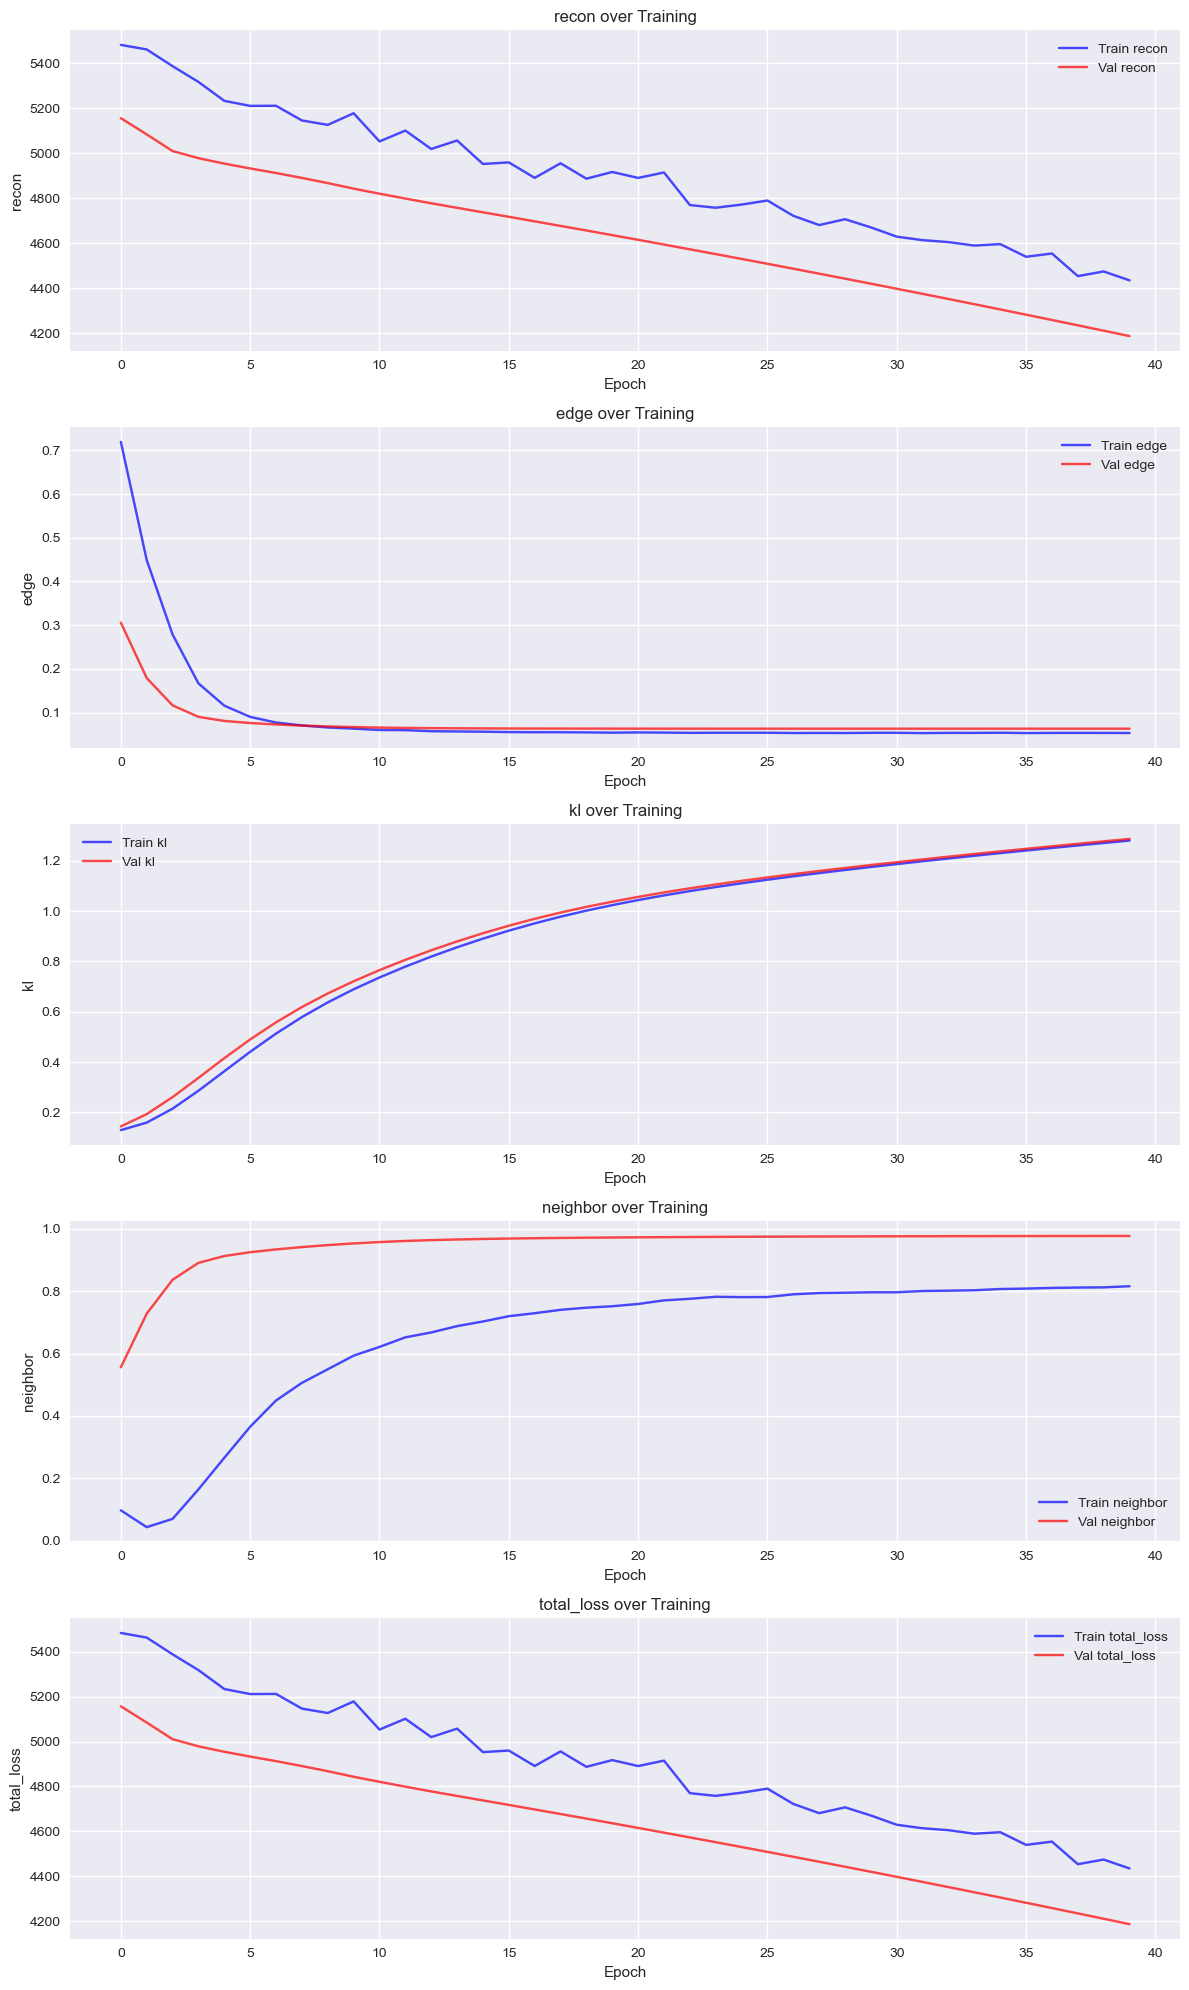

INFO:__main__:
Epoch 40/100
INFO:__main__:Train Loss: 4435.1517
INFO:__main__:Val Loss: 4187.2612


Epoch 41/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 41/100
INFO:__main__:Train Loss: 4349.0775
INFO:__main__:Val Loss: 4163.0537


Epoch 42/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 42/100
INFO:__main__:Train Loss: 4418.4447
INFO:__main__:Val Loss: 4138.6938


Epoch 43/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 43/100
INFO:__main__:Train Loss: 4353.7549
INFO:__main__:Val Loss: 4114.1812


Epoch 44/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 44/100
INFO:__main__:Train Loss: 4336.1203
INFO:__main__:Val Loss: 4089.5190


Epoch 45/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 4064.7134


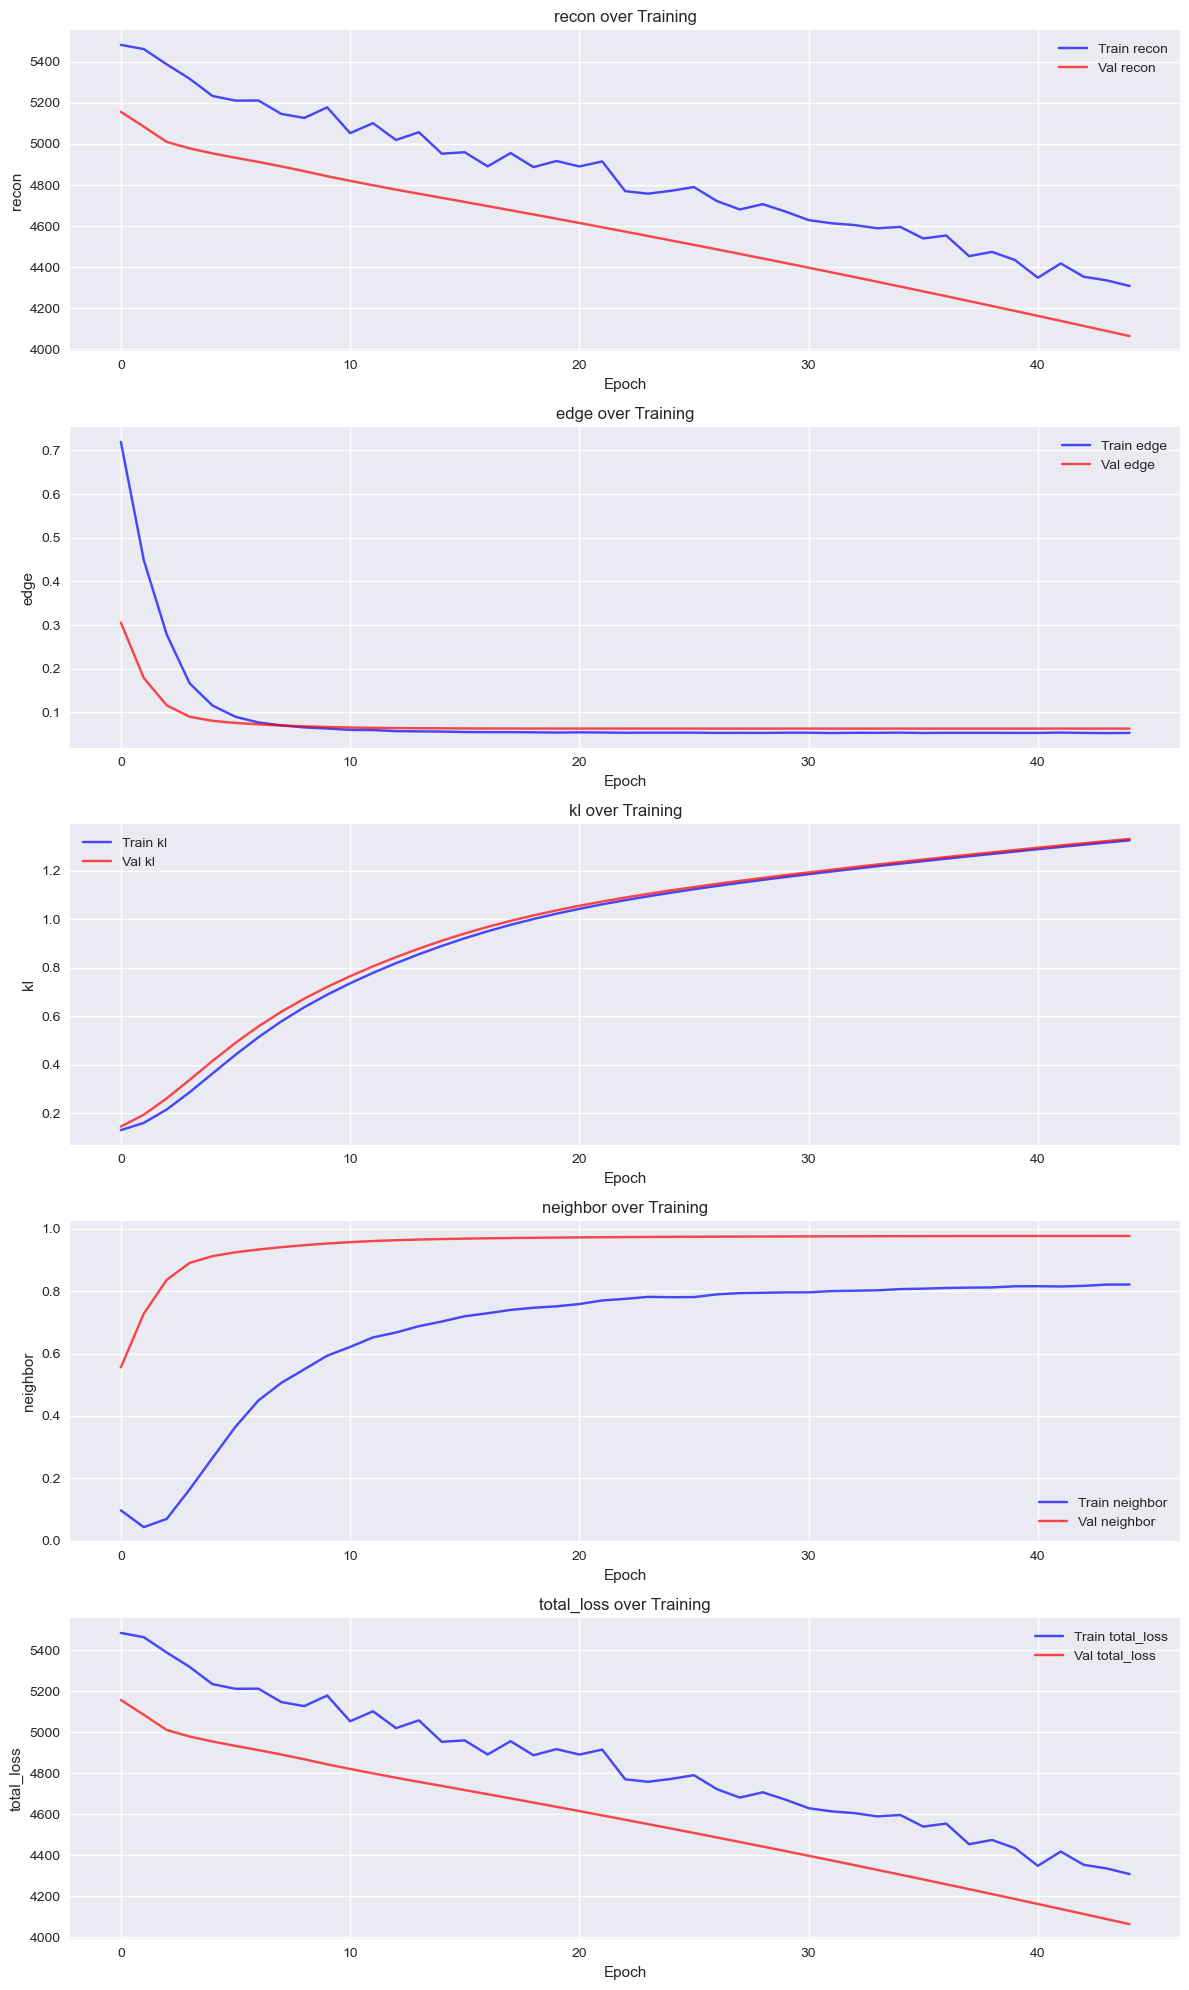

INFO:__main__:
Epoch 45/100
INFO:__main__:Train Loss: 4308.6781
INFO:__main__:Val Loss: 4064.7134


Epoch 46/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 46/100
INFO:__main__:Train Loss: 4314.4377
INFO:__main__:Val Loss: 4039.7600


Epoch 47/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 47/100
INFO:__main__:Train Loss: 4206.6775
INFO:__main__:Val Loss: 4014.6604


Epoch 48/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 48/100
INFO:__main__:Train Loss: 4200.7786
INFO:__main__:Val Loss: 3989.4189


Epoch 49/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 49/100
INFO:__main__:Train Loss: 4158.0299
INFO:__main__:Val Loss: 3964.0403


Epoch 50/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 3938.5232


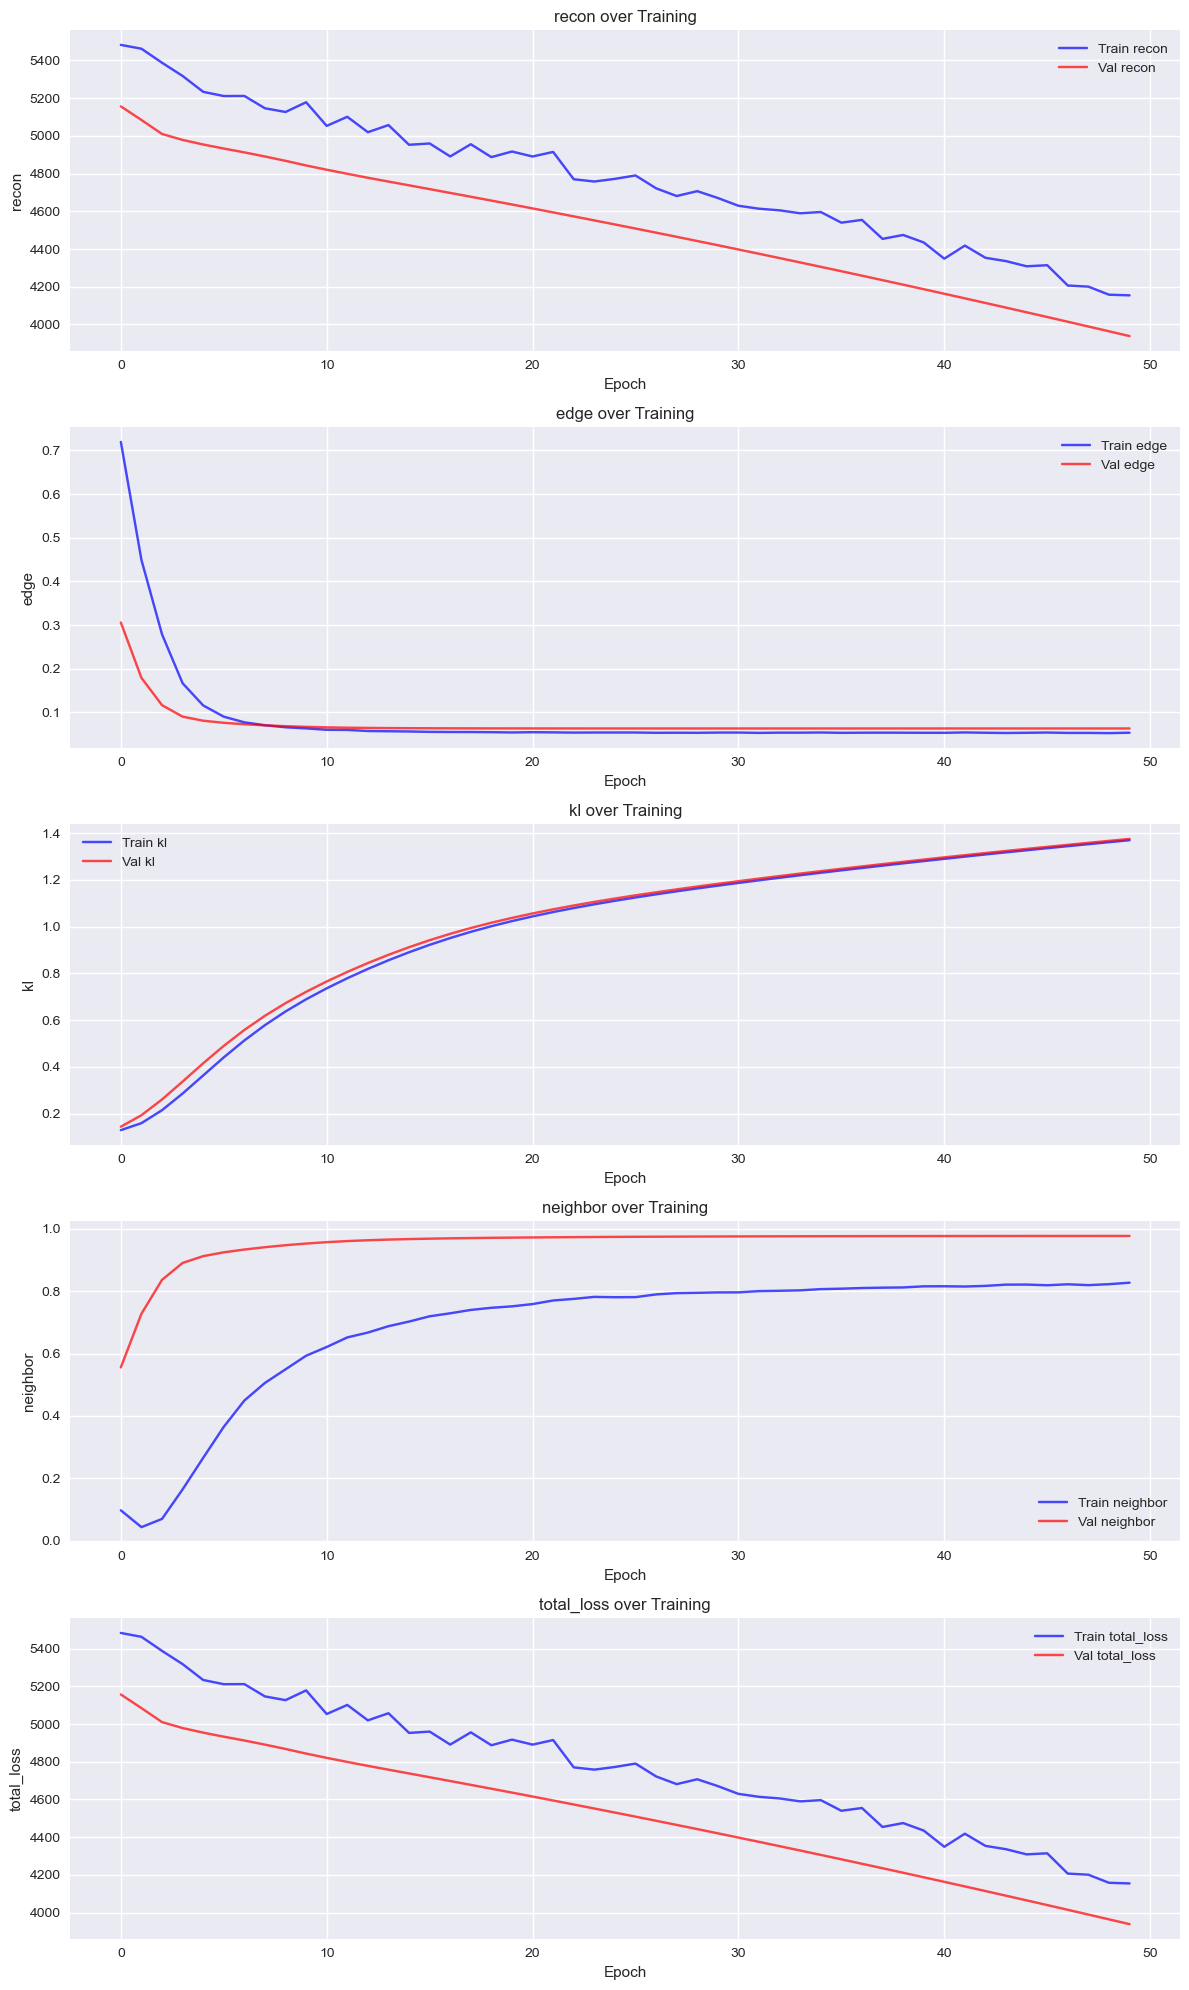

INFO:__main__:
Epoch 50/100
INFO:__main__:Train Loss: 4154.5798
INFO:__main__:Val Loss: 3938.5232


Epoch 51/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 51/100
INFO:__main__:Train Loss: 4181.5012
INFO:__main__:Val Loss: 3912.8687


Epoch 52/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 52/100
INFO:__main__:Train Loss: 4173.8171
INFO:__main__:Val Loss: 3887.0806


Epoch 53/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 53/100
INFO:__main__:Train Loss: 4083.0269
INFO:__main__:Val Loss: 3861.1616


Epoch 54/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 54/100
INFO:__main__:Train Loss: 4042.9456
INFO:__main__:Val Loss: 3835.1135


Epoch 55/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 3808.9375


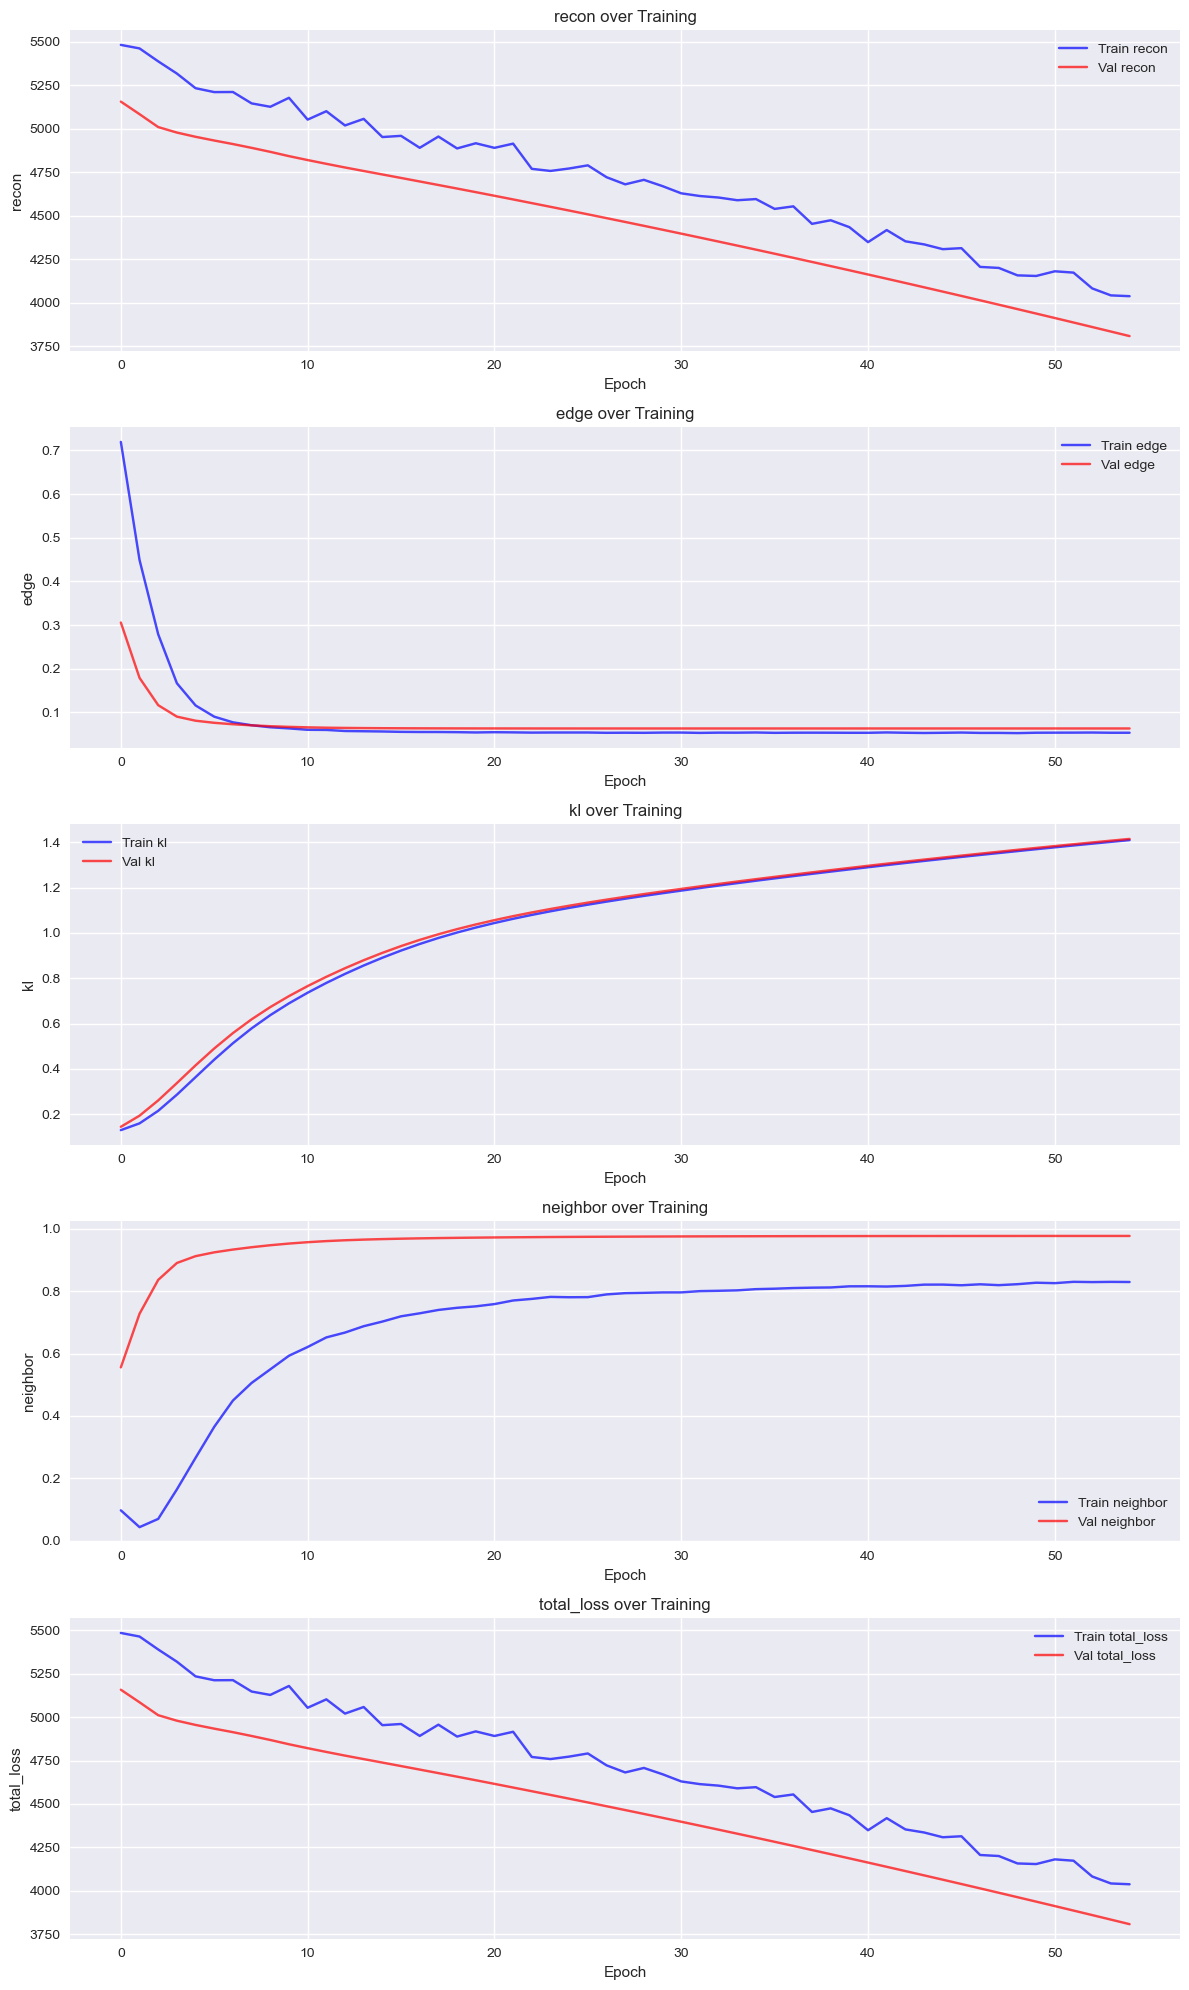

INFO:__main__:
Epoch 55/100
INFO:__main__:Train Loss: 4038.4090
INFO:__main__:Val Loss: 3808.9375


Epoch 56/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 56/100
INFO:__main__:Train Loss: 4020.7654
INFO:__main__:Val Loss: 3782.6372


Epoch 57/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 57/100
INFO:__main__:Train Loss: 3941.8121
INFO:__main__:Val Loss: 3756.2173


Epoch 58/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 58/100
INFO:__main__:Train Loss: 3970.2494
INFO:__main__:Val Loss: 3729.6768


Epoch 59/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 59/100
INFO:__main__:Train Loss: 3969.4472
INFO:__main__:Val Loss: 3703.0195


Epoch 60/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 3676.2476


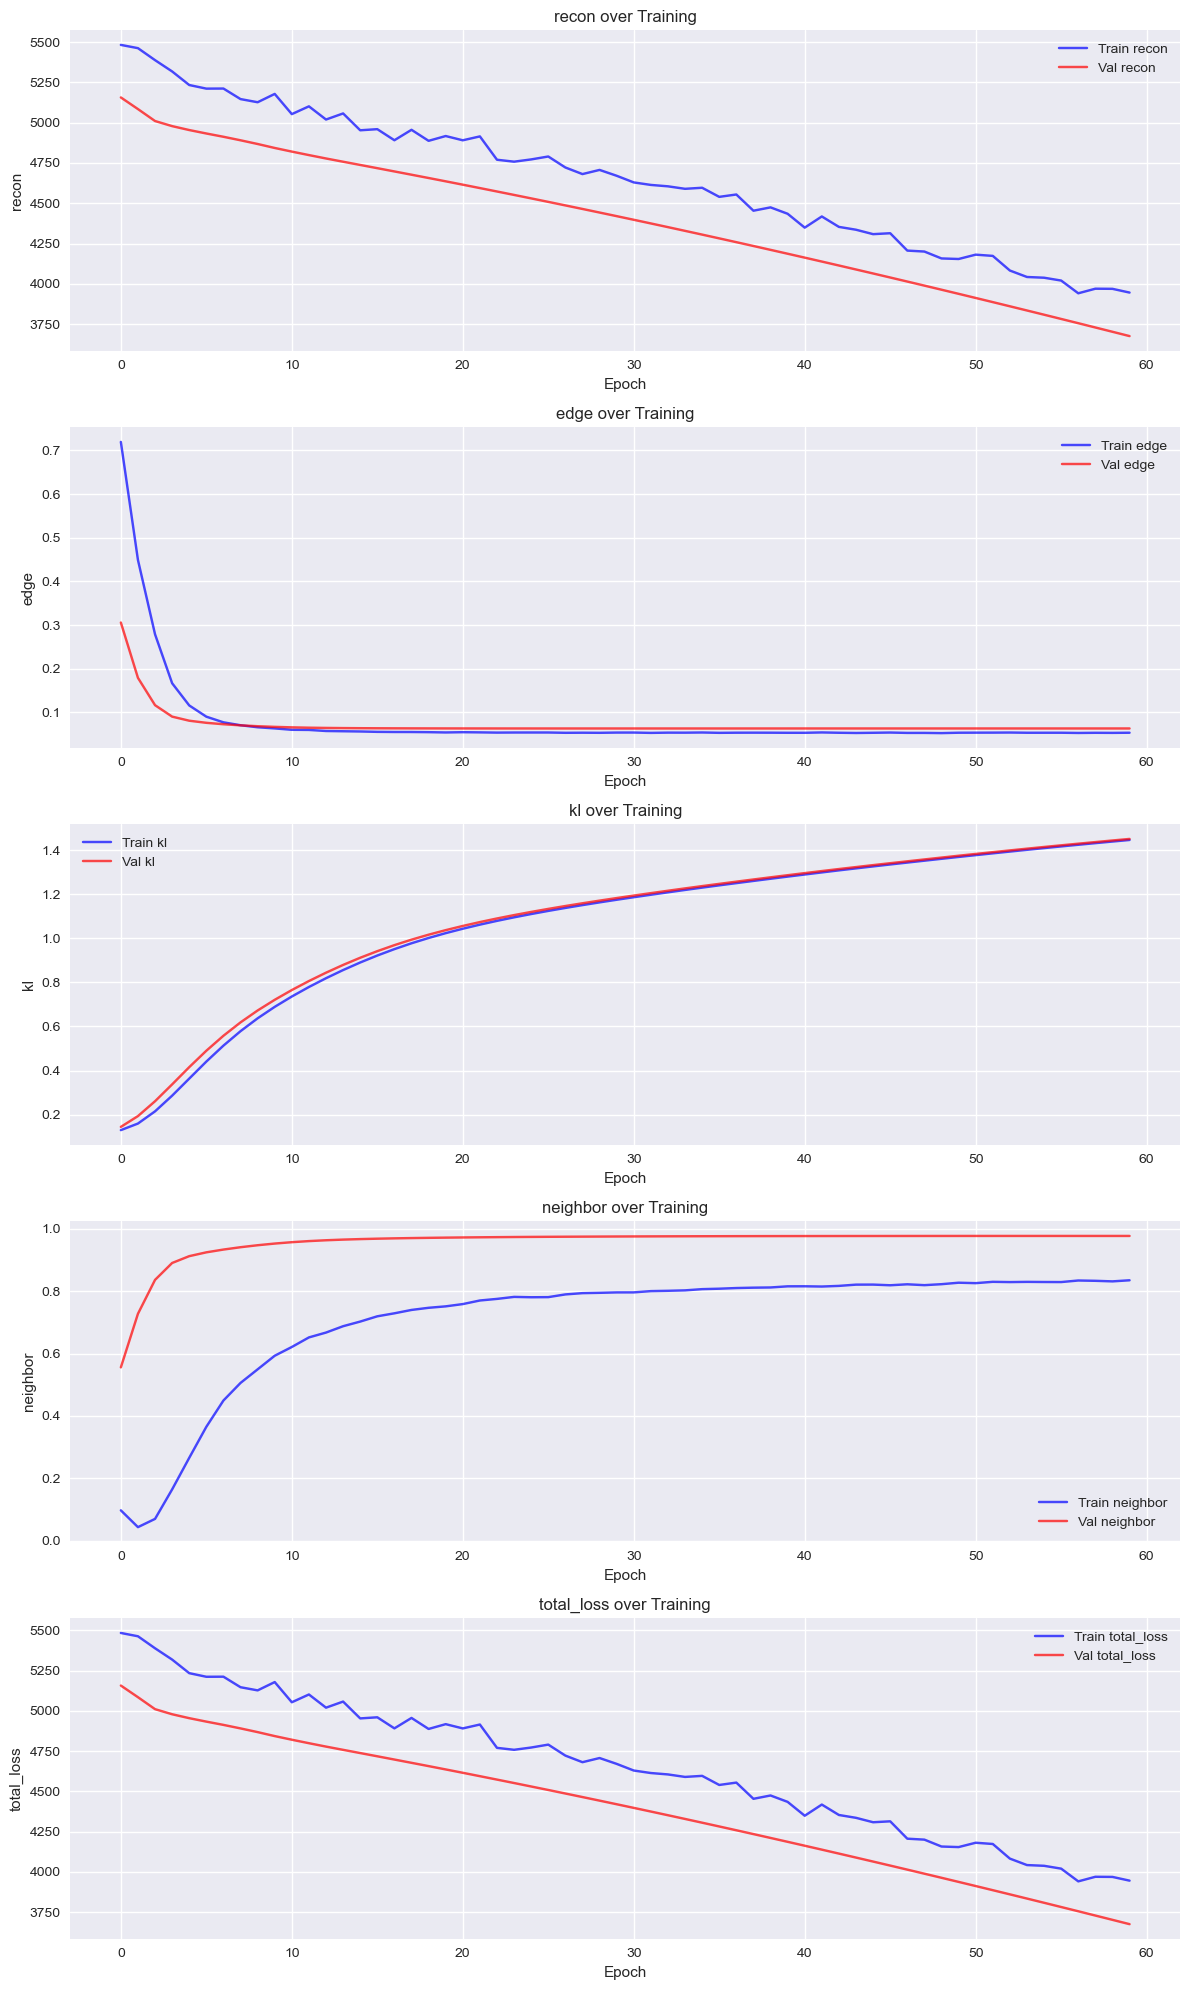

INFO:__main__:
Epoch 60/100
INFO:__main__:Train Loss: 3946.2420
INFO:__main__:Val Loss: 3676.2476


Epoch 61/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 61/100
INFO:__main__:Train Loss: 3909.3545
INFO:__main__:Val Loss: 3649.3640


Epoch 62/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 62/100
INFO:__main__:Train Loss: 3898.4084
INFO:__main__:Val Loss: 3622.3735


Epoch 63/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 63/100
INFO:__main__:Train Loss: 3827.8142
INFO:__main__:Val Loss: 3595.2776


Epoch 64/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 64/100
INFO:__main__:Train Loss: 3835.4823
INFO:__main__:Val Loss: 3568.0806


Epoch 65/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 3540.7827


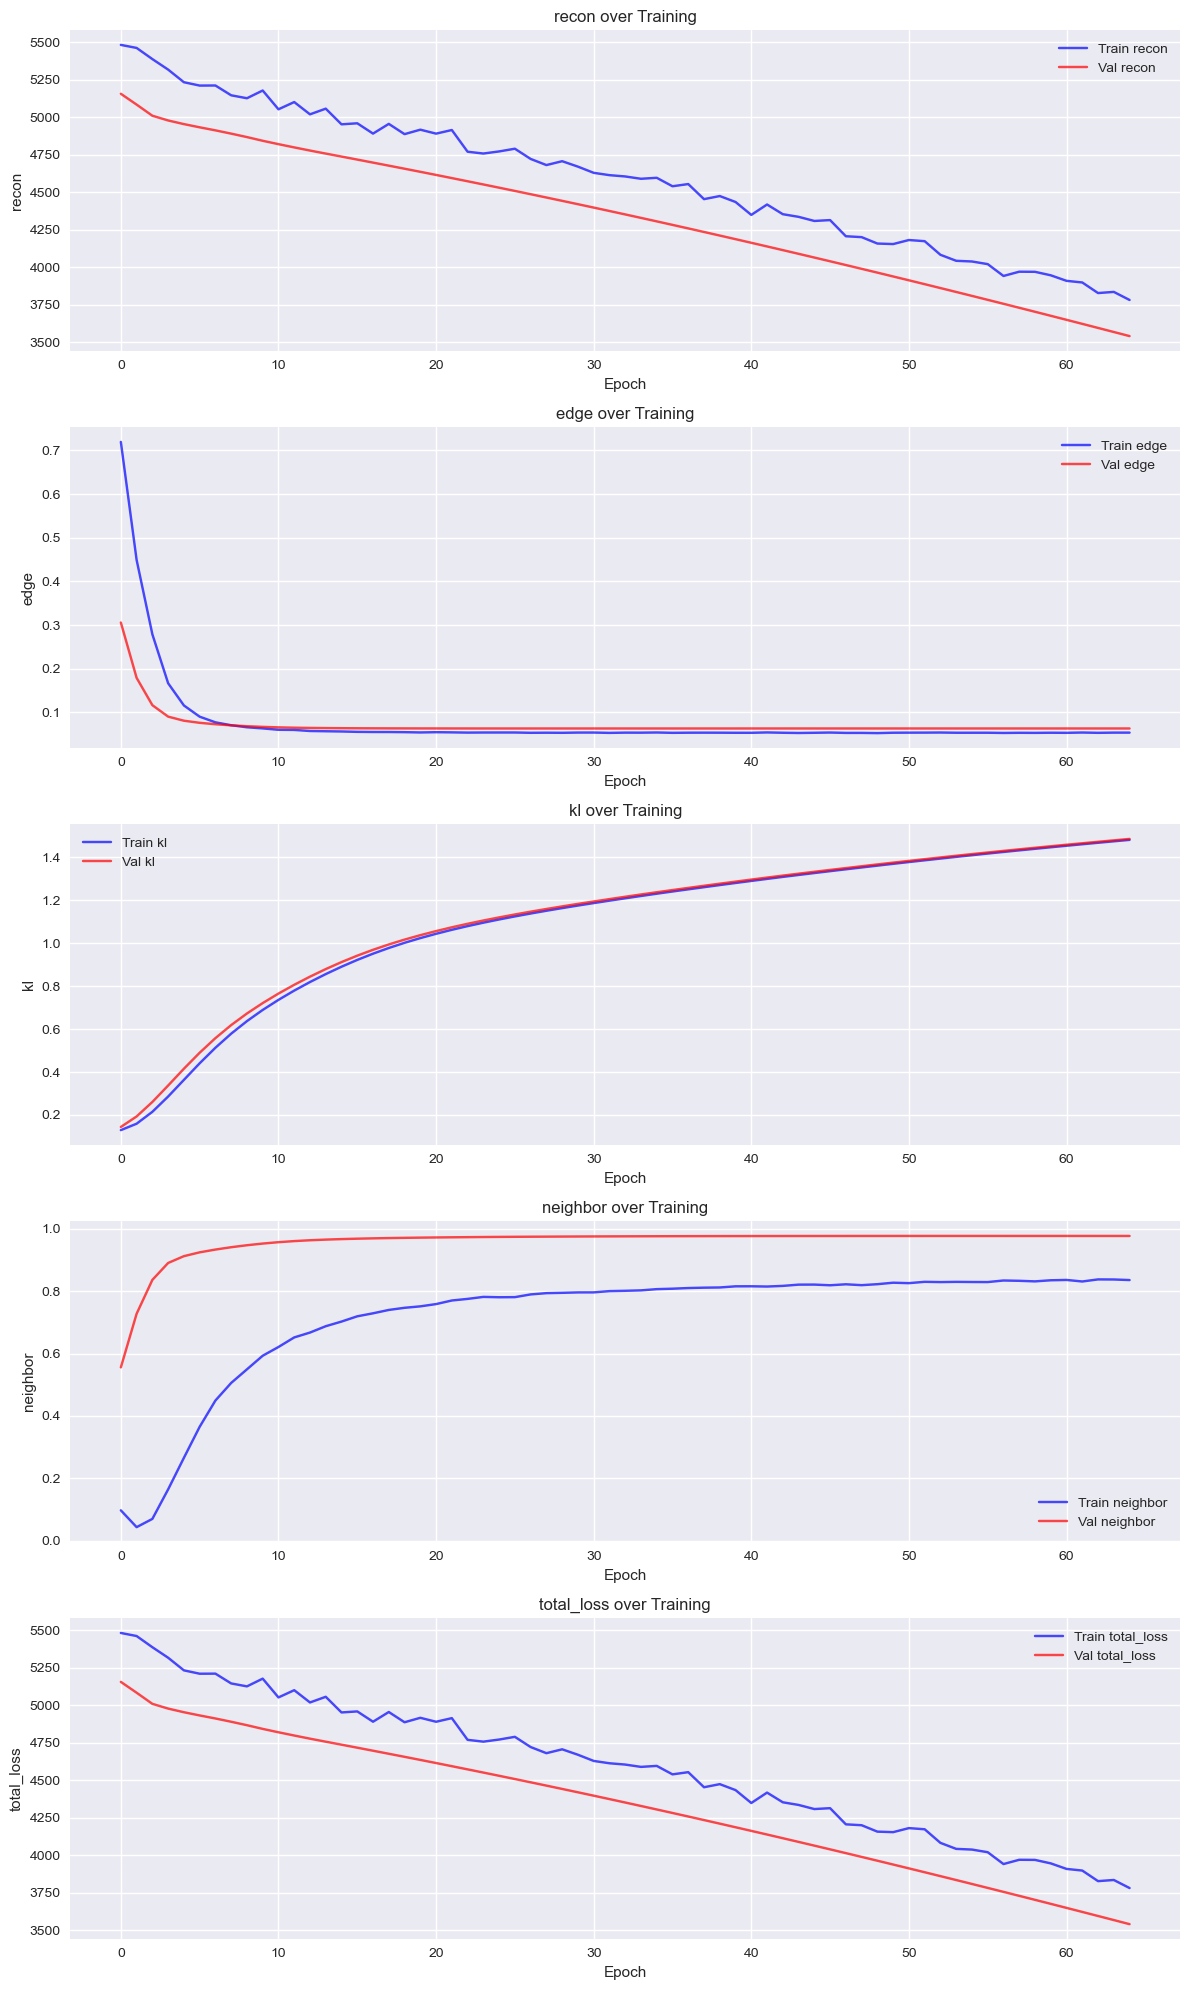

INFO:__main__:
Epoch 65/100
INFO:__main__:Train Loss: 3781.7056
INFO:__main__:Val Loss: 3540.7827


Epoch 66/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 66/100
INFO:__main__:Train Loss: 3774.0987
INFO:__main__:Val Loss: 3513.3882


Epoch 67/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 67/100
INFO:__main__:Train Loss: 3698.9899
INFO:__main__:Val Loss: 3485.9004


Epoch 68/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 68/100
INFO:__main__:Train Loss: 3668.4875
INFO:__main__:Val Loss: 3458.3228


Epoch 69/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 69/100
INFO:__main__:Train Loss: 3641.3767
INFO:__main__:Val Loss: 3430.6567


Epoch 70/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 3402.9075


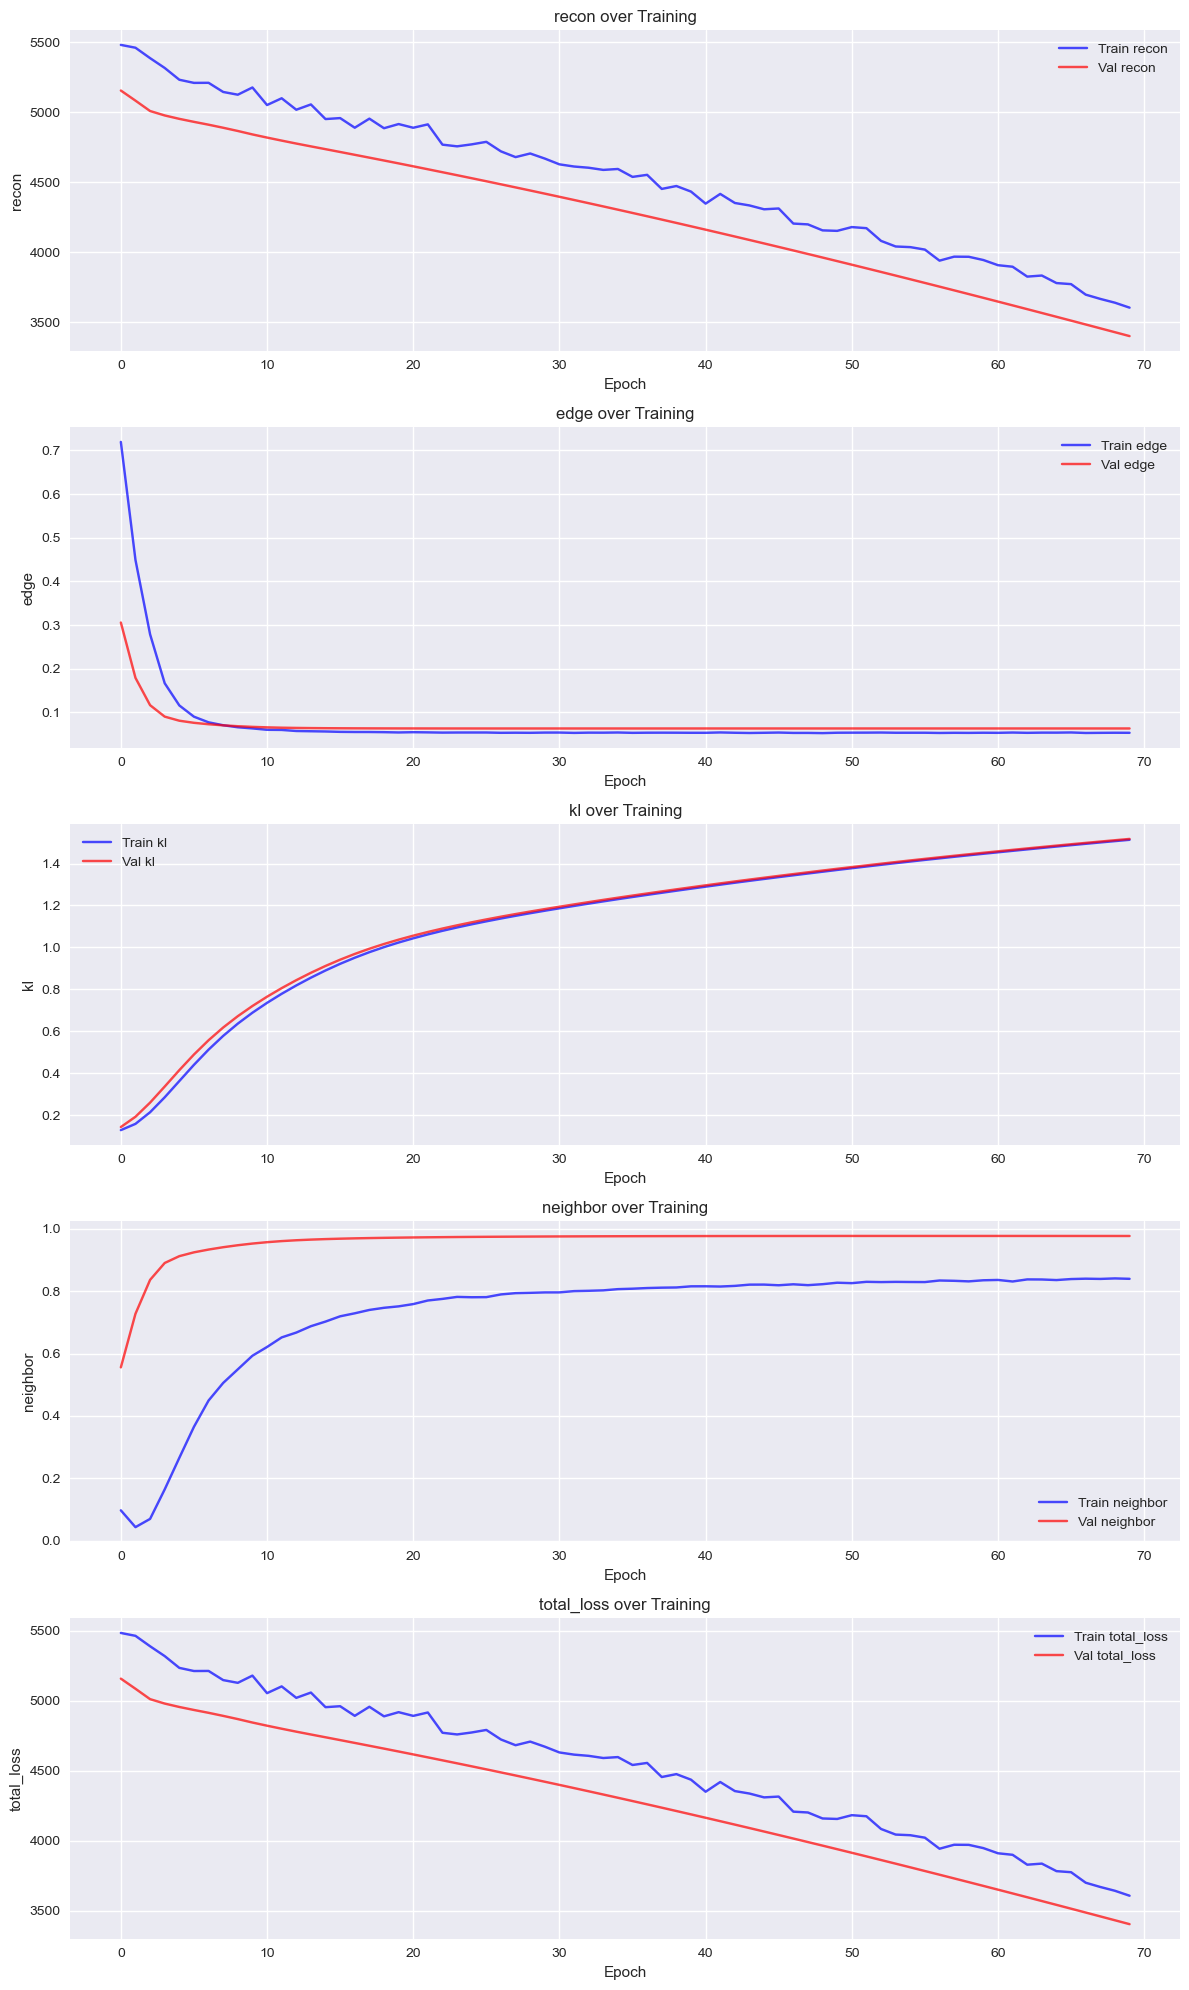

INFO:__main__:
Epoch 70/100
INFO:__main__:Train Loss: 3606.0581
INFO:__main__:Val Loss: 3402.9075


Epoch 71/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 71/100
INFO:__main__:Train Loss: 3597.6409
INFO:__main__:Val Loss: 3375.0774


Epoch 72/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 72/100
INFO:__main__:Train Loss: 3570.4211
INFO:__main__:Val Loss: 3347.1692


Epoch 73/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 73/100
INFO:__main__:Train Loss: 3545.8009
INFO:__main__:Val Loss: 3319.1853


Epoch 74/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 74/100
INFO:__main__:Train Loss: 3546.3301
INFO:__main__:Val Loss: 3291.1301


Epoch 75/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 3263.0068


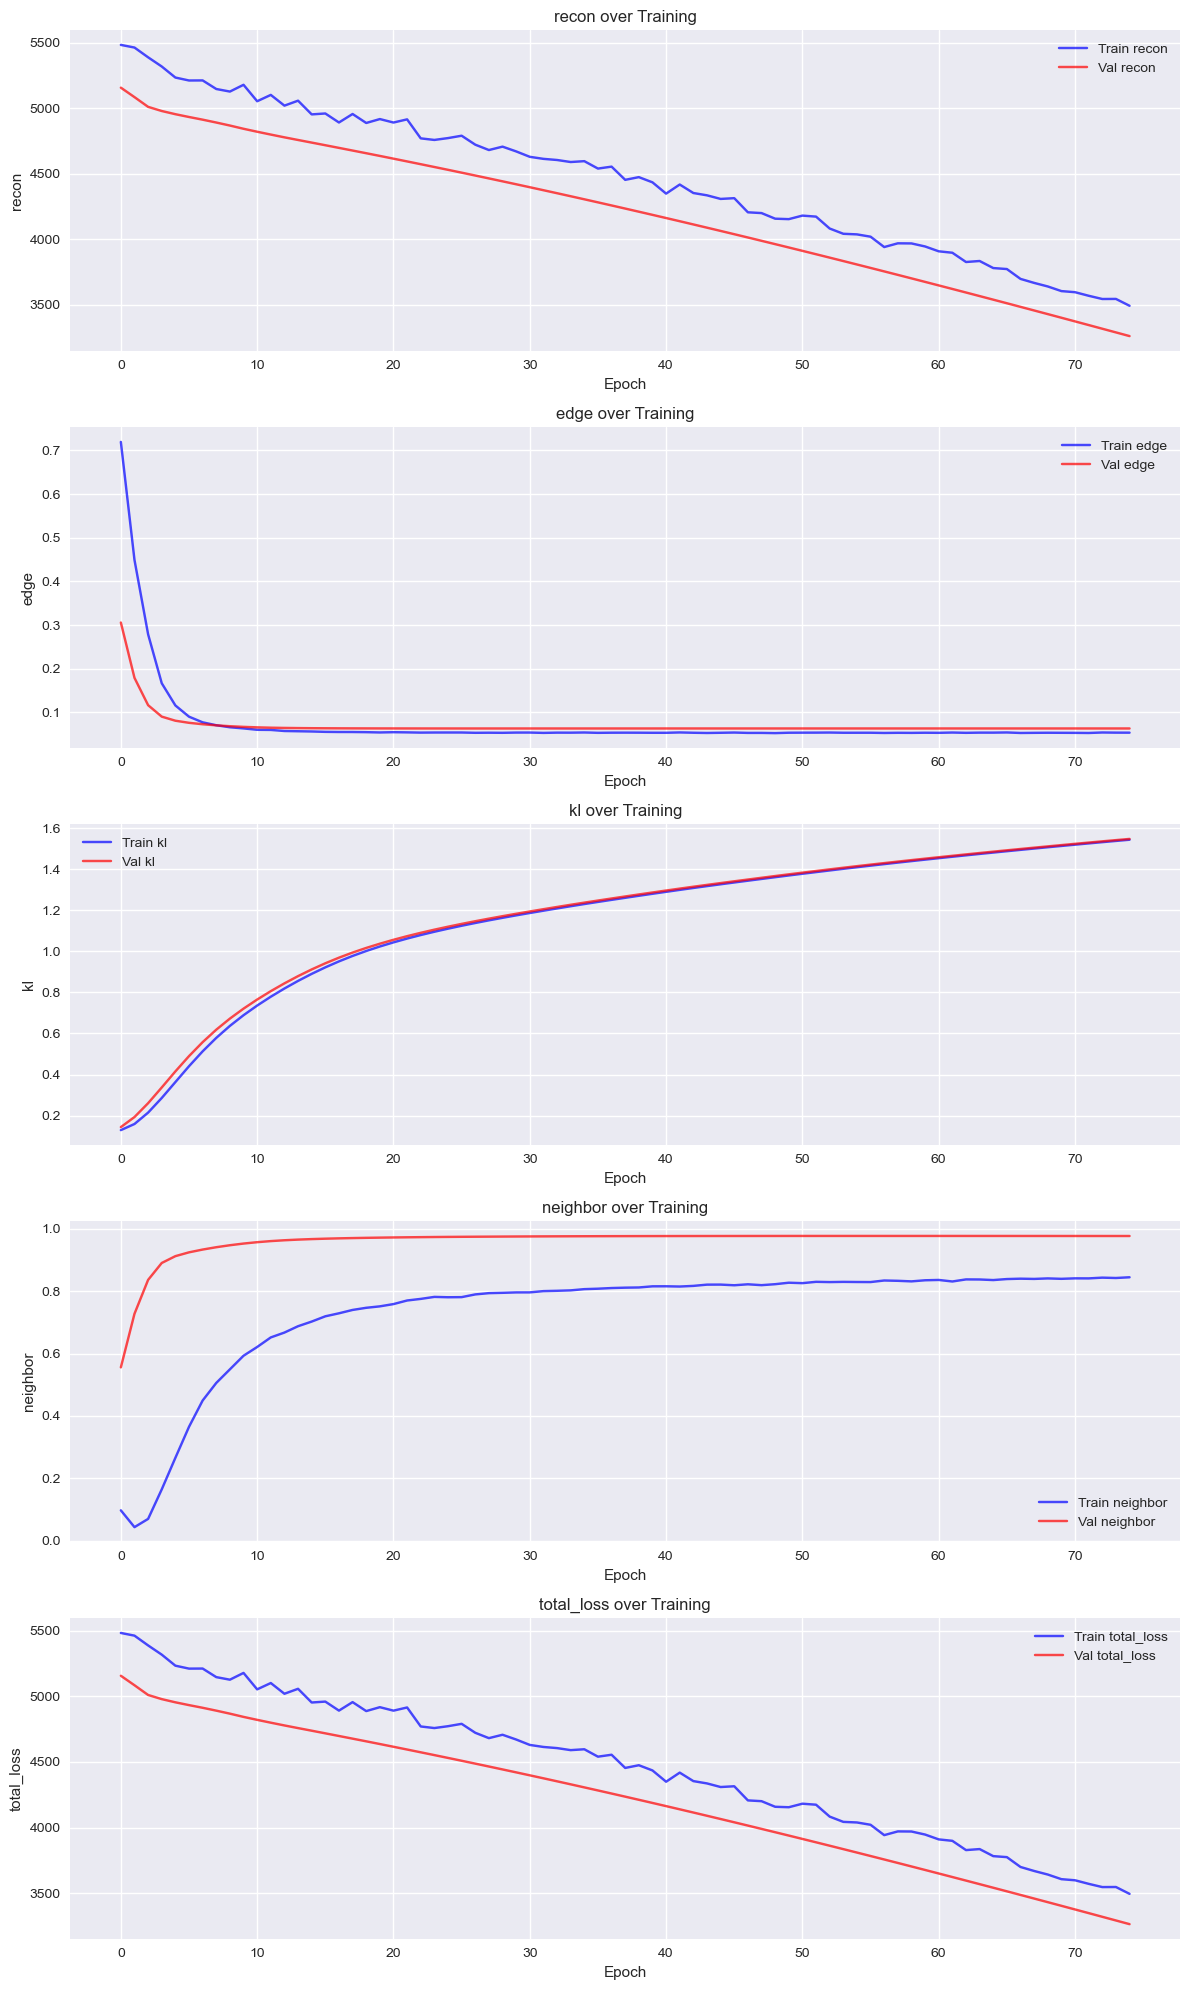

INFO:__main__:
Epoch 75/100
INFO:__main__:Train Loss: 3494.0145
INFO:__main__:Val Loss: 3263.0068


Epoch 76/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 76/100
INFO:__main__:Train Loss: 3430.9528
INFO:__main__:Val Loss: 3234.8149


Epoch 77/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 77/100
INFO:__main__:Train Loss: 3435.0000
INFO:__main__:Val Loss: 3206.5623


Epoch 78/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 78/100
INFO:__main__:Train Loss: 3381.3173
INFO:__main__:Val Loss: 3178.2527


Epoch 79/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 79/100
INFO:__main__:Train Loss: 3396.0617
INFO:__main__:Val Loss: 3149.8867


Epoch 80/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 3121.4683


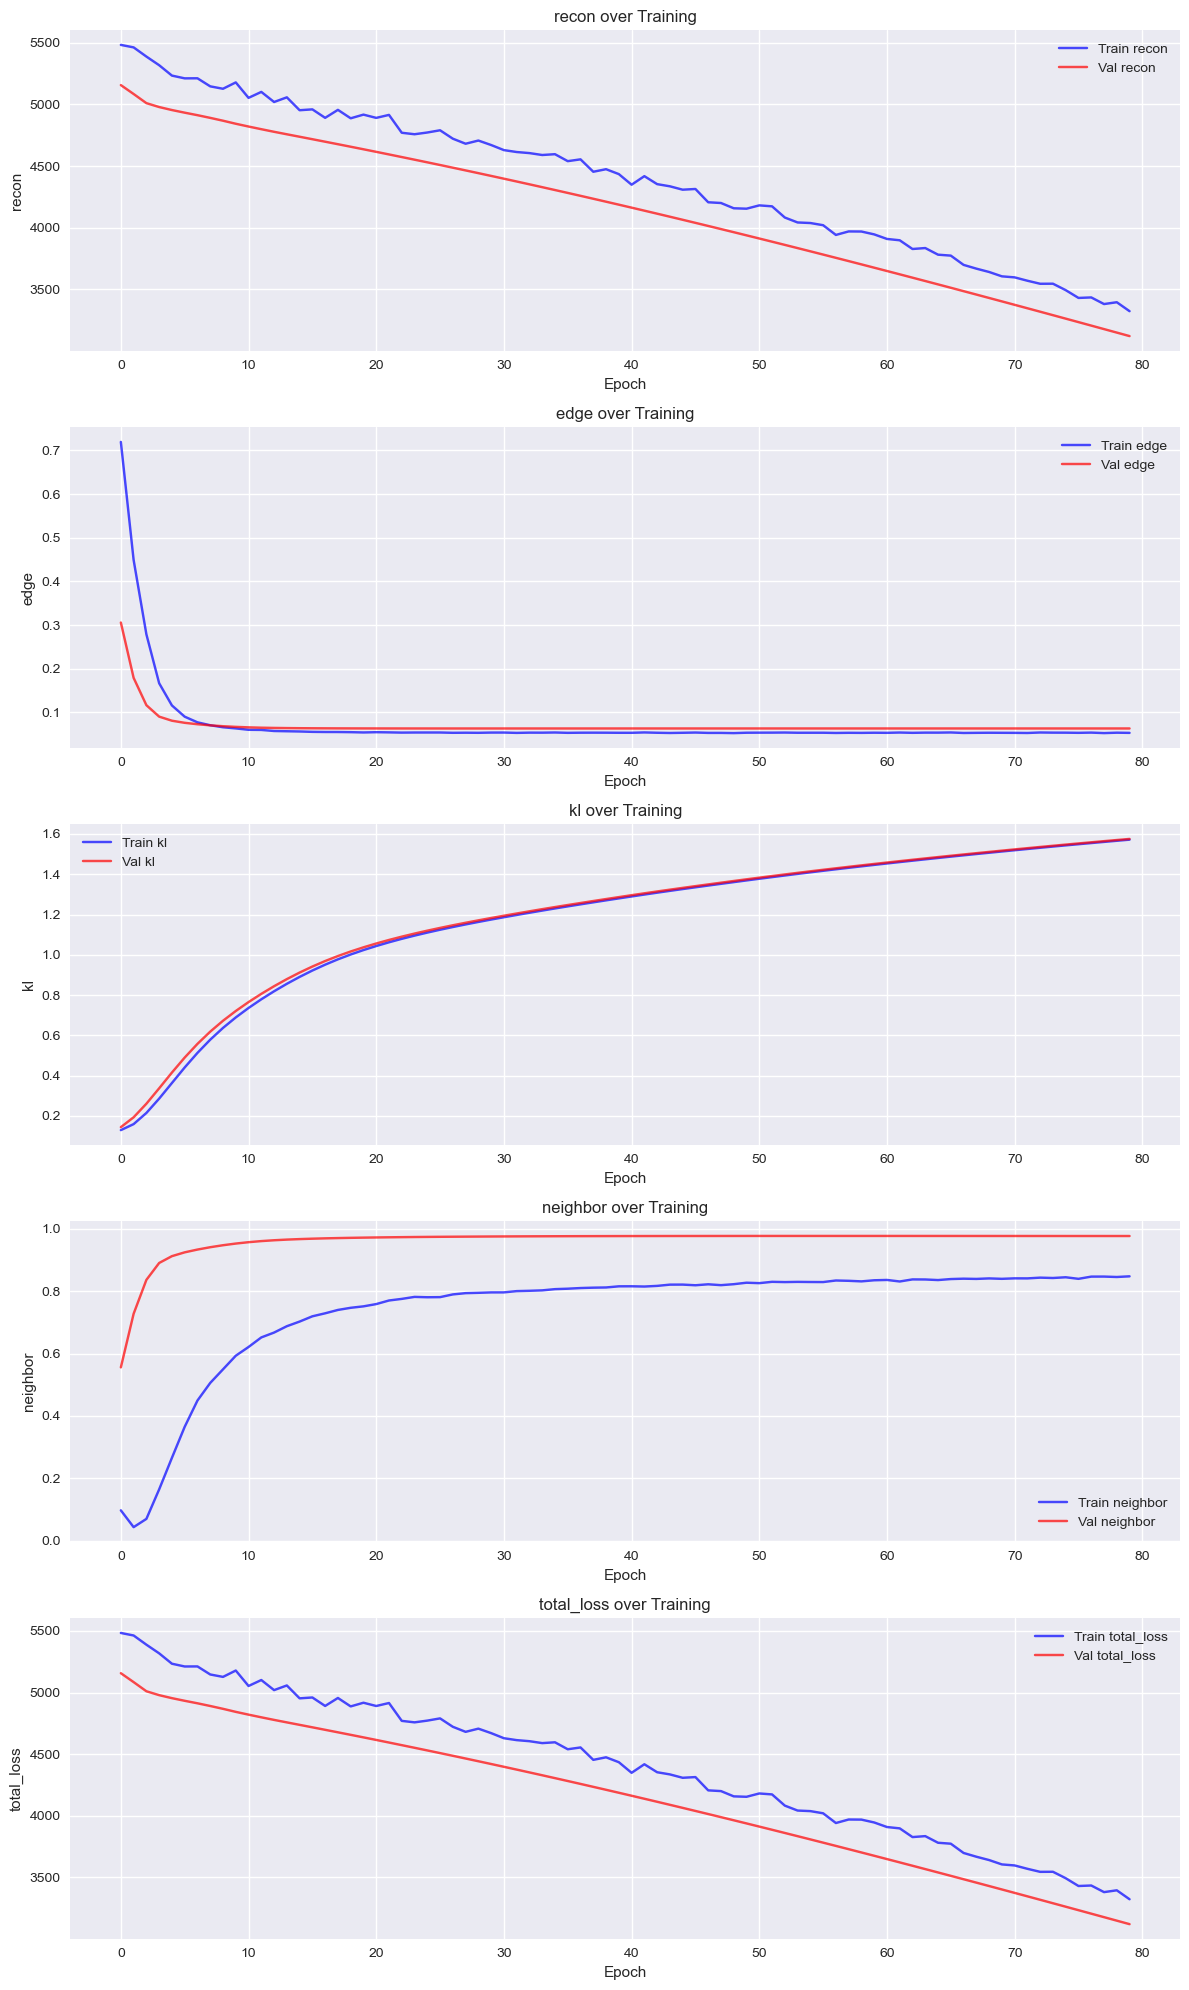

INFO:__main__:
Epoch 80/100
INFO:__main__:Train Loss: 3323.3991
INFO:__main__:Val Loss: 3121.4683


Epoch 81/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 81/100
INFO:__main__:Train Loss: 3343.2350
INFO:__main__:Val Loss: 3093.0007


Epoch 82/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 82/100
INFO:__main__:Train Loss: 3324.8186
INFO:__main__:Val Loss: 3064.4890


Epoch 83/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 83/100
INFO:__main__:Train Loss: 3259.6122
INFO:__main__:Val Loss: 3035.9331


Epoch 84/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 84/100
INFO:__main__:Train Loss: 3240.3866
INFO:__main__:Val Loss: 3007.3396


Epoch 85/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 2978.7080


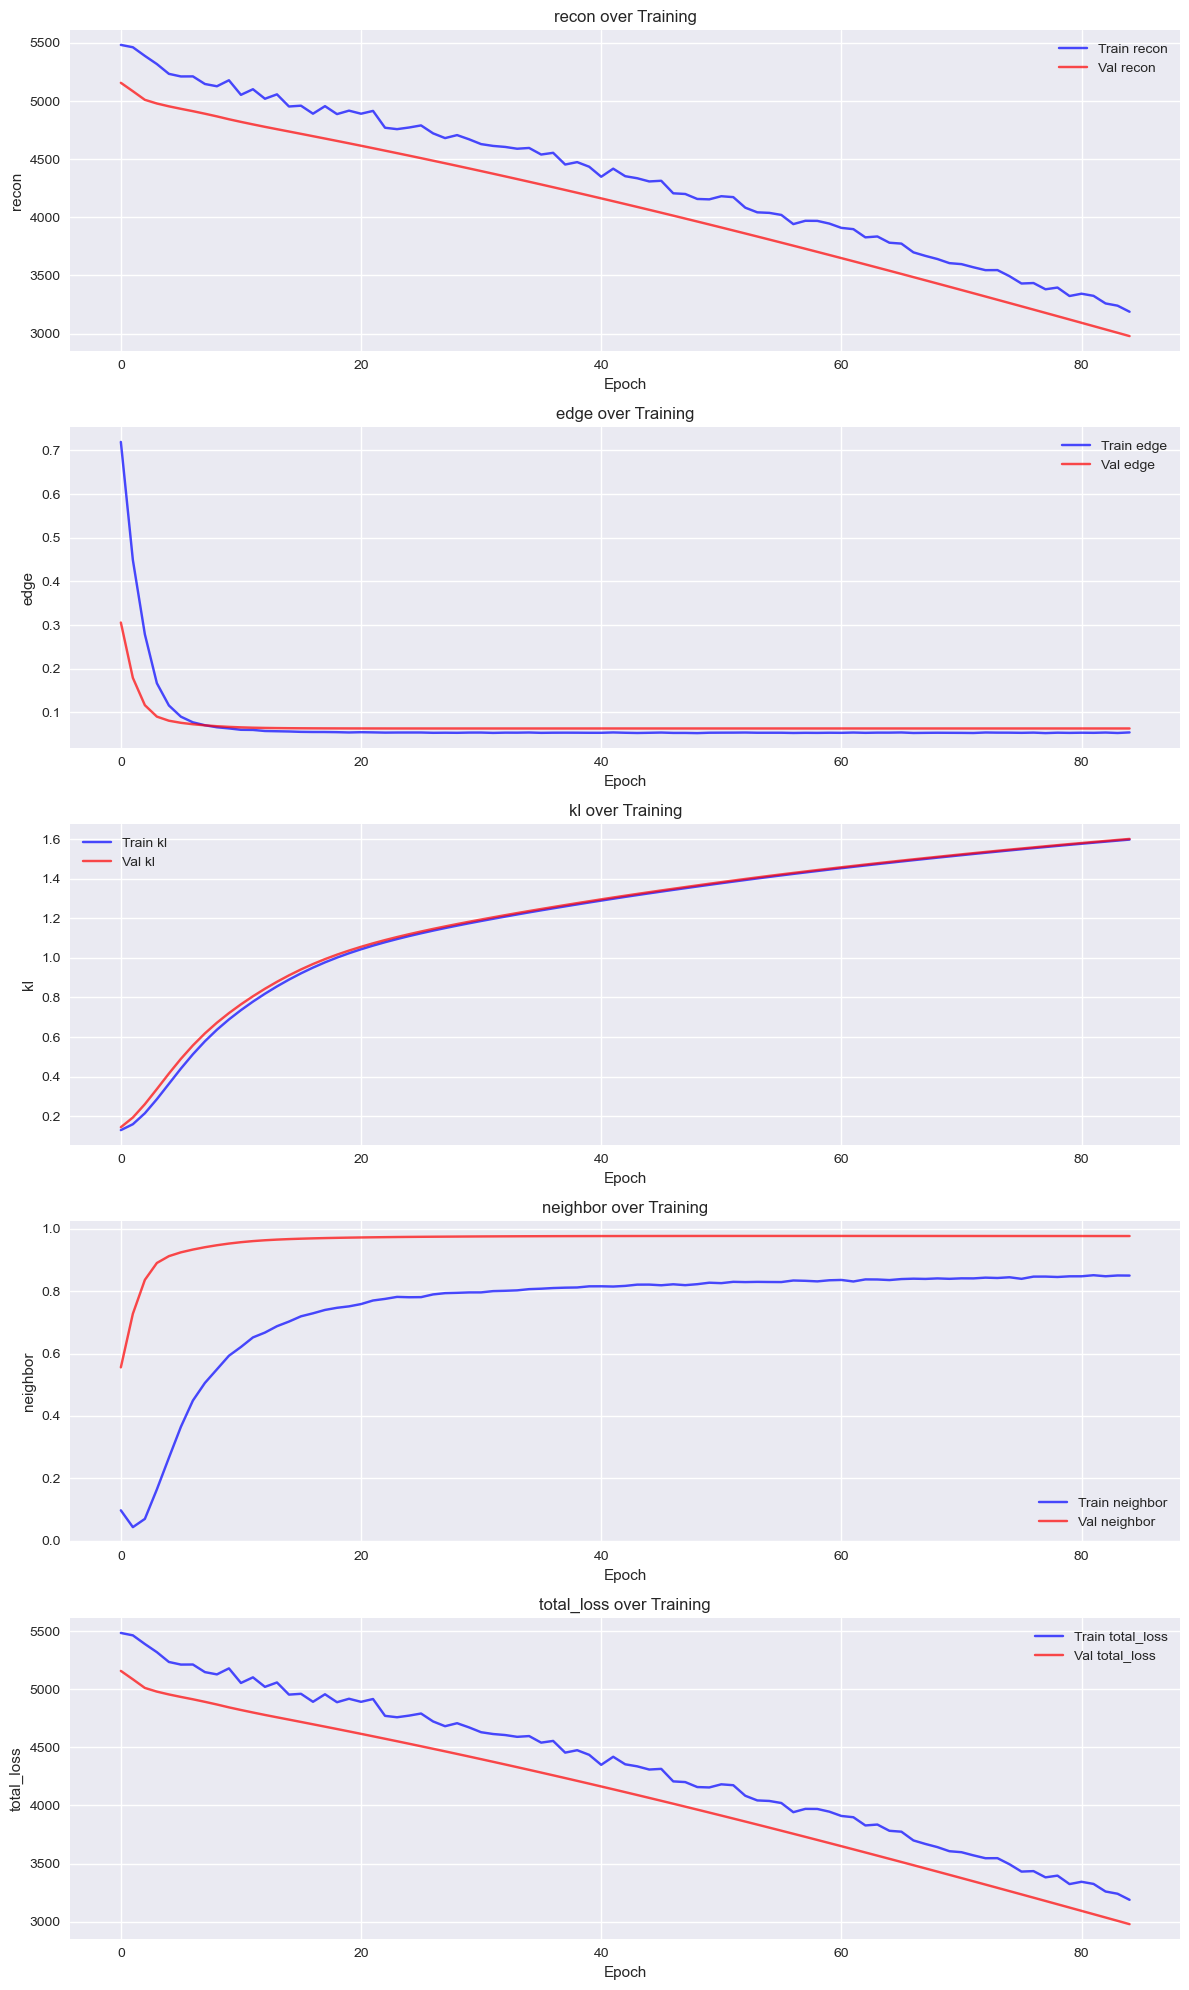

INFO:__main__:
Epoch 85/100
INFO:__main__:Train Loss: 3188.1018
INFO:__main__:Val Loss: 2978.7080


Epoch 86/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 86/100
INFO:__main__:Train Loss: 3147.5105
INFO:__main__:Val Loss: 2950.0430


Epoch 87/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 87/100
INFO:__main__:Train Loss: 3121.8282
INFO:__main__:Val Loss: 2921.3489


Epoch 88/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 88/100
INFO:__main__:Train Loss: 3078.5706
INFO:__main__:Val Loss: 2892.6267


Epoch 89/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 89/100
INFO:__main__:Train Loss: 3093.7205
INFO:__main__:Val Loss: 2863.8816


Epoch 90/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 2835.1160


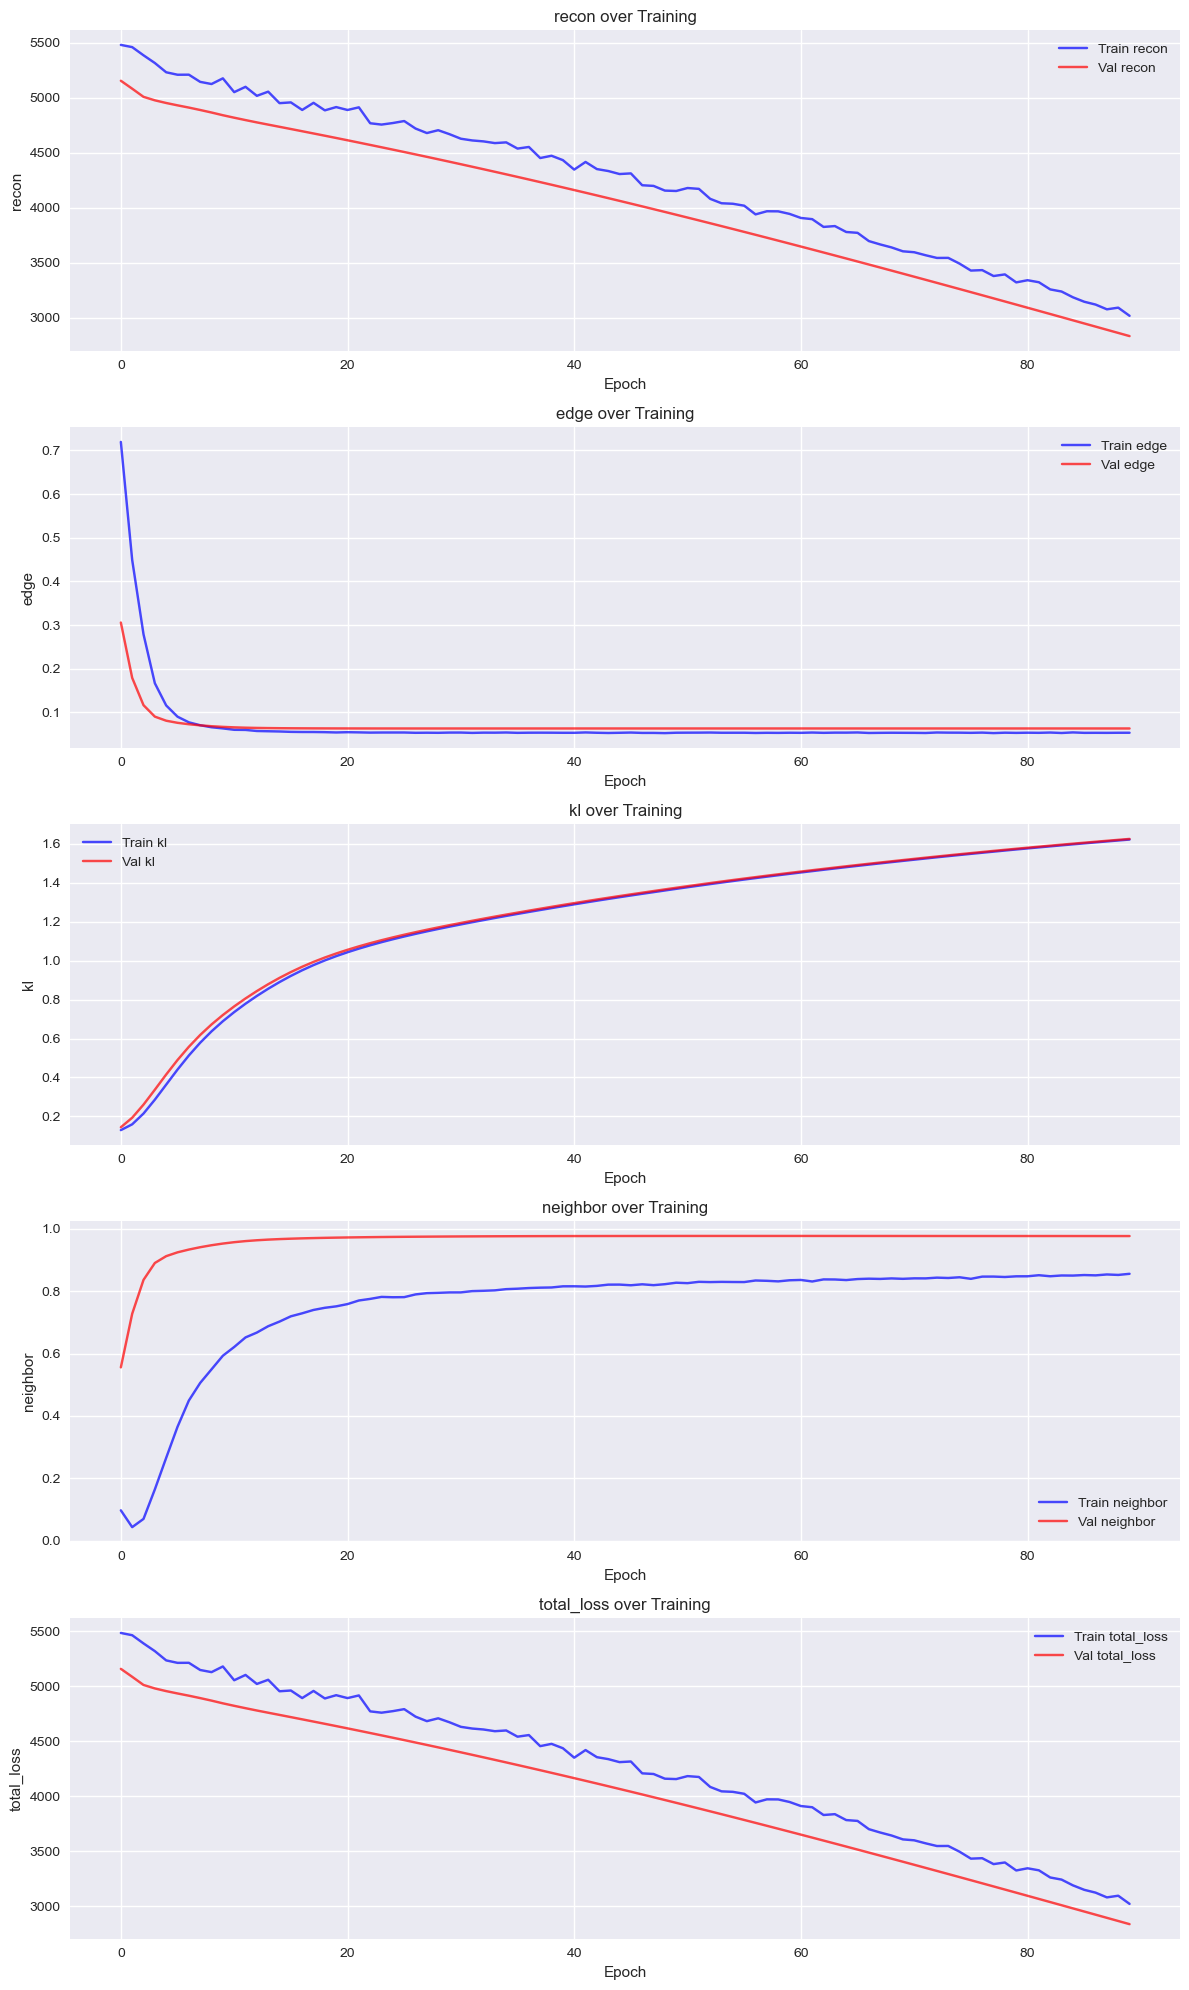

INFO:__main__:
Epoch 90/100
INFO:__main__:Train Loss: 3019.4518
INFO:__main__:Val Loss: 2835.1160


Epoch 91/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 91/100
INFO:__main__:Train Loss: 3017.0215
INFO:__main__:Val Loss: 2806.3318


Epoch 92/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 92/100
INFO:__main__:Train Loss: 2963.7827
INFO:__main__:Val Loss: 2777.5322


Epoch 93/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 93/100
INFO:__main__:Train Loss: 2929.1366
INFO:__main__:Val Loss: 2748.7231


Epoch 94/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 94/100
INFO:__main__:Train Loss: 2932.4857
INFO:__main__:Val Loss: 2719.9048


Epoch 95/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 2691.0813


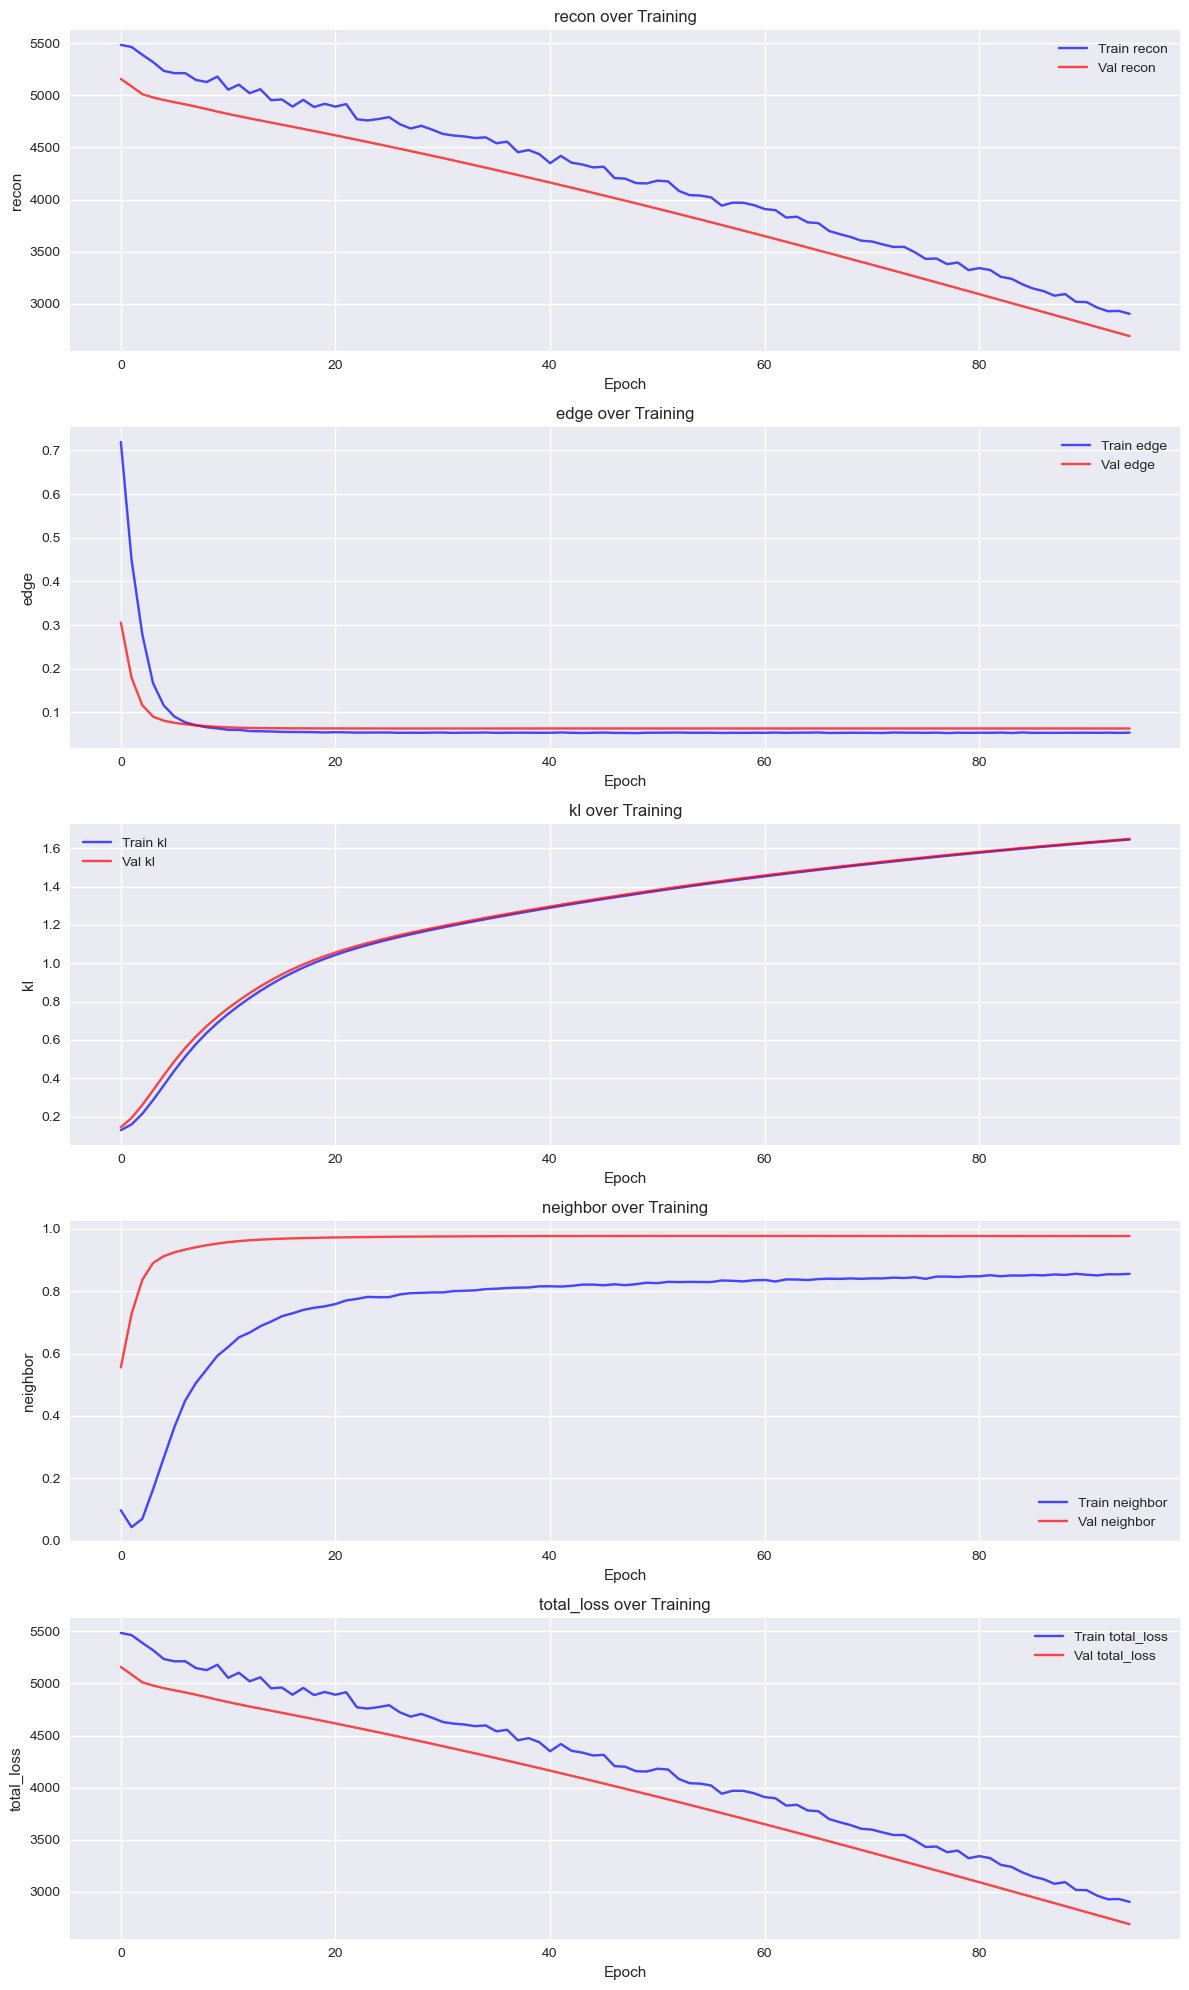

INFO:__main__:
Epoch 95/100
INFO:__main__:Train Loss: 2904.8725
INFO:__main__:Val Loss: 2691.0813


Epoch 96/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 96/100
INFO:__main__:Train Loss: 2876.4962
INFO:__main__:Val Loss: 2662.2544


Epoch 97/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 97/100
INFO:__main__:Train Loss: 2844.6715
INFO:__main__:Val Loss: 2633.4304


Epoch 98/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 98/100
INFO:__main__:Train Loss: 2818.4010
INFO:__main__:Val Loss: 2604.6101


Epoch 99/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
Epoch 99/100
INFO:__main__:Train Loss: 2778.0609
INFO:__main__:Val Loss: 2575.7969


Epoch 100/100 [Train]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100/100 [Val]:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:
New best model saved with validation loss: 2546.9941


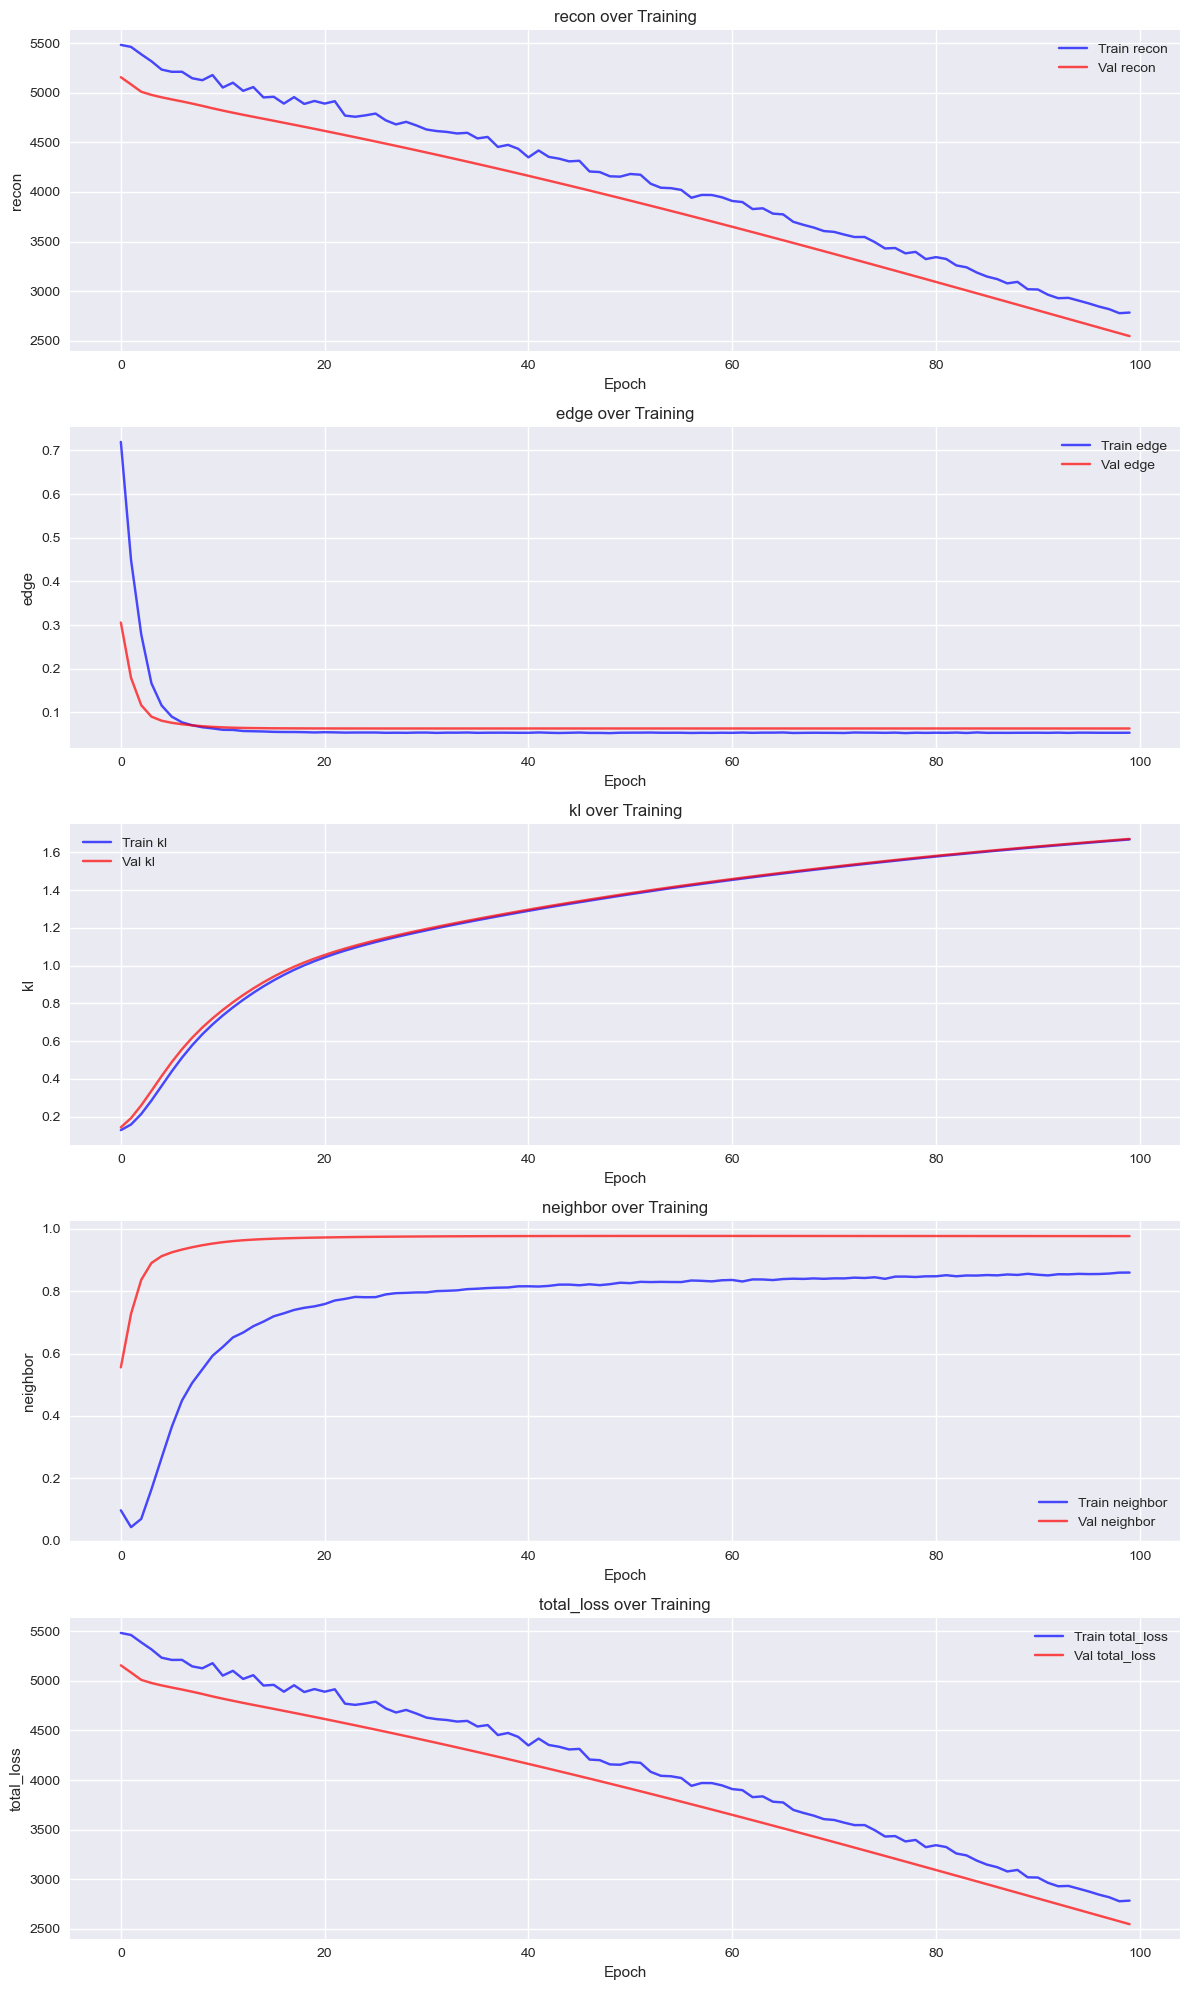

INFO:__main__:
Epoch 100/100
INFO:__main__:Train Loss: 2784.2641
INFO:__main__:Val Loss: 2546.9941


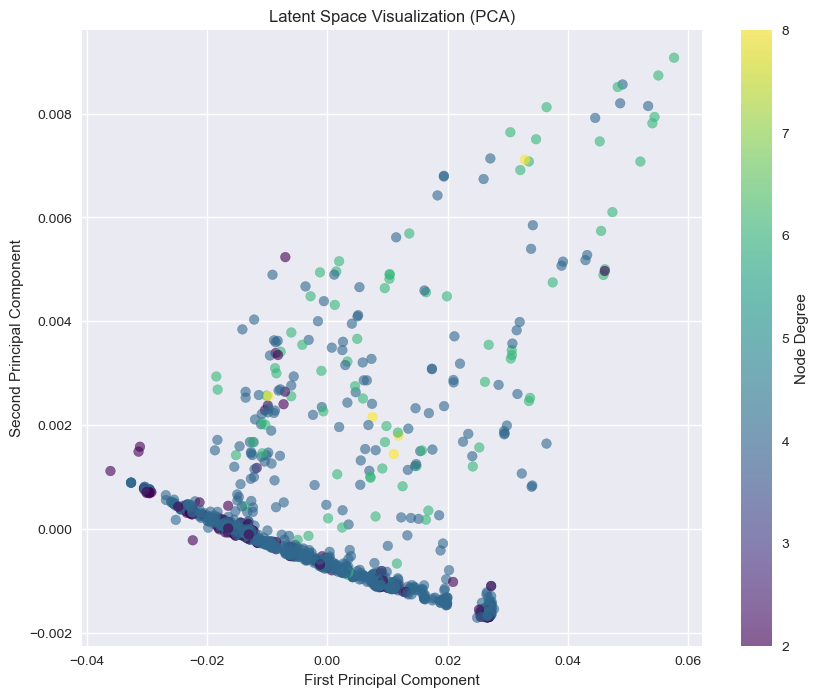

In [14]:
# Example usage
def main():
    # Set device
    device = get_device()
    logger.info(f"Using device: {device}")

    # Initialize model
    model = MolecularGVAE(
        node_features=train_graphs[0].x.size(1),
        hidden_dim=64,
        latent_dim=32
    ).to(device)

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train model
    training_manager = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        n_epochs=100,
        device=device,
        patience=10,
        checkpoint_frequency=5,
        max_grad_norm=1.0
    )

    # Visualize results
    plot_latent_space(model, train_loader, device)

if __name__ == "__main__":
    main()

In [28]:
def generate_protein_structures(model, num_proteins=5, num_residues=100, device='cpu'):
    """
    Generate new protein structures using the trained VAE with debugging
    """
    model.eval()
    generated_proteins = []

    with torch.no_grad():
        for protein_idx in range(num_proteins):
            print(f"\nGenerating protein {protein_idx + 1}/{num_proteins}")

            # Sample from latent space
            z = torch.randn(num_residues, model.latent_dim).to(device)
            print(f"Latent vector shape: {z.shape}")

            # Create initial edge structure
            sources = []
            targets = []
            for j in range(num_residues-1):
                sources.extend([j, j+1])
                targets.extend([j+1, j])

            edge_index = torch.tensor([sources, targets], dtype=torch.long).to(device)
            print(f"Edge index shape: {edge_index.shape}")

            # Decode
            node_features, edge_logits, neighbor_context = model.decode(z, edge_index, num_residues)
            print(f"\nDecoder outputs:")
            print(f"Node features shape: {node_features.shape}")
            print(f"Edge logits shape: {edge_logits.shape}")
            print(f"Neighbor context shape: {neighbor_context.shape}")

            # Extract positions using pos attribute if it exists
            if hasattr(model, 'use_pos') and model.use_pos:
                positions = node_features  # Directly use as positions
            else:
                # Check if node features contains position information
                if node_features.shape[1] >= 3:
                    positions = node_features[:, :3]
                else:
                    raise ValueError(f"Node features dimension {node_features.shape[1]} is too small for positions")

            print(f"Positions shape: {positions.shape}")
            print(f"Position value range: [{positions.min().item():.2f}, {positions.max().item():.2f}]")

            # Convert edge logits to probabilities
            edge_probs = torch.sigmoid(edge_logits)

            # Create new edges based on probabilities
            new_edges = []
            for i in range(num_residues):
                for j in range(i+1, num_residues):
                    if edge_probs[i, j] > 0.5:
                        new_edges.extend([[i, j], [j, i]])

            if new_edges:
                new_edge_index = torch.tensor(new_edges, dtype=torch.long).t().to(device)
                edge_index = torch.cat([edge_index, new_edge_index], dim=1)

            print(f"Final edge index shape: {edge_index.shape}")

            # Generate random amino acid indices for now
            aa_indices = torch.randint(0, 20, (num_residues,), device=device)

            # Create protein dictionary
            protein = {
                'positions': positions.cpu().numpy(),
                'amino_acids': aa_indices.cpu().numpy(),
                'edge_index': edge_index.cpu().numpy(),
                'node_features': node_features.cpu().numpy(),
                'edge_probabilities': edge_probs.cpu().numpy(),
                'neighbor_context': neighbor_context.cpu().numpy()
            }

            # Verify data
            print("\nGenerated protein data:")
            for key, value in protein.items():
                print(f"{key} shape: {value.shape}")

            generated_proteins.append(protein)

    return generated_proteins

In [26]:
# Check model input/output dimensions
sample_batch = next(iter(train_loader))
print("\nInput dimensions:")
print("Node features shape:", sample_batch.x.shape)
print("Position shape:", sample_batch.pos.shape)


Input dimensions:
Node features shape: torch.Size([577, 3])
Position shape: torch.Size([577, 3])


In [29]:
# Generate and analyze proteins
generated_proteins = generate_protein_structures(
    model,
    num_proteins=5,
    num_residues=100,
    device=device
)


Generating protein 1/5
Latent vector shape: torch.Size([100, 32])
Edge index shape: torch.Size([2, 198])

Decoder outputs:
Node features shape: torch.Size([100, 3])
Edge logits shape: torch.Size([100, 100])
Neighbor context shape: torch.Size([100, 32])
Positions shape: torch.Size([100, 3])
Position value range: [-2.05, 1.87]
Final edge index shape: torch.Size([2, 6406])

Generated protein data:
positions shape: (100, 3)
amino_acids shape: (100,)
edge_index shape: (2, 6406)
node_features shape: (100, 3)
edge_probabilities shape: (100, 100)
neighbor_context shape: (100, 32)

Generating protein 2/5
Latent vector shape: torch.Size([100, 32])
Edge index shape: torch.Size([2, 198])

Decoder outputs:
Node features shape: torch.Size([100, 3])
Edge logits shape: torch.Size([100, 100])
Neighbor context shape: torch.Size([100, 32])
Positions shape: torch.Size([100, 3])
Position value range: [-1.62, 1.88]
Final edge index shape: torch.Size([2, 6002])

Generated protein data:
positions shape: (100

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def visualize_protein_structure(protein, title=None, figsize=(12, 8), 
                              edge_threshold=0.5, show_edges=True,
                              alpha_edges=0.3, node_size=100):
    """
    Visualize a 3D protein structure with nodes and edges
    
    Args:
        protein: Dictionary containing protein data
        title: Optional title for the plot
        figsize: Figure size tuple (width, height)
        edge_threshold: Threshold for including edges based on probability
        show_edges: Whether to display edges
        alpha_edges: Transparency of edges
        node_size: Size of nodes in the scatter plot
    """
    positions = protein['positions']
    edge_probs = protein['edge_probabilities']
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot nodes (amino acids)
    x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
    scatter = ax.scatter(x, y, z, 
                        c=range(len(x)),  # Color by sequence position
                        cmap='viridis',
                        s=node_size)
    
    # Plot edges if requested
    if show_edges:
        for i in range(len(positions)):
            for j in range(i+1, len(positions)):
                if edge_probs[i, j] > edge_threshold:
                    ax.plot([x[i], x[j]], 
                          [y[i], y[j]], 
                          [z[i], z[j]], 
                          color='gray',
                          alpha=alpha_edges * edge_probs[i, j])
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if title:
        plt.title(title)
    
    # Add colorbar
    plt.colorbar(scatter, label='Sequence Position')
    
    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])
    
    return fig, ax

def plot_protein_batch(proteins, ncols=2, figsize=(15, 12), **kwargs):
    """
    Plot multiple protein structures in a grid
    
    Args:
        proteins: List of protein dictionaries
        ncols: Number of columns in the grid
        figsize: Figure size tuple (width, height)
        **kwargs: Additional arguments passed to visualize_protein_structure
    """
    nrows = (len(proteins) + ncols - 1) // ncols
    fig = plt.figure(figsize=figsize)
    
    for i, protein in enumerate(proteins):
        ax = fig.add_subplot(nrows, ncols, i+1, projection='3d')
        
        # Plot nodes (amino acids)
        positions = protein['positions']
        edge_probs = protein['edge_probabilities']
        x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
        
        scatter = ax.scatter(x, y, z, 
                           c=range(len(x)),
                           cmap='viridis',
                           s=kwargs.get('node_size', 50))
        
        # Plot edges
        if kwargs.get('show_edges', True):
            edge_threshold = kwargs.get('edge_threshold', 0.5)
            alpha_edges = kwargs.get('alpha_edges', 0.3)
            for i in range(len(positions)):
                for j in range(i+1, len(positions)):
                    if edge_probs[i, j] > edge_threshold:
                        ax.plot([x[i], x[j]], 
                              [y[i], y[j]], 
                              [z[i], z[j]], 
                              color='gray',
                              alpha=alpha_edges * edge_probs[i, j])
        
        ax.set_title(f'Protein {i+1}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_box_aspect([1,1,1])
    
    plt.tight_layout()
    return fig

def analyze_protein_structure(protein):
    """
    Analyze and print statistics about a protein structure
    
    Args:
        protein: Dictionary containing protein data
    """
    positions = protein['positions']
    edge_probs = protein['edge_probabilities']
    
    # Calculate statistics
    stats = {
        'num_residues': len(positions),
        'position_range': {
            'x': (positions[:, 0].min(), positions[:, 0].max()),
            'y': (positions[:, 1].min(), positions[:, 1].max()),
            'z': (positions[:, 2].min(), positions[:, 2].max())
        },
        'num_edges': (edge_probs > 0.5).sum() // 2,  # Divide by 2 because matrix is symmetric
        'avg_edge_prob': edge_probs.mean(),
        'spatial_extent': np.sqrt(((positions.max(0) - positions.min(0))**2).sum())
    }
    
    print("Protein Structure Analysis:")
    print(f"Number of residues: {stats['num_residues']}")
    print(f"Number of edges (prob > 0.5): {stats['num_edges']}")
    print(f"Average edge probability: {stats['avg_edge_prob']:.3f}")
    print(f"Spatial extent: {stats['spatial_extent']:.3f}")
    print("\nPosition ranges:")
    print(f"X: [{stats['position_range']['x'][0]:.3f}, {stats['position_range']['x'][1]:.3f}]")
    print(f"Y: [{stats['position_range']['y'][0]:.3f}, {stats['position_range']['y'][1]:.3f}]")
    print(f"Z: [{stats['position_range']['z'][0]:.3f}, {stats['position_range']['z'][1]:.3f}]")
    
    return stats

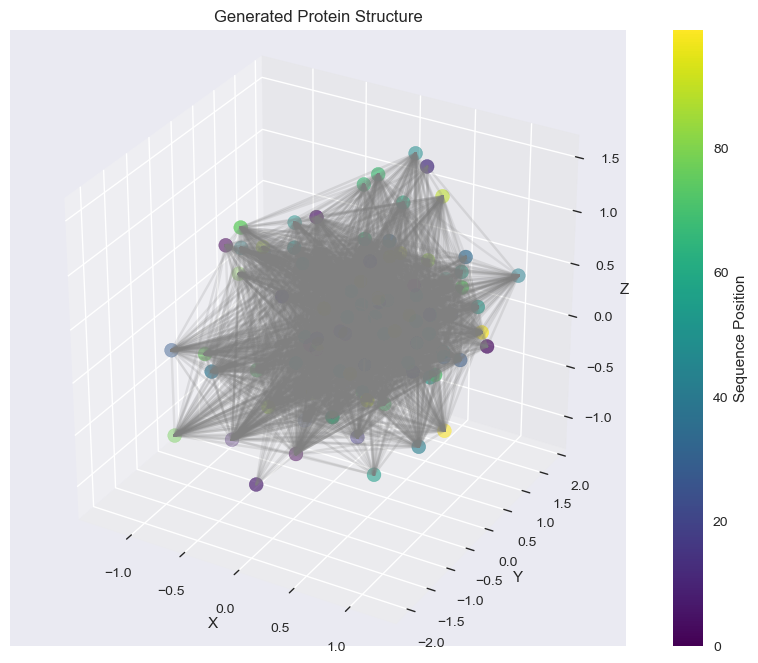

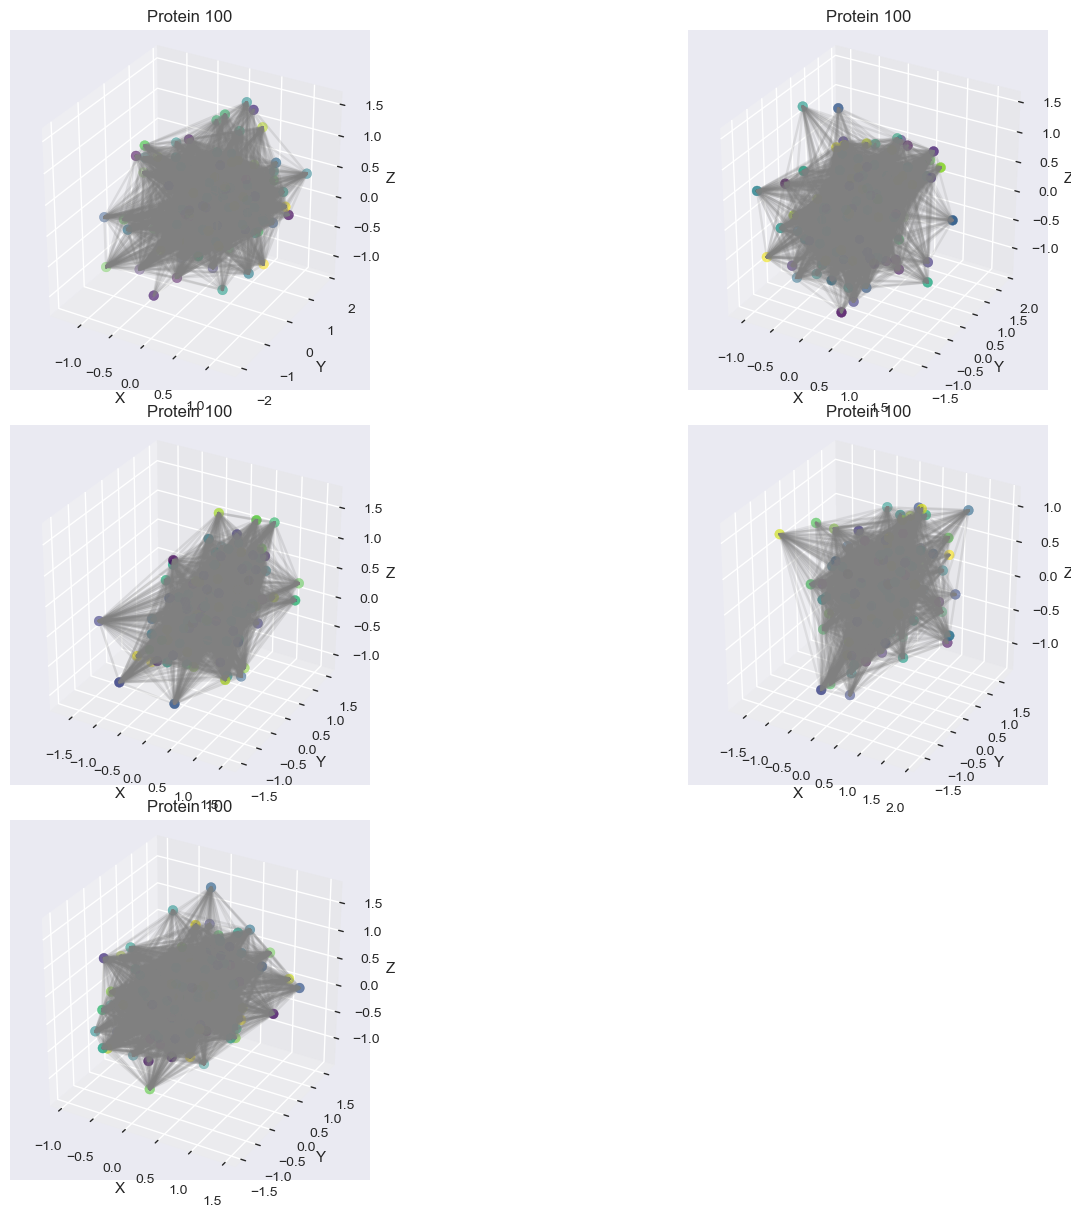

Protein Structure Analysis:
Number of residues: 100
Number of edges (prob > 0.5): 3104
Average edge probability: 0.539
Spatial extent: 5.367

Position ranges:
X: [-1.303, 1.233]
Y: [-2.050, 1.872]
Z: [-1.132, 1.512]


In [31]:
# To visualize a single protein
fig, ax = visualize_protein_structure(generated_proteins[0], 
                                    title="Generated Protein Structure",
                                    edge_threshold=0.5)
plt.show()

# To visualize all proteins in a grid
fig = plot_protein_batch(generated_proteins, 
                        ncols=2,
                        edge_threshold=0.5,
                        node_size=50)
plt.show()

# To analyze a protein's structure
stats = analyze_protein_structure(generated_proteins[0])